# Link between free space and 3-points efficiency

After modelling both model of space occupation and comparing them, we focus on the correlation between space occupation and 3-point performance. To do so, we browse all the games we have, we track when there are 3-point shots and then memorize the evolution of pressure on the shooter 3 seconds before he shots. The algorithm is not presented here, but is available as a python file : track_shoot.py.

Here we extract the informations we want from the data we collected. 

## Data import
-----

The shots are memorized in python dictionnary called Shots. It is composed of four keys :
* D_CLOSEST_DEF : a list of list. Each list corresponds to a shot and has two elements. The first one is 0 or 1 : if it is 1 it means that the shot was a success and if it is 0 the shot was missed. The second element is the evolution of the shooter's *free space* ($\delta_{space}^*$ distance to the closest defender) 3 seconds before the shot. 
* T_CLOSEST_DEF : It the same but *free space* is calculated as the time (in second) needed by the closest defender to join the position of the shooter ($\delta_{time}^*$). 
* TIME_TO_SHOOT : a list of list. Each list has two elements : the first one for the result of the shot and the second one corresponds to the time between the reception of the ball and the shot. It is negative : -2 means that the shooter kept the ball 2 seconds before shooting.
* TIME_ABSCISSE : a list of list. Each list corresponds to a shot and has two elements. The first one is 0 or 1 : if it is 1 it means that the shot was a success and if it is 0 the shot was missed. The second element corresponds to time values linked to pressure evolution.


In [82]:
import pickle
dico=pickle.load(open('data/Shots','rb'))
print(dico.keys())
print('number of shots :', len(dico['D_CLOSEST_DEF']))

dict_keys(['D_CLOSEST_DEF', 'T_CLOSEST_DEF', 'TIME_TO_SHOOT', 'TIME_ABSCISSE'])
number of shots : 27201


## *Free space* evolution before a 3-point shot
------

### Global evolution

First we compute a function that restructured the data. Then we compute a function to plot the evolution of *free space* averaged on all the shots. Let's note that we round the values of time with a precision of 0.01 second. Yet the precision of position data is only 0.04 seconds. 

Let's note that we delet some shots because the values of time are wrong : the clock stops but the evolution continue to be captured therefore, if we don't do that, we have false values for a certain value of time.

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
def restructure_data(data):
    
    ### getting the data ###
    D_CLOSEST_PLAYER=data['D_CLOSEST_DEF']
    T_CLOSEST_PLAYER=data['T_CLOSEST_DEF']
    TIME=data['TIME_ABSCISSE']
    TIME_TO_SHOOT=data['TIME_TO_SHOOT']
    
    ### only the second column because the first one contains if it is a succes or a miss ###
    D_CLOSEST_PLAYER_bis=[]
    T_CLOSEST_PLAYER_bis=[]
    TIME_bis=[]
    TIME_TO_SHOOT_bis=[]
    SUCCESS=[]
    nb_catch_and_shoot=0
    nb_pull_up=0
    nb_success=0
    nb_missed=0
    nb_cns_success=0
    nb_cns_missed=0
    nb_pull_up_success=0
    nb_pull_up_missed=0
    for k in range(len(D_CLOSEST_PLAYER)):
        unique,count=np.unique(np.array(TIME[k][1]).round(2), return_counts=True)
        if list(count)==[1]*len(count): # we don't take shots where values of time are repeated, because in the data, sometimes the values of time doesn't change so stay on the same second but we count the evolution on this second
            if D_CLOSEST_PLAYER[k][0]==0:
                nb_missed+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_missed+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_missed+=1
            else :
                nb_success+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_success+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_success+=1
            D_CLOSEST_PLAYER_bis.append(D_CLOSEST_PLAYER[k][1])
            T_CLOSEST_PLAYER_bis.append(T_CLOSEST_PLAYER[k][1])
            TIME_bis.append(np.array(TIME[k][1]).round(2)) # round to 0.01 second
            TIME_TO_SHOOT_bis.append([TIME_TO_SHOOT[k][1]]*len(TIME[k][1]))
            SUCCESS.append([TIME_TO_SHOOT[k][0]]*len(TIME[k][1]))
    
    print('number of valid shot:',len(D_CLOSEST_PLAYER_bis))
    print('number of success :',nb_success)
    print('number of miss :',nb_missed)
    print('percentage of success:',nb_success/(nb_success+nb_missed)*100)
    print('percentage of catch-and-shoot shots :',nb_catch_and_shoot/(nb_pull_up+nb_catch_and_shoot)*100)
    print('percentage of catch-and-shoot success:',nb_cns_success/(nb_cns_missed+nb_cns_success)*100)
    print('percentage of pull-up success:',nb_pull_up_success/(nb_pull_up_missed+nb_pull_up_success)*100)
    
    ### we concatenate all the data
    TIME_bis=np.concatenate(np.array(TIME_bis)) 
    D_CLOSEST_PLAYER_bis=np.concatenate(np.array(D_CLOSEST_PLAYER_bis))
    T_CLOSEST_PLAYER_bis=np.concatenate(np.array(T_CLOSEST_PLAYER_bis))
    TIME_TO_SHOOT_bis=np.concatenate(np.array(TIME_TO_SHOOT_bis))
    SUCCESS=np.concatenate(np.array(SUCCESS))
    
    ### put the data into a dataframe ###
    df=pd.DataFrame({'D':D_CLOSEST_PLAYER_bis,'T':T_CLOSEST_PLAYER_bis,'Time':TIME_bis,'Time_to_shoot':TIME_TO_SHOOT_bis,'Shot result':SUCCESS})
    
    ## only evolution between 3.2 seconds before shot and 0.8 second after. (It is because there are some errors in the data) ##
    df=df.query('Time>-3.2 and Time<0.8').copy()
    
    return(df)

def averaged_evolution(df,sd=None,hue=None,palette=['blue'],style=None,fontsize='medium'):
    
    ## rename columns to have good labels ##
    df2=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()

number of valid shot: 26325
number of success : 9132
number of miss : 17193
percentage of success: 34.68945868945869
percentage of catch-and-shoot shots : 78.86799620132953
percentage of catch-and-shoot success: 35.84433098930739
percentage of pull-up success: 30.379291749056264


No handles with labels found to put in legend.


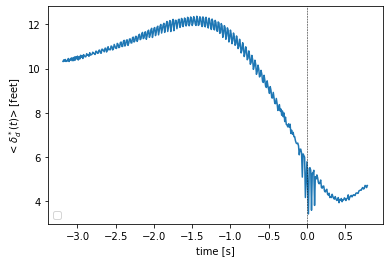

No handles with labels found to put in legend.


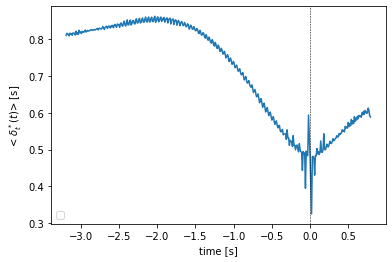

<Figure size 432x288 with 0 Axes>

In [85]:
df=restructure_data(dico)
averaged_evolution(df)

We see that there is some noise. To calculate the plot sns.lineplot take each value of time and make a mean over all the pressure value associated. If we count the number of pressure values per time value we can see that there isn't an equilibrium as there are more of multiple of 0.04 :

In [86]:
print('count',df.groupby('Time').count())

count            D      T  Time_to_shoot  Shot result
Time                                           
-3.19   3326   3326           3326         3326
-3.18   2830   2830           2830         2830
-3.17   4030   4030           4030         4030
-3.16  14286  14286          14286        14286
-3.15   3576   3576           3576         3576
...      ...    ...            ...          ...
 0.75   2328   2328           2328         2328
 0.76  19087  19087          19087        19087
 0.77   3597   3597           3597         3597
 0.78    503    503            503          503
 0.79    165    165            165          165

[397 rows x 4 columns]


Our aim is to make mean for each value of time over the 26325 shots. To do so, we will aggregate values around multiple of 0.04 seconds with the following function :

In [87]:
def aggregating_04(row):
    number=row['Time']
    q=number//0.04
    if abs(round((q*0.04-number),2))<=0.02:
        return(q*0.04)
    else :
        return((q+1)*0.04)

No handles with labels found to put in legend.


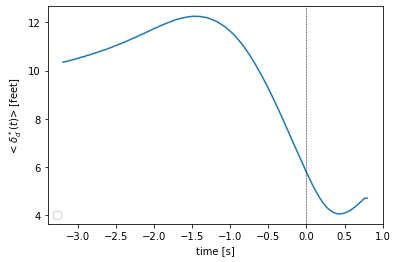

No handles with labels found to put in legend.


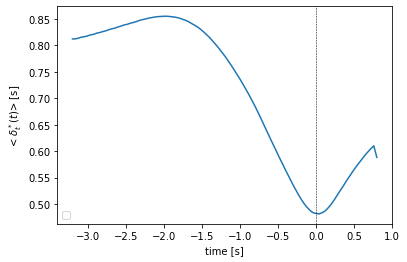

<Figure size 432x288 with 0 Axes>

In [88]:
df['Time']=df.apply(aggregating_04,axis=1)
averaged_evolution(df)

The result is better here. Now let's see if we plot the standard deviation :

/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


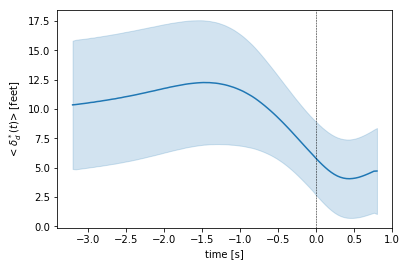

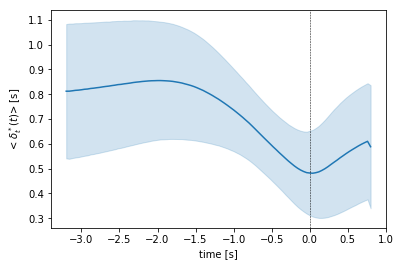

In [12]:
averaged_evolution(df,sd='sd')

### Different types of shots

We distinguish two types of shots :
* catch-and-shoot shot : when a player immediately shot after receiving the ball (2 seconds after)
* pull-up shot : when a player shot after dribbling

In fact some shots can be in neither category : wait more than two seconds without dribbling. But we admit that this is only a small part of shots. Therefore to distinguish both types we look at the value TIME_TO_SHOOT.

We found that there were 78% of catch-and-shoot shots. Yet our games are from 2013 to 2016, according to https://www.thespax.com/nba/three-point-shooting-part-i-the-dying-catch-and-shoot-shot/, there were about 75% of catch-and-shoot shots. Our value is closed to the reality.

In [72]:
def shot_type(row):
    if row['Time_to_shoot']>-2:
        return('catch-and-shoot 3P')
    else :
        return('pull-up 3P')

In [14]:
df['Shot type']=df.apply(shot_type,axis=1)

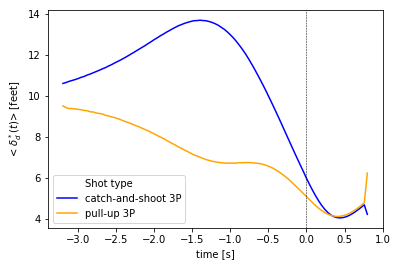

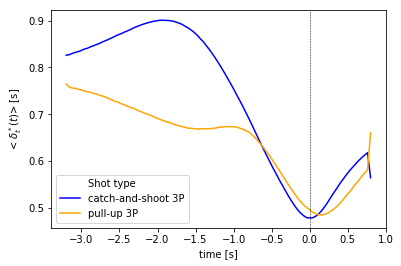

In [15]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type')

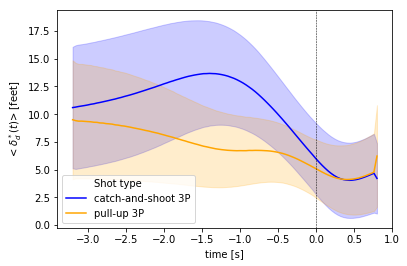

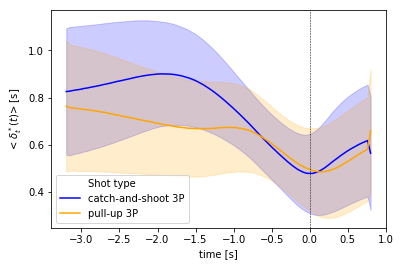

In [16]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type',sd='sd')

### Difference between success and miss

We want to know if the pressure exerced on a player has an influence on his 3-point performance.

In [17]:
def shot_result(row):
    if row['Shot result']==0:
        return('miss')
    else :
        return('success')

In [18]:
df['Shot result']=df.apply(shot_result,axis=1)

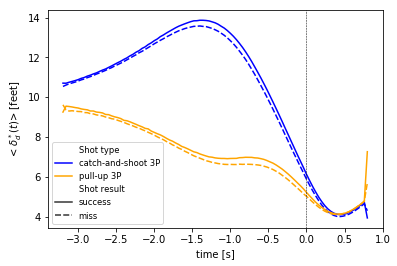

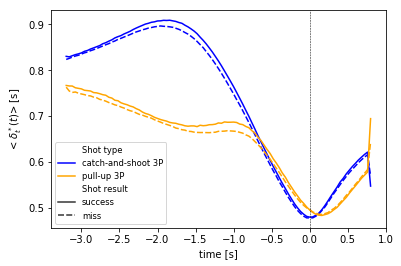

In [19]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type',style='Shot result',fontsize='small')

### Curry's case

In [21]:
dico_curry=pickle.load(open('data/Shots_curry','rb'))

number of valid shot: 375
number of success : 152
number of miss : 223
percentage of success: 40.53333333333333
percentage of catch-and-shoot shots : 53.333333333333336
percentage of catch-and-shoot success: 42.5
percentage of pull-up success: 38.285714285714285


/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


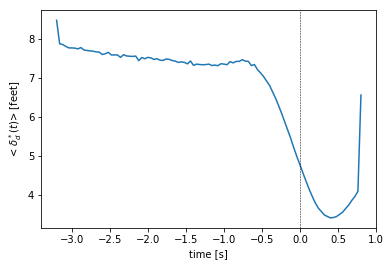

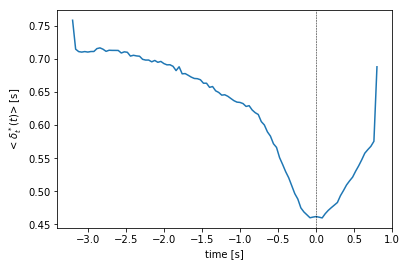

In [22]:
df_curry=restructure_data(dico_curry)
df_curry['Time']=df_curry.apply(aggregating_04,axis=1)
averaged_evolution(df_curry)

/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


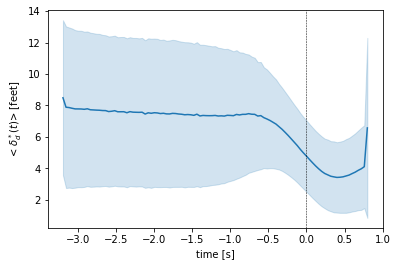

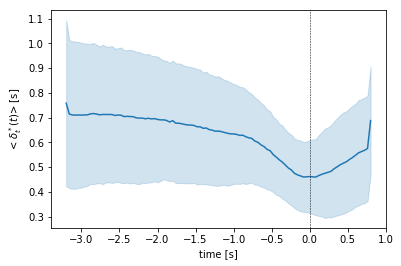

In [23]:
averaged_evolution(df_curry,sd='sd')

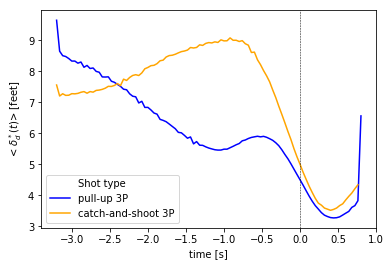

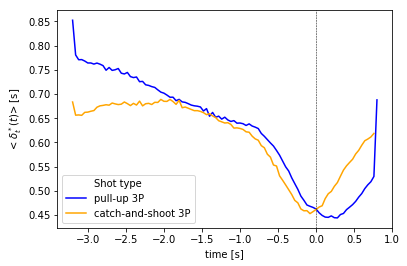

In [24]:
df_curry['Shot type']=df_curry.apply(shot_type,axis=1)
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type')

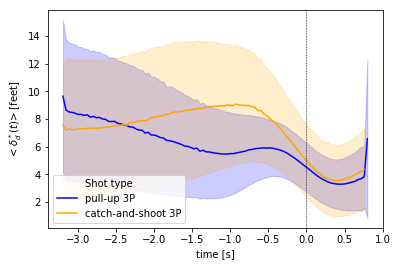

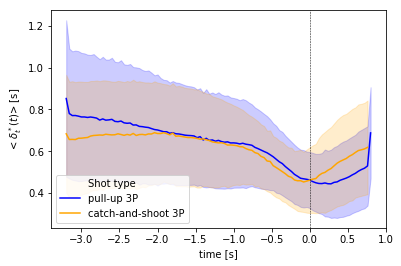

In [25]:
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type',sd='sd')

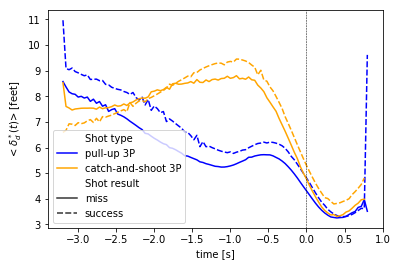

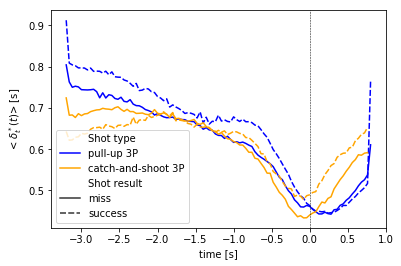

In [26]:
df_curry['Shot result']=df_curry.apply(shot_result,axis=1)
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type',style='Shot result')

### Compare Curry to global behaviour

In [31]:
def averaged_evolution(df,df_curry,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df2=pd.concat([df,df_curry],ignore_index=True)
    players=['all' for k in range(len(df))]+['Curry' for k in range(len(df_curry))]
    df2['Player']=players
    df2=df2.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()

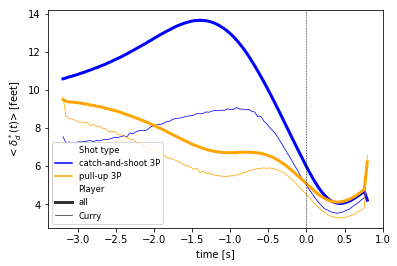

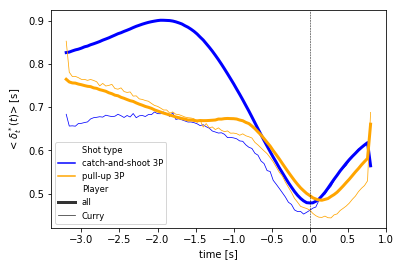

In [32]:
averaged_evolution(df,df_curry,sd=None,hue='Shot type',palette=['blue','orange'],style=None,size='Player')

## *Free space* and 3P performance
------

We want to quantify the following intuition : "the more free a shooter is, the more efficient he is". To do so, we evaluate 3-point efficiency function of the distance (and time) within the opponent defender is. The code is available in python-file/statistics.py.

![](images/efficiency_inferior_d_bis.png)
*Shot efficiency as a function of maximum available space $\delta_{space}^*$ at the release-time of the ball. If the closest defender is within 4 feet, the shooting percentage is 26,3\%, while it goes to 33,6\% if he is within 8 feet.*

![](images/efficiency_inferior_t_bis.png)
*Shot efficiency as a function of maximum available time $\delta_{time}^*$ (free space) at the release of the ball. Around $t=0.5s$ a significant change in behaviour is observed.*


## Trying to classify shots ( _not running_ )
----

In [66]:
from sklearn.cluster import KMeans
#X = np.array(D_CLOSEST_PLAYER_bis)
kmeans = KMeans(n_clusters=2, random_state=0).fit(T_CLOSEST_PLAYER_bis)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [90]:
D_CLOSEST_PLAYER=dico['D_CLOSEST_DEF']
T_CLOSEST_PLAYER=dico['T_CLOSEST_DEF']
TIME_TO_SHOOT=dico['TIME_TO_SHOOT']
TIME=dico['TIME_ABSCISSE']

In [109]:
D_CLOSEST_PLAYER_bis=[]
T_CLOSEST_PLAYER_bis=[]
TIME_bis=[]
TIME_TO_SHOOT_bis=[]
for k in range(len(D_CLOSEST_PLAYER)):
        unique,count=np.unique(np.array(TIME[k][1]).round(2), return_counts=True)
        if list(count)==[1]*len(count): # we don't take shots where values of time are repeated, because in the data, sometimes the values of time doesn't change so stay on the same second but we count the evolution on this second
            if TIME[k][1][0]<-3 and TIME[k][1][-1]>0.5 and len(D_CLOSEST_PLAYER[k][1])>88:
                i=0
                j=-1
                while TIME[k][1][i]<-3 and (len(D_CLOSEST_PLAYER[k][1])+j-i)>87:
                    i+=1
                while (len(D_CLOSEST_PLAYER[k][1])+j-i)>87:
                    j-=1
                if len(D_CLOSEST_PLAYER[k][1][i:j+1])==88:
                    D_CLOSEST_PLAYER_bis=D_CLOSEST_PLAYER_bis+[D_CLOSEST_PLAYER[k][1][i:j+1]]
                    T_CLOSEST_PLAYER_bis.append(T_CLOSEST_PLAYER[k][1][i:j+1])
                    TIME_bis.append(TIME[k][1][i:j+1])
                    TIME_TO_SHOOT_bis.append([TIME_TO_SHOOT[k][1]]*88)

In [62]:
np.array(D_CLOSEST_PLAYER_bis).shape

(25240, 88)

In [47]:
np.array([[1,2],[1,2]]).shape

(2, 2)

In [60]:
for k in range(len(D_CLOSEST_PLAYER_bis)):
    if len(D_CLOSEST_PLAYER_bis[k])!=88:
        print(len(D_CLOSEST_PLAYER_bis[k]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [97]:
unique,count=np.unique(kmeans2.labels_, return_counts=True)

In [98]:
count

array([23228,  2012])

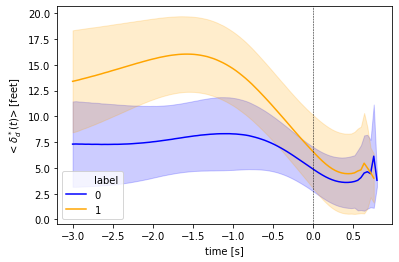

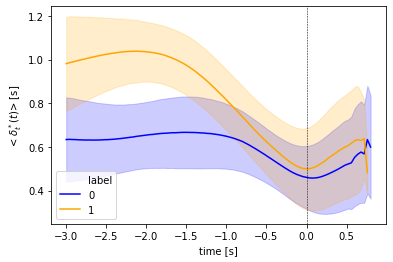

<Figure size 432x288 with 0 Axes>

In [92]:
TIME_bis=np.concatenate(np.array(TIME_bis)) 
D_CLOSEST_PLAYER_bis=np.concatenate(np.array(D_CLOSEST_PLAYER_bis))
T_CLOSEST_PLAYER_bis=np.concatenate(np.array(T_CLOSEST_PLAYER_bis))
TIME_TO_SHOOT_bis=np.concatenate(np.array(TIME_TO_SHOOT_bis))
label=kmeans.labels_
label=np.concatenate(np.array([88*[lab] for lab in label]))
    
### put the data into a dataframe ###
df=pd.DataFrame({'D':D_CLOSEST_PLAYER_bis,'T':T_CLOSEST_PLAYER_bis,'Time':TIME_bis,'Time_to_shoot':TIME_TO_SHOOT_bis,'label':label})
df['Time']=df.apply(aggregating_04,axis=1)
averaged_evolution(df,palette=['blue','orange'],hue='label',sd='sd')

In [96]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(TIME_TO_SHOOT_bis)
kmeans2.labels_

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [94]:
TIME_TO_SHOOT_bis

array([ 0.  ,  0.  ,  0.  , ..., -6.12, -6.12, -6.12])

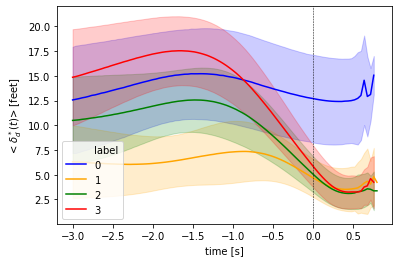

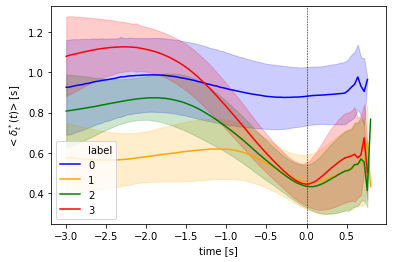

<Figure size 432x288 with 0 Axes>

In [141]:
TIME_plot=np.concatenate(np.array(TIME_bis)) 
D_CLOSEST_PLAYER_plot=np.concatenate(np.array(D_CLOSEST_PLAYER_bis))
T_CLOSEST_PLAYER_plot=np.concatenate(np.array(T_CLOSEST_PLAYER_bis))
TIME_TO_SHOOT_plot=np.concatenate(np.array(TIME_TO_SHOOT_bis))
label=labels[2]
label=np.concatenate(np.array([88*[lab] for lab in label]))
    
### put the data into a dataframe ###
df=pd.DataFrame({'D':D_CLOSEST_PLAYER_plot,'T':T_CLOSEST_PLAYER_plot,'Time':TIME_plot,'Time_to_shoot':TIME_TO_SHOOT_plot,'label':label})
df['Time']=df.apply(aggregating_04,axis=1)
averaged_evolution(df,palette=['blue','orange','green','red'],hue='label',sd='sd')

In [137]:
label

array([2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072, 2072,
       7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757,
       7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757,
       7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757,
       7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757,
       7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757, 7757,
       7757, 7757, 7757, 7757, 7757, 7757, 7757, 77

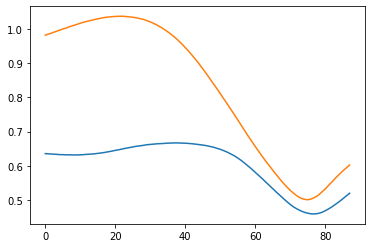

In [104]:
plt.plot(kmeans.cluster_centers_[0])
plt.plot(kmeans.cluster_centers_[1])

In [106]:
kmeans2.inertia_

3412774.2506035743

8
24
36
99
47
39
57
86
76
65
90
78
153


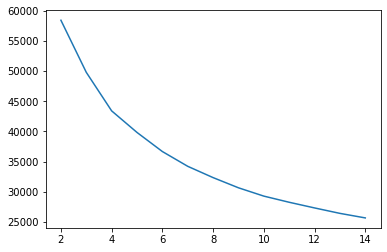

In [138]:
i=[]
c=[]
counts=[]
labels=[]
for k in range(2,15):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(T_CLOSEST_PLAYER_bis)
    print(kmeans.n_iter_)
    c.append(kmeans.cluster_centers_)
    i.append(kmeans.inertia_)
    labels.append(kmeans.labels_)
    unique,count=np.unique(kmeans.labels_, return_counts=True)
    counts.append(count)
plt.plot([2,3,4,5,6,7,8,9,10,11,12,13,14],i)

Text(0, 0.5, '$<\\delta_{t}^*(t)$> [s]')

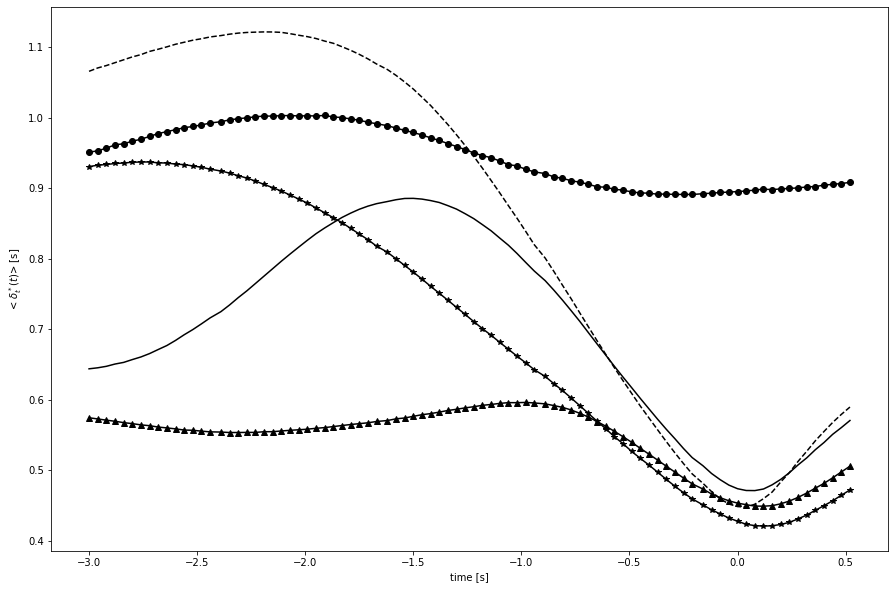

In [160]:
fig=plt.figure(figsize=(15,10))
#plt.plot(TIME_bis[0],c[0][0],'r-')
#plt.plot(TIME_bis[0],c[0][1],'r--')
#plt.plot(c[1][0],'b-')
#plt.plot(c[1][1],'b--')
#plt.plot(c[1][2],'b-o')
#plt.plot(TIME_bis[0],c[2][0],'g-')
#plt.plot(TIME_bis[0],c[2][1],'g--')
#plt.plot(TIME_bis[0],c[2][2],'g-o')
#plt.plot(TIME_bis[0],c[2][3],'g-*')
plt.plot(TIME_bis[0],c[3][0],'k-')
plt.plot(TIME_bis[0],c[3][1],'k--')
plt.plot(TIME_bis[0],c[3][2],'k-o')
plt.plot(TIME_bis[0],c[3][3],'k-*')
plt.plot(TIME_bis[0],c[3][4],'k-^')
#plt.plot(c[4][0],'b-',label='0')
#plt.plot(c[4][1],'b--',label='1')
#plt.plot(c[4][2],'b-o',label='2')
#plt.plot(c[4][3],'b-*',label='3')
#plt.plot(c[4][4],'b-^',label='4')
#plt.plot(c[4][5],'b-4',label='5')
#plt.legend()
plt.xlabel('time [s]')
plt.ylabel(r'$<\delta_{t}^*(t)$> [s]')


In [154]:
counts

[array([11908, 13332]),
 array([6740, 9904, 8596]),
 array([2072, 7757, 8718, 6693]),
 array([4972, 6508, 1862, 5401, 6497]),
 array([3846, 4806, 1788, 6226, 4211, 4363]),
 array([4118, 4669, 5765, 3787, 1309, 3923, 1669]),
 array([2809, 4313, 3346, 1523, 3742, 1246, 4366, 3895]),
 array([3923, 3630, 1452, 2142, 3398, 2785, 1212, 2903, 3795]),
 array([3004, 3018, 3380, 2437, 1408, 1638, 2440, 3511, 3206, 1198]),
 array([3262, 2536, 1509, 2179, 3333, 1109, 1305, 3025, 1486, 3103, 2393]),
 array([1902, 3591,  698, 1189, 2358, 2485, 1502, 1854, 3539, 1068, 2223,
        2831]),
 array([1042, 1857, 1282, 2185, 1424,  661, 3272, 2178, 1156, 2243, 2641,
        2274, 3025]),
 array([2006, 1849, 2536, 1099, 2971,  648, 1376, 1617, 2368, 1195, 1854,
        3008, 1015, 1698])]

In [142]:
df['Shot type']=df.apply(shot_type,axis=1)
df.groupby(['label','shot_type']).count()

,D,T,Time,Time_to_shoot,Shot type
label,,,,,
0,182336,182336,182336,182336,182336
1,682616,682616,682616,682616,682616
2,767184,767184,767184,767184,767184
3,588984,588984,588984,588984,588984


In [147]:
df.groupby(['label','Shot type']).count()

D       T    Time  Time_to_shoot
label Shot type                                                
0     catch-and-shoot 3P  304480  304480  304480         304480
      pull-up 3P           33968   33968   33968          33968
1     catch-and-shoot 3P  301136  301136  301136         301136
      pull-up 3P          121792  121792  121792         121792
2     catch-and-shoot 3P  129536  129536  129536         129536
      pull-up 3P           27808   27808   27808          27808
3     catch-and-shoot 3P  525536  525536  525536         525536
      pull-up 3P           22352   22352   22352          22352
4     catch-and-shoot 3P  281160  281160  281160         281160
      pull-up 3P           89408   89408   89408          89408
5     catch-and-shoot 3P  203368  203368  203368         203368
      pull-up 3P          180576  180576  180576         180576

In [145]:
print(0,':',148368/(148368+33968))
print(1,':',387728/(387728+294888))
print(2,':',664664/(664664+102520))
print(3,':',544456/(544456+44528))

0 : 0.8137065637065637
1 : 0.5680030939796313
2 : 0.866368433126864
0 : 0.9243986254295533


In [146]:
label=labels[4]
label=np.concatenate(np.array([88*[lab] for lab in label]))
df['label']=label

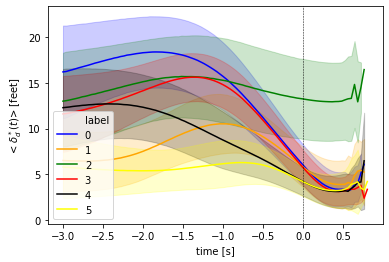

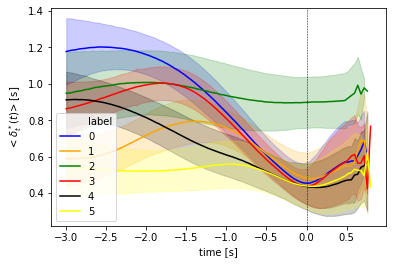

<Figure size 432x288 with 0 Axes>

In [151]:
averaged_evolution(df,palette=['blue','orange','green','red','black','yellow'],hue='label',sd='sd')

In [185]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(T_CLOSEST_PLAYER_bis)

In [162]:
shot1=[1.1138791162330979, 1.1252081128990592, 1.1255564363486081, 1.13829969585573, 1.170856982133858, 1.1813888406627369, 1.1812171320611506, 1.174621918415827, 1.127058260363224, 1.1490988180453883, 1.1271458807867147, 1.126239896595202, 1.139237695785977, 1.1314260641348979, 1.1453494289625927, 1.1053951277040515, 1.1532861234339218, 1.187231246521094, 1.1897913973044405, 1.1900098405707296, 1.1971087774646902, 1.201670809086544, 1.2045371209653803, 1.2154647459113543, 1.2161834002040577, 1.2264679306906863, 1.218038834169461, 1.2078979150538132, 1.202617602056163, 1.1906344063226633, 1.1723048925449437, 1.166634841903186, 1.1328873113771332, 1.0962674380365596, 1.0745022161932414, 1.0576603048948476, 1.0212970098681995, 0.9817740336309831, 0.9502681938973192, 0.9132270440250824, 0.8782928105742063, 0.8475546309016747, 0.809995833879451, 0.7633467095230091, 0.7575447123652539, 0.7596205742851626, 0.7661379583207268, 0.6401376982424318, 0.7425860763626551, 0.6731922719464768, 0.6483476548379642, 0.6351354845939753, 0.6220597979774142, 0.6160150846581268, 0.5821838316316655, 0.5682279684215036, 0.5537252303793271, 0.5444138698318425, 0.5411687223296384, 0.5295648606411479, 0.5138508229876281, 0.5084665900646791, 0.49376032094757955, 0.4697768647533659, 0.45792771503774976, 0.4511284648990317, 0.46002498152364324, 0.4399491906683648, 0.4164292852479782, 0.4225870052587815, 0.40860468351691326, 0.3602376407305395, 0.3436037359498574, 0.3269973515039913, 0.3099022734749422, 0.3728625901841134, 0.3863389804036024, 0.4176138663011148, 0.48495831336544887, 0.5216590289116617, 0.550699291037743, 0.5943114319576153, 0.54931931347124, 0.6788613007263659, 0.6539587958286482, 0.6563850545826158, 0.6049808733575428, 0.5970886554091355, 0.5955031370760294, 0.565217213031166, 0.5839747667773111, 0.6015612855551519, 0.6177909618450692, 0.6016389030017109, 0.5957907830696967, 0.5888884910274119, 0.6038966647845548, 0.5938441247924128, 0.5913324074315576, 0.6328529494114296]
shot2=[0.2515984329398496, 0.2578002735225842, 0.23885699383268644, 0.24773525398886087, 0.2525930854373177, 0.25893912663707497, 0.27672732716387555, 0.28296935242353244, 0.2856557214116407, 0.2920677795241804, 0.3058049221430766, 0.3235001039975144, 0.3311427568944639, 0.3401174646891609, 0.3138401192871076, 0.35103443407098006, 0.3283311777287966, 0.33748551291653545, 0.3412531511669228, 0.3472144367810121, 0.356213707746184, 0.3677851796083952, 0.3744600220968456, 0.37447192627319453, 0.3659819828817598, 0.38506572273319517, 0.3751634063046685, 0.3733586584760323, 0.36485399782012307, 0.35982280153274815, 0.3575522178711084, 0.3562425754555958, 0.3418717218386689, 0.4291204801610471, 0.3269822303072765, 0.44603250638382635, 0.32896695450391317, 0.30792174913529574, 0.30274231303165455, 0.3040960869286369, 0.34303477792682446, 0.3157738968052464, 0.3252166964788528, 0.33319636751966525, 0.34479070471296985, 0.3593884212503487, 0.3821277493957498, 0.44966199027378456, 0.4841679464017617, 0.5175865786736443, 0.5460064777411231, 0.5705807217088285, 0.5693796531643399, 0.5895538438008697, 0.61074782678478, 0.6182868655237937, 0.6151938244769567, 0.6247519348543049, 0.6408834046329872, 0.6580288089812313, 0.6619697415277427, 0.6689149077757133, 0.6488648040190059, 0.6383026676434551, 0.6436379978037142, 0.6262613890716545, 0.5931523551878349, 0.5934456464942776, 0.5862848347599495, 0.5757764399593474, 0.566269134091738, 0.5613430927648693, 0.5554609514315503, 0.5477743429422671, 0.5374228135771445, 0.5197742297047414, 0.5107896110791804, 0.5115593720815867, 0.5072932264019256, 0.514556131745076, 0.5140651424606326, 0.5161341145397691, 0.5013714386793482, 0.4886247373136573, 0.4867200462272253, 0.49040697413234224, 0.4878324830573355, 0.4823622386138822, 0.4882831990122453, 0.5057368806207945, 0.5131846782316367, 0.5175786722563874, 0.5244988955861015, 0.5296393382889011, 0.5446182289036066, 0.5482918099870756, 0.5636146643183121, 0.5739699477030806, 0.5874582115796323, 0.59238792295075]
times1=[-3.2100000000000364, -3.170000000000016, -3.1300000000000523, -3.090000000000032, -3.0500000000000114, -3.0100000000000477, -2.9700000000000273, -2.930000000000007, -2.890000000000043, -2.8500000000000227, -2.8100000000000023, -2.7700000000000387, -2.730000000000018, -2.6900000000000546, -2.650000000000034, -2.6100000000000136, -2.57000000000005, -2.5300000000000296, -2.490000000000009, -2.4500000000000455, -2.410000000000025, -2.3700000000000045, -2.330000000000041, -2.2900000000000205, -2.25, -2.2000000000000455, -2.170000000000016, -2.1300000000000523, -2.090000000000032, -2.0500000000000114, -2.0100000000000477, -1.9700000000000273, -1.9300000000000068, -1.8800000000000523, -1.8500000000000227, -1.8000000000000114, -1.7700000000000387, -1.7300000000000182, -1.6900000000000546, -1.650000000000034, -1.6000000000000227, -1.57000000000005, -1.5200000000000387, -1.4800000000000182, -1.4400000000000546, -1.400000000000034, -1.3600000000000136, -1.32000000000005, -1.2800000000000296, -1.240000000000009, -1.2000000000000455, -1.160000000000025, -1.1200000000000045, -1.080000000000041, -1.0400000000000205, -1.0, -0.9600000000000364, -0.9200000000000159, -0.8800000000000523, -0.8400000000000318, -0.8000000000000114, -0.7600000000000477, -0.7200000000000273, -0.6800000000000068, -0.6400000000000432, -0.6000000000000227, -0.5600000000000023, -0.5200000000000387, -0.4800000000000182, -0.44000000000005457, -0.4000000000000341, -0.36000000000001364, -0.32000000000005, -0.28000000000002956, -0.2400000000000091, -0.20000000000004547, -0.160000000000025, -0.12000000000000455, -0.08000000000004093, -0.040000000000020464, 0.0, 0.03999999999996362, 0.07999999999998408, 0.1199999999999477, 0.15999999999996817, 0.19999999999998863, 0.23999999999995225, 0.2799999999999727, 0.3199999999999932, 0.3599999999999568, 0.39999999999997726, 0.4399999999999977, 0.47999999999996135, 0.5199999999999818, 0.5599999999999454, 0.5999999999999659, 0.6399999999999864, 0.67999999999995, 0.7199999999999704, 0.7599999999999909]
times2=[-3.210000000000008, -3.170000000000016, -3.1299999999999955, -3.0900000000000034, -3.0500000000000114, -3.009999999999991, -2.969999999999999, -2.930000000000007, -2.890000000000015, -2.8499999999999943, -2.8100000000000023, -2.7700000000000102, -2.7299999999999898, -2.6899999999999977, -2.6500000000000057, -2.6100000000000136, -2.569999999999993, -2.530000000000001, -2.490000000000009, -2.4499999999999886, -2.4099999999999966, -2.3700000000000045, -2.3300000000000125, -2.289999999999992, -2.25, -2.210000000000008, -2.170000000000016, -2.1299999999999955, -2.0800000000000125, -2.0500000000000114, -2.0, -1.9699999999999989, -1.920000000000016, -1.8900000000000148, -1.8499999999999943, -1.8100000000000023, -1.7700000000000102, -1.7199999999999989, -1.6800000000000068, -1.6400000000000148, -1.5999999999999943, -1.5600000000000023, -1.5200000000000102, -1.4799999999999898, -1.4399999999999977, -1.4000000000000057, -1.3600000000000136, -1.3199999999999932, -1.2800000000000011, -1.240000000000009, -1.1999999999999886, -1.1599999999999966, -1.1200000000000045, -1.0800000000000125, -1.039999999999992, -1.0, -0.960000000000008, -0.9200000000000159, -0.8799999999999955, -0.8400000000000034, -0.8000000000000114, -0.7599999999999909, -0.7199999999999989, -0.6800000000000068, -0.6400000000000148, -0.5999999999999943, -0.5600000000000023, -0.5200000000000102, -0.47999999999998977, -0.4399999999999977, -0.4000000000000057, -0.36000000000001364, -0.3199999999999932, -0.28000000000000114, -0.2400000000000091, -0.19999999999998863, -0.1599999999999966, -0.12000000000000455, -0.0800000000000125, -0.03999999999999204, 0.0, 0.03999999999999204, 0.07999999999998408, 0.12000000000000455, 0.1599999999999966, 0.19999999999998863, 0.2400000000000091, 0.28000000000000114, 0.3199999999999932, 0.3599999999999852, 0.4000000000000057, 0.4399999999999977, 0.47999999999998977, 0.5200000000000102, 0.5600000000000023, 0.5999999999999943, 0.6399999999999864, 0.6800000000000068, 0.7199999999999989, 0.7599999999999909]

In [173]:
if times1[0]<-3 and times1[-1]>0.5 and len(shot1)>88:
    i=0
    j=-1
    while times1[i]<-3 and (len(shot1)+j-i)>87:
        i+=1
    while (len(shot1)+j-i)>87:
        j-=1
    if len(shot1[i:j+1])==88:
        shots1_bis=shot1[i:j+1]
        times1_bis=times1[i:j+1]

if times2[0]<-3 and times2[-1]>0.5 and len(shot2)>88:
    i=0
    j=-1
    while times2[i]<-3 and (len(shot2)+j-i)>87:
        i+=1
    while (len(shot2)+j-i)>87:
        j-=1
    if len(shot2[i:j+1])==88:
        shots2_bis=shot2[i:j+1]
        times2_bis=times2[i:j+1]

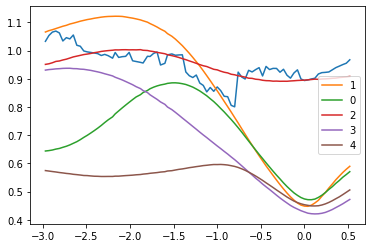

In [194]:
plt.plot(times1_bis,T_bis[1])
plt.plot(times1_bis,kmeans.cluster_centers_[1],label='1')
plt.plot(times1_bis,kmeans.cluster_centers_[0],label='0')
plt.plot(times1_bis,kmeans.cluster_centers_[2],label='2')
plt.plot(times1_bis,kmeans.cluster_centers_[3],label='3')
plt.plot(times1_bis,kmeans.cluster_centers_[4],label='4')
plt.legend()

In [191]:
kmeans.predict([shots1_bis])

array([1], dtype=int32)

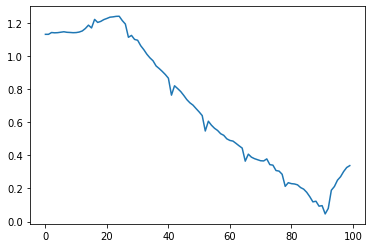

In [176]:
plt.plot([1.1297835380494436, 1.1297845168280614, 1.1405925905868983, 1.1388707825064055, 1.1398131263103723, 1.1425304634929134, 1.1452631310789692, 1.1420700491484101, 1.1409990160318304, 1.1396340241703034, 1.1403129708217463, 1.1435464906370707, 1.1502042890805524, 1.1649928268430065, 1.1851119501184149, 1.1682557992808686, 1.2198783029061033, 1.2015233284132538, 1.2078366959080689, 1.2185936885459092, 1.2255378059995756, 1.2331587670441995, 1.2350936314909324, 1.238201509266008, 1.2388285521882576, 1.212633427546066, 1.1919287945736559, 1.1120163411454806, 1.1232567092482366, 1.0989772335907506, 1.0940465407272348, 1.0610389371251003, 1.0372705867189136, 1.0097654906361362, 0.9877573099963127, 0.9702042709725432, 0.939024847833576, 0.9234622090856999, 0.9062849191710833, 0.8873911311568358, 0.8651405394183773, 0.7630427106207621, 0.8194817472947735, 0.8026994671443085, 0.7848564497523896, 0.7613885871779122, 0.73594276057997, 0.7166734829583795, 0.7027889913921106, 0.6819732956304853, 0.6618486806265731, 0.6397899152463605, 0.5467806363019673, 0.6057576707540607, 0.5817022167801303, 0.5631664119526545, 0.549985150147307, 0.5303814099525622, 0.5207547215149627, 0.4995156188438633, 0.48983748736738214, 0.485980235818136, 0.47201407247632615, 0.4573892546827602, 0.44373889721658405, 0.364870423096393, 0.4070323602405637, 0.3891216295862098, 0.3799319559816704, 0.37359984026297993, 0.3673664857518784, 0.36625113905478723, 0.37852127248110135, 0.34385073457043525, 0.34076092496631466, 0.3083835882124975, 0.30483619973846543, 0.28568269837236626, 0.2129307691805486, 0.23500956407528836, 0.2292640335230002, 0.22732975073454534, 0.22204007137841503, 0.20571208884712622, 0.1960768574683269, 0.176899138884946, 0.15035437344781669, 0.11938987243681018, 0.12317375825205523, 0.09344065082625841, 0.09654485289170274, 0.04669578945021175, 0.07985620652198441, 0.1893729969752322, 0.2120697487769076, 0.25018962639216835, 0.2709655578336215, 0.30223338467609506, 0.3266319490829295, 0.33797005309631756])

In [178]:
T=[[1, [0.8479570300396599, 0.8277184735272738, 0.8243321529262974, 0.8754913296366166, 0.8846155743635897, 0.9584158784032116, 1.0141564012004314, 1.0093171204287346, 1.027108029381992, 1.0413907543286434, 1.0484886893545906, 1.0484250838226643, 1.0612555265348638, 1.0723679023646375, 1.085097329227232, 1.0856301657009162, 1.0717605759032234, 1.0702178972486045, 1.0570053766363938, 1.0451814943165791, 0.9942562554950062, 1.0185764583206394, 1.0085973102381303, 1.00601448196727, 0.9979223067433078, 0.9856576249801627, 0.9857790681462182, 0.9796500089535817, 0.9721921216220015, 0.9714739458423493, 0.9664494711377448, 0.9676524040106996, 0.9542861029633294, 0.9551170144241303, 0.9433506471357445, 0.9547519985203609, 0.9405229555471599, 0.9394412236869767, 0.9405085247535343, 0.9367846608443027, 0.9302241476110104, 0.9221508696077562, 0.9204197897608177, 0.9206621895931614, 0.911011610972579, 0.9102106172917851, 0.8921112873983934, 0.8952020241134148, 0.8907908664086486, 0.8891891140433749, 0.8821233121846118, 0.8839518906068065, 0.8755049797722816, 0.8669767486174875, 0.8599473687544322, 0.8461057311814979, 0.8166081427214711, 0.7966829496411629, 0.7687864785325057, 0.7492081062371089, 0.7295607326793767, 0.7105849063882955, 0.6944089327056792, 0.6669358759946337, 0.6631301281418495, 0.6242013823539257, 0.6140998137914263, 0.5864265320296959, 0.5572814933943674, 0.5381441679225679, 0.5137312102759256, 0.5020217678252517, 0.4827004862605118, 0.4671888258187766, 0.4512765131191049, 0.4359903821611214, 0.4194216756559392, 0.3955184885762403, 0.37882642080651724, 0.35898749409014363, 0.36437786054357535, 0.36139278184343815, 0.43349586649437377, 0.5480343190486153, 0.6100882816686748, 0.671265309841315, 0.7451717157655875, 0.7856268925777072, 0.790015063089361, 0.8305639337008554, 0.8667491227824103, 0.9218146780219678, 0.8980141695710475, 0.9488191313227519, 0.9471624900760175, 0.9618542641655656, 0.9776072401015353, 0.992330260992824, 1.0122111377490344, 1.0462453850795879]], [0, [0.9647198269996493, 0.9733393130803043, 0.9863775486543946, 0.9904110795027461, 1.0124404362455617, 1.0221348645227346, 1.0324331420274948, 1.0531036826315678, 1.065207909133544, 1.0688561825163565, 1.0621595956721859, 1.0337606010789675, 1.045496654875316, 1.0411336434782494, 1.054899206076257, 1.0185923105346157, 1.0150914289320494, 0.9983500210964068, 0.9950804231466907, 0.9931381349552756, 0.9911238130787552, 0.9889197678148348, 0.9823235601322454, 0.9862221151250474, 0.9815813092055305, 0.9727949550731648, 0.9929424639897922, 0.9754874900438387, 0.9781055610218157, 0.979224061435856, 0.9931865688077482, 0.9635454120601942, 0.9610405266829923, 0.9579560159961169, 0.9557289081490545, 0.9795718620102325, 0.9788257040914834, 0.9896288348450019, 0.9945957015500271, 0.9486526715187329, 0.9545586191579817, 0.9845449766712004, 0.9878942289560831, 0.9831904756788394, 0.9842365353208651, 0.9847870036828792, 0.9239665165834934, 0.9106005937839262, 0.904308894857905, 0.9130869086748965, 0.8847421698141213, 0.8762920612343794, 0.8533730476277623, 0.8689512526624791, 0.8554470814279677, 0.870878664369227, 0.857849397153178, 0.8378023807111523, 0.8363853474265315, 0.8057535551607959, 0.8005184892505809, 0.9234264190697067, 0.9062796301693725, 0.8989770717494474, 0.9298135793944784, 0.9240165488741623, 0.9322486242307395, 0.9391965788150264, 0.9098871061526218, 0.9435919682037616, 0.9324202092104097, 0.9366573269427798, 0.9365093862351441, 0.92306787719537, 0.9335534297797375, 0.9124305297866161, 0.9021036079396263, 0.9204304065508019, 0.9314612291110054, 0.899171898630318, 0.8936711205650422, 0.8958009174894611, 0.8992138634496315, 0.9017507738207892, 0.9168415438831284, 0.9216057209692683, 0.9225531979787407, 0.9239956444546842, 0.9316184584649552, 0.9392942371710651, 0.9446742439540874, 0.9501564511023936, 0.9549583460121588, 0.9670674698891761, 0.9863427105355983, 0.9851688332099195, 1.0003563227969718, 1.0124169436333397, 0.9773720874271589, 1.0000894162854759]], [1, [1.1138791162330979, 1.1252081128990592, 1.1255564363486081, 1.13829969585573, 1.170856982133858, 1.1813888406627369, 1.1812171320611506, 1.174621918415827, 1.127058260363224, 1.1490988180453883, 1.1271458807867147, 1.126239896595202, 1.139237695785977, 1.1314260641348979, 1.1453494289625927, 1.1053951277040515, 1.1532861234339218, 1.187231246521094, 1.1897913973044405, 1.1900098405707296, 1.1971087774646902, 1.201670809086544, 1.2045371209653803, 1.2154647459113543, 1.2161834002040577, 1.2264679306906863, 1.218038834169461, 1.2078979150538132, 1.202617602056163, 1.1906344063226633, 1.1723048925449437, 1.166634841903186, 1.1328873113771332, 1.0962674380365596, 1.0745022161932414, 1.0576603048948476, 1.0212970098681995, 0.9817740336309831, 0.9502681938973192, 0.9132270440250824, 0.8782928105742063, 0.8475546309016747, 0.809995833879451, 0.7633467095230091, 0.7575447123652539, 0.7596205742851626, 0.7661379583207268, 0.6401376982424318, 0.7425860763626551, 0.6731922719464768, 0.6483476548379642, 0.6351354845939753, 0.6220597979774142, 0.6160150846581268, 0.5821838316316655, 0.5682279684215036, 0.5537252303793271, 0.5444138698318425, 0.5411687223296384, 0.5295648606411479, 0.5138508229876281, 0.5084665900646791, 0.49376032094757955, 0.4697768647533659, 0.45792771503774976, 0.4511284648990317, 0.46002498152364324, 0.4399491906683648, 0.4164292852479782, 0.4225870052587815, 0.40860468351691326, 0.3602376407305395, 0.3436037359498574, 0.3269973515039913, 0.3099022734749422, 0.3728625901841134, 0.3863389804036024, 0.4176138663011148, 0.48495831336544887, 0.5216590289116617, 0.550699291037743, 0.5943114319576153, 0.54931931347124, 0.6788613007263659, 0.6539587958286482, 0.6563850545826158, 0.6049808733575428, 0.5970886554091355, 0.5955031370760294, 0.565217213031166, 0.5839747667773111, 0.6015612855551519, 0.6177909618450692, 0.6016389030017109, 0.5957907830696967, 0.5888884910274119, 0.6038966647845548, 0.5938441247924128, 0.5913324074315576, 0.6328529494114296]], [0, [0.6037057729934399, 0.625034479849829, 0.6405462202996536, 0.680723689644902, 0.7122445710427519, 0.7509446931319296, 0.7828782030560058, 0.8300640080590198, 0.8526764237879951, 0.878093492035971, 0.8918127807738068, 0.9078320387608023, 0.9218838979258505, 0.9400813910698087, 0.9583155807554387, 0.983276706777849, 1.0062674654553616, 1.0291119666474442, 1.0521389241703418, 1.0754544601961156, 1.1063329812314808, 1.128581345335057, 1.130448605840683, 1.1020712327445596, 1.1111550333102416, 1.1074733469061415, 1.0989118541601246, 1.1052459530238292, 1.0354486334243547, 1.0965522980550864, 1.0313746673992672, 1.093093231538018, 1.0446638370543668, 1.1043724056456987, 1.0889412914770602, 1.1090253133186523, 1.1399097486783603, 1.1420849939258533, 1.1516468901210513, 1.1745083656124893, 1.1725376870558606, 1.181887653610202, 1.1455550848711142, 1.157062469124324, 1.1432909088081964, 1.0576535304448758, 1.0205215031296913, 1.0005631697008142, 0.9574686440703294, 0.9235030363903498, 0.90272170708599, 0.8948172773271565, 0.8765689586042654, 0.8557538835679084, 0.8309259102699335, 0.8121274968774302, 0.7934908984154811, 0.7779013248200513, 0.7553933386536891, 0.7255211878581646, 0.7097118394485192, 0.6942605483999773, 0.668412116138219, 0.6504525776225444, 0.622814763640469, 0.5774896332974166, 0.5646266131076129, 0.5239042179234062, 0.5131163338220776, 0.49489078557897476, 0.48187536928195235, 0.4613317895288604, 0.43866231482255724, 0.42367706258790594, 0.414880716550541, 0.39710601987273336, 0.3930076692894909, 0.38303397318958915, 0.3739555294682249, 0.3760444810073785, 0.38349741791951947, 0.42828793881445937, 0.5101518112722543, 0.643731479944213, 0.7222110404326111, 0.7967951361912154, 0.857190372211058, 0.913374044237651, 0.9311647773307495, 0.9212363843738853, 0.9144053753065519, 0.9118128691604847, 0.9087561837707122, 0.9064552587633024, 0.905463706472261, 0.9113979797508173, 0.9088146871843775, 0.9160257498298263, 0.9165517159544273, 0.9242489736291509]], [0, [0.4300673466955519, 0.4348024982077016, 0.4366965667161641, 0.4407943047153877, 0.4457169332652936, 0.44148842293041723, 0.4458714266934984, 0.3941587939737217, 0.40269879050325386, 0.3844965947532104, 0.3669458730855696, 0.31993059002205043, 0.30333952461113367, 0.2907015855091213, 0.29485451411097297, 0.3026010333369083, 0.31710650518737404, 0.3512213554358833, 0.41701038087803066, 0.4790469410137025, 0.5354290742614582, 0.6040349408018116, 0.6462681645357048, 0.7068869110839835, 0.7432638859872819, 0.773123537766644, 0.7947569806861223, 0.823213074426937, 0.8531967377771525, 0.8508217086640006, 0.8524326008067244, 0.8583719751433347, 0.8623130794271817, 0.8658925831394486, 0.8648834688653293, 0.872301263912998, 0.8730243767020032, 0.8670898242963723, 0.8689729206492165, 0.8671316793944743, 0.8621408768347524, 0.8474529760480253, 0.8294790301060807, 0.8274783483174971, 0.830476315188983, 0.8310242897730272, 0.8255330364496949, 0.8245980877919763, 0.8153738839975411, 0.8115513661997403, 0.7933501752050443, 0.7794594039449972, 0.7710433681476245, 0.7645162327335799, 0.748042659362874, 0.7334025866377059, 0.734406169135979, 0.7282590509155037, 0.7143107782224613, 0.6934820005970906, 0.6669489552406773, 0.6453991369978614, 0.6260808198090945, 0.6073518682707267, 0.5812240836430357, 0.557915853585608, 0.5497401804392977, 0.547361246172399, 0.525921322537903, 0.513569863681086, 0.49758710872224987, 0.4762677658257851, 0.46425972382869923, 0.4536708578607402, 0.4454794341359561, 0.4319350446254443, 0.4238854805501237, 0.417066029224577, 0.4088336836356916, 0.3901538885979463, 0.3944072723928459, 0.3884696640766914, 0.35825783784460374, 0.3614223600713474, 0.35042624254555244, 0.3419779854514265, 0.3331331585758244, 0.3229801521751056, 0.3135092695964452, 0.30340180663076016, 0.3026365530766588, 0.2906100363500734, 0.2789730944281759, 0.2781239630493986, 0.2901493750922606, 0.22819841210238112, 0.2188243973326267, 0.23866772671395714, 0.18128028597317875, 0.16895378446145587]], [1, [1.3402907380276396, 1.3169575416935888, 1.2843752691532506, 1.2329103863934985, 1.2300119535037328, 1.2093916788467487, 1.1898579644175764, 1.1636963969631777, 1.140061602163698, 1.1229293413360621, 1.099297054764053, 1.087326465823077, 1.0734441398381425, 1.0572203349837765, 1.0365731850550592, 1.0269578090398934, 1.0084947057663805, 0.9967182510041362, 0.9844342436857444, 0.9519555468658006, 0.9308851557185969, 0.9008616068741037, 0.8846741779558538, 0.8743702294546289, 0.8498206496532239, 0.8647174336402484, 0.8145428481205483, 0.793028913061962, 0.7719463823947007, 0.7538004431495334, 0.7312147680872827, 0.7157760047931936, 0.7316698622290321, 0.6770094794466327, 0.6636381966508953, 0.6597828519067527, 0.6636455576143911, 0.6456027987670465, 0.6245292901893367, 0.5942144763668825, 0.6312553810042297, 0.5809035407474672, 0.5646563438496316, 0.5469129702615172, 0.5348180407096238, 0.5292431147582233, 0.5160855362793664, 0.5104025495560258, 0.536990687804838, 0.5071360242471984, 0.48213221083683333, 0.4633190691986661, 0.44840389247745716, 0.4322051314006283, 0.4659854510414187, 0.40792263393431544, 0.3922899312482198, 0.38583160493172597, 0.3843536427874681, 0.37606460768626554, 0.36671060651026155, 0.3574615545304084, 0.36812865071890616, 0.3389529925118771, 0.32260086289354206, 0.31882937386401516, 0.3210395243331568, 0.32347932840093296, 0.3316306523051671, 0.3392701782021808, 0.335262399995636, 0.3316879620680962, 0.33716838221965767, 0.34755422729519697, 0.372465025492812, 0.38423380955962017, 0.3987199993487922, 0.38504990810416884, 0.41656105436762586, 0.4255847729082083, 0.4439264965008302, 0.4436501924896357, 0.4511130411622868, 0.4529033983719995, 0.4316711528087074, 0.4737255782285741, 0.4834738807335537, 0.4914730404909233, 0.48471110532877815, 0.47938272738601384, 0.48665033089952314, 0.46414464522428406, 0.49325906550412146, 0.4941408296680257, 0.49622680099959215, 0.48796785703875145, 0.5016812225878234, 0.49188088696559173, 0.4943520428732959, 0.471810085629407]], [1, [0.3059076870235686, 0.32252657202504315, 0.33808593051004027, 0.35310007870414384, 0.3635497164905139, 0.37075068809472556, 0.3799153555495435, 0.3885725877549746, 0.3935526249732834, 0.40031995476319726, 0.4069834669142601, 0.4140088626852083, 0.4210061108330958, 0.42834749688297646, 0.4372487528275184, 0.44848805043956985, 0.45553896286840034, 0.45108462879170985, 0.44623440840699014, 0.4146879229747534, 0.3763627519147478, 0.34082144776472034, 0.3167217300304149, 0.3158300257586019, 0.3391011381506887, 0.3760236809951812, 0.4179622459472933, 0.4616928674248985, 0.5037852845606599, 0.5448510102830715, 0.5828449016260224, 0.61156406160433, 0.6321478079687446, 0.6532217415339728, 0.671333451030281, 0.6788920531629276, 0.6871629424749108, 0.6948185337032864, 0.7027225993667191, 0.7101003109562662, 0.7174550846738759, 0.724277140565428, 0.7298104073411226, 0.7348755556948586, 0.7392018758391087, 0.7422561766724582, 0.7451853517760265, 0.7469014678912392, 0.7482056484304381, 0.7483596861505205, 0.7477309608426751, 0.7457284996662481, 0.7433640624456899, 0.7399535232490747, 0.7352275628929376, 0.7300991921342688, 0.7228788639727565, 0.7178938942321322, 0.7125509773023035, 0.7394471269425473, 0.4173116993605124, 0.4108263321730578, 0.4090636718327856, 0.4094757597615327, 0.4441714868507298, 0.398422945568565, 0.38984990341655584, 0.38208957415127154, 0.37652074269829605, 0.36996823409473734, 0.37566410343296525, 0.3525028646609503, 0.3257002189014087, 0.3297670304691489, 0.32407699987205013, 0.3138479844488583, 0.2891755962381996, 0.27068688124416646, 0.2677707679177086, 0.22252034013306654, 0.21209477528676135, 0.19447978846992758, 0.17603109375964993, 0.15928192985173528, 0.14097188008166278, 0.12236332526543701, 0.10015449601797417, 0.08895627753512599, 0.33210542454526176, 0.3805279146437877, 0.3911835302589482, 0.3741576580289143, 0.3900263898565839, 0.2759073707240373, 0.45602428471510736, 0.28530507646544, 0.3637691915084559, 0.3882848370824525, 0.39316102442143697, 0.3982943344565382]], [0, [1.106729995444518, 1.0934980084313428, 1.084185660822034, 1.076752415836594, 1.0624794958850061, 1.0516506173392144, 1.0459026111175929, 1.036138984576004, 1.027099724247597, 1.024169518554523, 1.0054321906917103, 0.997017636718989, 0.9857707156821589, 0.9733655700731998, 0.9597838704489199, 0.9500708177809087, 0.9396711373183414, 0.9263359650030033, 0.9150534908503414, 0.9066538621202221, 0.8933651925049974, 0.8800850728915588, 0.8753371877575309, 0.8548217991901037, 0.8417060525485885, 0.8284162428688449, 0.8133934896905552, 0.7796132257112633, 0.7959517606862159, 0.7906540299560691, 0.7835172070507874, 0.7546510194906665, 0.7518488050377518, 0.7506943397532422, 0.7489803272149884, 0.7419626743763406, 0.7463771835206311, 0.7248553715416921, 0.7206264181015639, 0.7191797240516808, 0.7271944451439912, 0.7199106361849265, 0.7802140477612666, 0.7499813210366758, 0.8025151738115338, 0.7924517159356048, 0.824469448408335, 0.8179859915209687, 0.8049711938349411, 0.8324269465285726, 0.7774006823178986, 0.770598888061946, 0.800180675170744, 0.7622376415410483, 0.7603320529489124, 0.7430834501395525, 0.7499509203331518, 0.7149800786876401, 0.7026756942270843, 0.6370964079214304, 0.6361453280657207, 0.6433756682141238, 0.6118113354745098, 0.6286514868489245, 0.6187792887063446, 0.6218666467074324, 0.632932076910808, 0.5658054454039971, 0.5946292599836316, 0.5573408687360862, 0.5772616786166981, 0.6066362445221611, 0.5879882760138456, 0.5805077292539697, 0.586621095525538, 0.5770690512555483, 0.5585971141279706, 0.5543353843033383, 0.5395759865736564, 0.5298938338756807, 0.5204974680085176, 0.49681075204610514, 0.5428104316983501, 0.5372723078794485, 0.5478561929273404, 0.5253042256616094, 0.4658739113004257, 0.4517632900128866, 0.45875561081813615, 0.452821007474376, 0.42969884252368495, 0.45019194240403865, 0.4488998554492064, 0.4472807900632685, 0.4486267762712103, 0.4510974385707558, 0.457020344053799, 0.4615171136975506, 0.468998391105288, 0.4788454525066145]], [1, [0.6848464004980791, 0.6889242222818717, 0.7312289718234982, 0.7385308490120568, 0.7052335900095418, 0.7047465068892078, 0.7154240631679597, 0.7089784088876309, 0.7077259001749441, 0.7236550250690424, 0.7388957818455094, 0.7494511877317925, 0.7574139523781854, 0.7621406020470699, 0.7718816846366626, 0.7788595583719444, 0.7834131922857258, 0.7735598640234237, 0.8214388338739063, 0.7929130697259362, 0.8223739739844352, 0.7829037525010871, 0.8051396769550461, 0.8072235282826975, 0.8032431709539801, 0.7975934999384607, 0.7847208103939439, 0.7824086132603619, 0.7745783143590634, 0.766898802652686, 0.7671915358995138, 0.7650403497560496, 0.7604898340946603, 0.7459412123632813, 0.7378094241482454, 0.7258109713216695, 0.7179846306019797, 0.7062161667026945, 0.6877195321458242, 0.6704739389865932, 0.6486647958278772, 0.6364551844522839, 0.6171806816632448, 0.5957417199567184, 0.5787549427385402, 0.5585785679726517, 0.5438883999461338, 0.526690670119969, 0.5122405088389438, 0.49851238508016316, 0.490263944748691, 0.48380532400476906, 0.43643524457650995, 0.4797241478627448, 0.5079966438693106, 0.4620000729107278, 0.48821818691111246, 0.49308832130063657, 0.5005419497369484, 0.500644697970417, 0.5059663377492889, 0.5078671367397359, 0.5076624487227724, 0.5144084853124218, 0.5175278512473543, 0.5197078554103056, 0.4966275756897133, 0.5060940334644382, 0.5279057069131984, 0.5125057008597181, 0.5035421736347967, 0.4876321031394949, 0.4772392336860447, 0.4684682344757282, 0.465360778269935, 0.45385995358246545, 0.4451229778448564, 0.43637521588307726, 0.42337811558145294, 0.37718247827634876, 0.4025294708023927, 0.37209820188676457, 0.3164671073313058, 0.28432454123108547, 0.2751358262956654, 0.25924435057613415, 0.2580660731442359, 0.2568164719568742, 0.23429510572147988, 0.18291790777759656, 0.1960179164772878, 0.1789659375334848, 0.19820518427114847, 0.19056081948037568, 0.2369899801317521, 0.19379079015088999, 0.27667668564155107, 0.3231851394362746, 0.31866278936537484, 0.31921967048725913]], [0, [0.9695488247676792, 0.9633934274394031, 0.9594162850251355, 0.9563471728972429, 0.9513551711075414, 0.9478216744100756, 0.940066170025534, 0.9374028815872687, 0.9349216750770483, 0.930350354313941, 0.9265531418969253, 0.9204530208688003, 0.92056901517407, 0.9189587919060915, 0.9157200444315579, 0.9089793569049383, 0.9095998536748273, 0.9088442882867351, 0.9089790977429102, 0.9042005874540191, 0.9082873014153144, 0.9080784292980715, 0.9085650290297884, 0.9095694015295347, 0.9105561430014626, 0.9111122852335783, 0.925832660236356, 0.9251874220620142, 0.943008070878768, 0.9275607169643154, 0.9333320097187937, 0.9581684459520952, 0.9476052725482131, 0.9622942799210957, 0.9702536983334846, 0.9645871708135114, 0.9679798927775868, 0.9590866569449001, 0.9719711770363706, 0.9873969406326668, 0.9874206350437617, 0.9842348532269234, 0.9768410845395312, 0.972820087550565, 1.0084052039622813, 1.0049887875904508, 0.9790604842155362, 0.9724728260535366, 0.9742319760417703, 0.9622849603734168, 0.9736552518348426, 0.9630963016020498, 0.9581608637975805, 0.9328982954807808, 0.903480050515209, 0.8907973903554536, 0.8794107678269623, 0.8528111805827941, 0.8394127956203238, 0.7884984524292151, 0.7676135963481946, 0.7453568836505697, 0.7571518765131094, 0.693844305607093, 0.6706937645654762, 0.6362816448896164, 0.6512167106879925, 0.6018454105166029, 0.5770206131150234, 0.5609345284617742, 0.5344421082145834, 0.5683633204351651, 0.4974416474176436, 0.4694492647233466, 0.4654982597402959, 0.4435413516729646, 0.4635459627833457, 0.4011863308485908, 0.3802041572149878, 0.3630198152447798, 0.38401295660447754, 0.3399830215491253, 0.31336322682912704, 0.3004386823723383, 0.29118114496715636, 0.32419714133811356, 0.30365482175727143, 0.5564634672950497, 0.6257856071030379, 0.6629732087724108, 0.5249810947708132, 0.688229786873879, 0.688908991991443, 0.6991863077337245, 0.6952253702264926, 0.6108024547119932, 0.7229078387310474, 0.7139260374424331, 0.7100477628123616, 0.6505970130113278]], [1, [0.668938923159119, 0.6329368332275428, 0.6089640880886786, 0.5648305009752206, 0.5340939740753273, 0.4833514290689402, 0.5064214491656744, 0.5438241589934764, 0.5206435697664197, 0.5267295614576457, 0.5188983653940006, 0.5046462451331227, 0.6225187544352249, 0.7160993937891376, 0.7494324535728953, 0.7987687126321459, 0.8665749715733088, 0.8656366504225428, 0.8298063542615834, 0.8812331506789088, 0.935390276970896, 0.9386467536793527, 0.9350236353757789, 0.9402932285952557, 0.9403575002273672, 0.9362584013183823, 0.9437732684455764, 0.947237005521054, 0.9214651218100374, 0.9067194836801541, 0.9045953567743003, 0.9299899199777968, 0.9307972486532401, 0.9539048534345527, 0.9484554600839175, 0.9473714887052778, 0.9588886586103187, 0.9590094796670143, 0.951380899256657, 0.9176914212337625, 0.9733741472858057, 0.9717805640164152, 0.9698710028153757, 0.9428063546284297, 1.0028480242276616, 1.0134160963464478, 1.027993152288253, 1.0298783485424323, 1.002834712246503, 0.971423691861786, 0.9450584850523627, 0.9093095410869161, 0.8929763616198366, 0.8640631358731239, 0.8372751547360725, 0.8128849263563622, 0.7826689024751445, 0.7631810410085469, 0.7421710421879306, 0.7370257370697315, 0.6908031660254703, 0.6720462401058395, 0.6568182976369172, 0.6449887189541939, 0.6331552551394896, 0.6106467213655823, 0.5996091965999177, 0.579839189478, 0.5637044335472697, 0.561800645205031, 0.5519291700524269, 0.5491472678498951, 0.5319658676746772, 0.5267032387929859, 0.4798354399767215, 0.5064733754458314, 0.4852242930271111, 0.4780208764977703, 0.5022614529269854, 0.5493725903622445, 0.5505528512449839, 0.6097170438092684, 0.6703844194183045, 0.6496818392607512, 0.7084431924608199, 0.7538908411964728, 0.773805461639734, 0.7530103405684921, 0.8311067961049895, 0.9120721551526173, 0.9372801793859822, 0.9404021773157621, 0.9711652004852823, 0.981641505944029, 0.9716375490519464, 1.0075766070122372]], [0, [0.452528877435913, 0.4501711535106222, 0.4523458846230473, 0.48176348361580723, 0.48241232851023025, 0.477174824836433, 0.46692333378024836, 0.4667573651450768, 0.4602571580944295, 0.45981030605259976, 0.45028080477066196, 0.4411580928678547, 0.44415607896153314, 0.45198941543131194, 0.438253807540743, 0.4388491034045172, 0.44435706416966264, 0.44112609871784936, 0.4599820040929289, 0.460656121135988, 0.4753848184151125, 0.4923667030062641, 0.49244830427208114, 0.5076228183323174, 0.5236372915010702, 0.5775066202940733, 0.5981380586600424, 0.6067772993003399, 0.594134744378082, 0.6588288995180993, 0.6814200336649648, 0.6668887207898735, 0.6855811387184151, 0.7011131756663932, 0.7306917907065507, 0.7438799789661339, 0.7591721702490483, 0.7764158476026668, 0.7947852159163209, 0.8059594366107528, 0.8168341034013649, 0.8249555590303044, 0.8401763466216661, 0.8558598530941463, 0.8610948156446594, 0.8643718606523324, 0.873607879575367, 0.8721117369912645, 0.8627533886455913, 0.8588507450746392, 0.8572547119159244, 0.8510363974175437, 0.8444023359573382, 0.8256662377709366, 0.8344296715247155, 0.8249641587324416, 0.8188163771617029, 0.8067073881841554, 0.7889461448495361, 0.7808016549322254, 0.7742572064736103, 0.7529273619343723, 0.7484989105448404, 0.7460066279200773, 0.7352268174255455, 0.7439246336353709, 0.726815303035021, 0.7109153524648715, 0.6953257485656201, 0.7063121223357349, 0.7040796177704547, 0.6654192265553581, 0.664289980565285, 0.6689988275972388, 0.6686039068412963, 0.6755781098501313, 0.6821940192825688, 0.6813016720000927, 0.6777149329194545, 0.6719016418651067, 0.6559792640915122, 0.670030266419635, 0.685373342071964, 0.696396185855644, 0.674735183315985, 0.6716530607281419, 0.7068239962414782, 0.7061459610171312, 0.7066945560871303, 0.7077016152607227, 0.701615975835755, 0.6987982753419799, 0.7011787510250072, 0.7090763976360324, 0.7105820798113203, 0.7132804072401147, 0.7135878319163944, 0.7067133186531898, 0.7078418496952328, 0.7109854671544472]], [0, [0.5066456114051494, 0.4966482222955942, 0.47599908141208574, 0.45804881245520895, 0.4385238803087182, 0.42760466278499504, 0.4274687367584272, 0.4142827178412918, 0.544851825330727, 0.3875691118031389, 0.37957704920442753, 0.36831467011629765, 0.35731892842576657, 0.3503961969269165, 0.3509708952925111, 0.35629958705741366, 0.3366704875434724, 0.3432611910397215, 0.3310493722556498, 0.36060673690472617, 0.3814907448111893, 0.38735816314601146, 0.4283098346153132, 0.45539923868450455, 0.4969217430035611, 0.5357477666389796, 0.5654445080007813, 0.5883512255363295, 0.6013702909348756, 0.6787223240930452, 0.6476013191377762, 0.6486234015236418, 0.6304769971022264, 0.6254695143198411, 0.6107966743427833, 0.5651434357755745, 0.48575714498921446, 0.1806993377976241, 0.19006371725914933, 0.1951529650821752, 0.20317447157833965, 0.20690302923752601, 0.2155265894200004, 0.216283771115362, 0.23810325563976434, 0.2416834028005411, 0.23928567927666916, 0.2440291438736533, 0.24278656537469923, 0.2408137493128286, 0.2424993869930098, 0.2406654131932004, 0.24577097401567163, 0.24380667532316636, 0.24576549773747275, 0.24479408816301665, 0.24365830444918254, 0.23906625585876878, 0.2356227348333363, 0.23051126812905026, 0.22662442621067766, 0.22109041943942362, 0.2163996352562567, 0.21396580511888807, 0.208469338364057, 0.48393830100667184, 0.5112930435717004, 0.5972400204170396, 0.6067866940496487, 0.6897022216648941, 0.7159174665753268, 0.7124238774153395, 0.6883421999971794, 0.7138623683329572, 0.7324221621621153, 0.746466694430783, 0.7576315004961729, 0.7609180465443691, 0.7687840795956007, 0.771136506293567, 0.7675526904899039, 0.7679513903633256, 0.7652382412223795, 0.7692355863481037, 0.7726472390794069, 0.7680031163075067, 0.7751235657779384, 0.7715693368923243, 0.7856524220839537, 0.7905533648800456, 0.8048001635021304, 0.816267201124286, 0.8199471042693839, 0.8318873452445389, 0.8388834361805362, 0.8209228306307926, 0.8656216741244164, 0.9089811028853836, 0.8608386286742882, 0.9287296148896514]], [0, [0.6658598137258801, 0.677876241449561, 0.6462566038754622, 0.6319756352330395, 0.6361475453889275, 0.6114550172945223, 0.6006258645906903, 0.5673038602310153, 0.5719474452495615, 0.5645985658900058, 0.5462188010835718, 0.5780371192899995, 0.5163361389223355, 0.5029049213676926, 0.4907149016738114, 0.47733433877694437, 0.4687799626898494, 0.45203819544797086, 0.4424243895906596, 0.42237080131805566, 0.4587177929514089, 0.4263490555543073, 0.4108649998929771, 0.40174540899217936, 0.37847520887093505, 0.36682409848446396, 0.38428211422138214, 0.36182183589186034, 0.353698682444715, 0.36798858876956714, 0.34997960529141464, 0.35743753773782333, 0.3853636969631579, 0.3959750717019558, 0.4224977233545221, 0.4401141805656422, 0.47433788693374207, 0.5168896784515165, 0.46466023375696497, 0.5492275914155448, 0.5951230530374971, 0.6123558414063583, 0.6752624477838409, 0.7066487906206624, 0.7381265693074283, 0.7457918703352531, 0.7831120140212073, 0.713555922488097, 0.8128449312182219, 0.8058424770801942, 0.7774003698085604, 0.7509361568997858, 0.7203332905539671, 0.7610999193067343, 0.7539798961963964, 0.7251633129363341, 0.7031410726701087, 0.7044661577319598, 0.694223893809546, 0.6752818325252702, 0.670112920519435, 0.6325304797780938, 0.5976973188896045, 0.5851878101760916, 0.5784435252211774, 0.5902651661254537, 0.5658632023276595, 0.5559196269373006, 0.5475268412834794, 0.5380010104704717, 0.5307426746876567, 0.5153375406396209, 0.5007639449103476, 0.5068701832363157, 0.46917329214352166, 0.45547086027210487, 0.4486645005556893, 0.4435318909583617, 0.4223131307731923, 0.4121654000623524, 0.37214434729300594, 0.3550485966282861, 0.3451845014283417, 0.35750264332073056, 0.32889706746151826, 0.3085541144542406, 0.32121039447337113, 0.32235104180635865, 0.3444993942433662, 0.283780227973593, 0.33036089194797497, 0.33339738740124303, 0.30116557532204946, 0.2543672662727196, 0.2818949755859133, 0.30928761671843696, 0.3042069681841564, 0.3097947299015396, 0.3010440346881092, 0.3193548782348133]], [1, [0.7208386472187824, 0.6722831635807555, 0.6847419780540871, 0.7255088815446266, 0.6855324699371736, 0.7187265504779365, 0.7177485738801228, 0.717263513225683, 0.7198683634909413, 0.7131578550611302, 0.7244784972739002, 0.7285014220520912, 0.7350629005776123, 0.7371272707307076, 0.7251620640709305, 0.7178924266844162, 0.7039769613670257, 0.6885780983279776, 0.6774982038806202, 0.6681615005105989, 0.6616141918467043, 0.6390526857801926, 0.6320006220002663, 0.6307175800044809, 0.6298064305237995, 0.6299712744787563, 0.6209434198439049, 0.6290110567800443, 0.6629902993377105, 0.6349850567884926, 0.6142805781686954, 0.6116268153617742, 0.6204987688566274, 0.6220998637190497, 0.6479658647986656, 0.6224298791627052, 0.6269103581431823, 0.6249796507863175, 0.6452665052963231, 0.658155935420193, 0.6710233253783886, 0.6777576772907155, 0.6928424104706739, 0.7191507313960932, 0.7738578239915548, 0.7807562267024571, 0.764004905057192, 0.7562483943588161, 0.7520084327171738, 0.759534612540634, 0.724957150577902, 0.7590166332144151, 0.7637513991175539, 0.7664589180298048, 0.7659574075543082, 0.7585080085105204, 0.7185796127978923, 0.7617899542471691, 0.7628024034106847, 0.7609561669811189, 0.7655421317439499, 0.7754743399425871, 0.7923576282272081, 0.8038941832579883, 0.8037994837922036, 0.834796549349543, 0.817428592659403, 0.8217874359302678, 0.8322682072495877, 0.8475689462136764, 0.8661247810897859, 0.8795123147962356, 0.8807162630257249, 0.8881436395729911, 0.9069352396255955, 0.8991480240725734, 0.8981067351671935, 0.8955690994063478, 0.8843156956608692, 0.8708293554810657, 0.8612606574632842, 0.8681190557668012, 0.8697544832735314, 0.8837600214972029, 0.8439935333518055, 0.8683271323437137, 0.8885656816489877, 0.8963681319322524, 0.8917366266659914, 0.8950378367787237, 0.8970765878422824, 0.8952362755025716, 0.9065389719773242, 0.9053618939304265, 0.9163922517261222, 0.9266857189322949, 0.923897830194899, 0.9221342337955113, 0.9144507988633938, 0.9527283238966151]], [0, [0.968200199364305, 0.979165273780493, 0.9959366883101681, 1.0205082298717838, 1.0418448505923648, 1.0589761069305281, 1.170473688791006, 1.0722794800674835, 1.0830963001882128, 1.09051241355813, 1.101797614779171, 1.1198995270229712, 1.133485794016746, 1.1490581123038217, 1.1348207962036763, 1.1146544926369035, 1.1133242011058309, 1.1354182230797552, 1.0994388264133392, 1.0840878677369874, 1.0725042667876934, 1.0625946103597446, 1.056950944010719, 1.0880406483690355, 1.0457569390306276, 1.0494907852139748, 1.0632174389476474, 1.0617048962003452, 1.0960482057113612, 1.0991836931315726, 1.100053763544358, 1.0607915414289524, 1.0455548813768092, 1.0308257824625429, 1.018228972319191, 1.0114783259712037, 1.0050526077931314, 0.9899196945310746, 0.9765658513823147, 0.9777551998988986, 0.9749357457675186, 0.9262868988525161, 0.9093510385969037, 0.8672263751392538, 0.881613143691514, 0.8651775664912471, 0.8421531404408915, 0.831435715281325, 0.8259716332077524, 0.8199040850837608, 0.8104131853523446, 0.797883407411772, 0.750025017662922, 0.775944927645067, 0.7583292388355437, 0.7382187026933563, 0.7530237004372469, 0.7415047688630791, 0.7297324050750719, 0.7145604266355059, 0.7011180295727568, 0.6448752663951376, 0.6743528782860504, 0.6645215090958809, 0.6446868126037687, 0.6326253475679516, 0.6246565498610158, 0.611478211076199, 0.6050675792180501, 0.594305929025142, 0.5371789660554548, 0.5668350486314654, 0.5512167419220323, 0.5368034624977357, 0.5208175084109895, 0.5031623499254054, 0.4917831201028493, 0.4722200385043421, 0.4540458380530758, 0.4374379177633368, 0.41480086585283865, 0.4093788954582868, 0.3980075197844886, 0.38631164203511736, 0.3868875314092261, 0.38072138762359464, 0.37961678545179267, 0.38208474598521946, 0.38005457894094413, 0.5000367356800776, 0.3563337591589579, 0.3509055135903387, 0.3382029299204863, 0.3142467660608238, 0.2839440155040558, 0.26795285117205997, 0.24795398222353698, 0.22000971053088927, 0.1997797316803525, 0.1649186361658168]], [0, [0.655200069231166, 0.6441467295452076, 0.6310226607487189, 0.628120562707633, 0.6119202492904476, 0.5788407650056454, 0.580455128284943, 0.563395028958028, 0.5579714459143141, 0.5192959741443378, 0.5307410560079215, 0.4889219295374201, 0.490610961472512, 0.4792099977364602, 0.470635658160321, 0.4663881217721827, 0.45621907976078296, 0.44757630897013295, 0.43479088038939284, 0.42554153224771707, 0.417630473405723, 0.403278049897813, 0.3927431935671173, 0.38185622502523836, 0.36714725987387564, 0.3571756576817478, 0.35177484048416885, 0.36708948015364173, 0.36684432166764985, 0.3732298240561586, 0.3819691799969301, 0.38696413062299356, 0.4015922156469371, 0.4104056930747976, 0.4347402586580586, 0.46212044869491437, 0.4921521588164514, 0.5235677052626038, 0.5396987312189001, 0.5660530508852548, 0.5774472167219771, 0.5873496165977314, 0.5783434073717693, 0.5807573925221162, 0.5798090669129947, 0.5883419185500527, 0.5866841244237578, 0.5791095758632954, 0.5803073069216595, 0.5835506776469717, 0.594771873160026, 0.6009893594459212, 0.6098408216146636, 0.6265356327924314, 0.6391413504297203, 0.6492502165121797, 0.6550294792155823, 0.6604004652844896, 0.6622225545543149, 0.6696643997085828, 0.6709104652292004, 0.6793705875626355, 0.689850439057398, 0.6900020775941968, 0.6859312910013917, 0.6907485661478224, 0.6837331886852577, 0.6663637155052913, 0.6502078000181717, 0.637957468256988, 0.6253612710907157, 0.6087586795640072, 0.5977004055370698, 0.5837409167406064, 0.5717365452020006, 0.5617118266236863, 0.5446058514270581, 0.5250203627882386, 0.5121782419102474, 0.5072047149418165, 0.4842911264330668, 0.47327270630245993, 0.46263153786909406, 0.45377546393957563, 0.4413575087926774, 0.43017522549178183, 0.4194892697593522, 0.40477903064761744, 0.3971610517342368, 0.3878483668195836, 0.38076905123368265, 0.38651566068224913, 0.38570293078045154, 0.3868442197775243, 0.3842735151578872, 0.3864882271889423, 0.3874344189624405, 0.3937919125154466, 0.40249573668533645, 0.4106293772290909]], [1, [0.8300682209055186, 0.8281499349852712, 0.8269690295368419, 0.8174045675114592, 0.816388672481571, 0.8173673348946989, 0.8140904407574632, 0.8058272456429022, 0.8073495940050078, 0.8257754114774674, 0.8131290104423043, 0.8337561282183759, 0.8484155017504933, 0.8478891882764424, 0.8477524783585516, 0.8210866425471096, 0.8213487403230011, 0.8209739465615655, 0.8486331021269594, 0.8423009830982473, 0.8416092086332009, 0.8286194333086216, 0.8403233079915123, 0.842490466601219, 0.8478016349798663, 0.8573893227271148, 0.8366556770674038, 0.8540145533593132, 0.8521076619148129, 0.8644645208988126, 0.9088952879526838, 0.9224907705308413, 0.9381192648715322, 0.9312090802625335, 0.9527860907019814, 0.9809716004532998, 1.0141807073571076, 1.013635865089884, 1.0193006953877304, 1.0401662930195854, 1.035455671325168, 1.0298381338548594, 1.0054247773889131, 0.9741567945898886, 0.9865351063362987, 0.9419234228941381, 0.926702459716753, 0.906983324525419, 0.8913902994777313, 0.8787206215855777, 0.8748863132355995, 0.8537982242103325, 0.8270278111051154, 0.8187485312385209, 0.7911599572059564, 0.774844686534641, 0.7543524859987479, 0.7386856735032165, 0.7199596001768288, 0.6927239084738278, 0.6647120813273558, 0.6274893334666576, 0.6020996748319577, 0.5927412246854764, 0.5572667468484495, 0.5416257249649162, 0.5113560980532372, 0.48632876550119797, 0.46965326407782043, 0.45737441353190605, 0.4391050156063376, 0.41839326223924667, 0.40433169825247744, 0.3802542913067566, 0.37562904832462296, 0.36917026352733984, 0.41375289325844034, 0.4957694339480073, 0.6634892471057521, 0.6986824972311714, 0.7821688379146523, 0.7895028053836549, 0.8894001153738226, 0.985592052305118, 0.8099463104141531, 0.6208523580101365, 0.4689232944605577, 0.4651221754995166, 0.4565847176723751, 0.46320365816065084, 0.458383367116507, 0.4412267074527827, 0.4119700925798431, 0.3563365959931169, 0.3119793841376644, 0.2961630616025344, 0.28016177652864466, 0.21858014009918908, 0.15819580882114245, 0.20886005287052645]], [1, [1.2290829673658399, 1.2225434533916528, 1.2162237315879503, 1.2029161255281426, 1.199830128059398, 1.197766980045567, 1.1924428397809437, 1.1907682950024991, 1.1864138765422636, 1.1805238304657317, 1.171416109515523, 1.1639344856805367, 1.159870640540176, 1.1636976801490002, 1.1635942066308091, 1.1458313332118337, 1.1508621524179994, 1.1702819132915905, 1.1736911880189356, 1.1695956485241772, 1.1702629680942995, 1.1717633116974022, 1.1812167689471145, 1.184281619925798, 1.1830669279538983, 1.187508031085152, 1.1871966339280777, 1.1922626011761601, 1.185071300017115, 1.196152910459449, 1.2256925733285988, 1.2194691985948534, 1.199358798985777, 1.209901033814672, 1.2176832612334623, 1.2242563171768668, 1.2095377628416855, 1.1832515241058659, 1.1794706629899692, 1.1826657043748772, 1.1881874019739775, 1.1867207880187598, 1.1679863134644042, 1.150532000275949, 1.1282809998886068, 1.108106632216412, 1.0848387736302807, 1.0626057465093983, 1.0393864083272664, 1.0183174688095942, 0.9967041182303468, 0.9736477483421612, 0.9901754213898564, 0.9257992760015868, 0.8984715201553862, 0.8719449143692589, 0.8390573910834637, 0.8160587467841174, 0.7952573170264293, 0.7753684098002013, 0.7497632805121375, 0.7215385626870868, 0.696068949135615, 0.6640529048244401, 0.6397769470598984, 0.6212801670319381, 0.6040111203186332, 0.5856088671717598, 0.5608149646030275, 0.5346556731769874, 0.5146448378490414, 0.49328405969771494, 0.4781237062972012, 0.4538841470429672, 0.4426306426635034, 0.41532922854046433, 0.4103868953988187, 0.3779386945560085, 0.36340560862176274, 0.3495509591618322, 0.33188414900745594, 0.3489992607542333, 0.7324651599109103, 0.802213507239738, 0.7916558376018334, 0.8612297925221049, 0.8819898665252546, 0.9093536439211688, 0.9130614667764456, 0.9662968604538449, 0.9385087876626121, 0.9519268458942471, 0.9025601502045693, 0.8940283556050174, 0.879512684408106, 0.9345495906914443, 0.8960993250498024, 0.846331584427079, 0.8334276295099965, 0.848799434961439]], [0, [0.9695850896779169, 0.9626991310919293, 0.9602752188689878, 0.9584035830953873, 0.9484938821054734, 0.9289193228736566, 0.9437277905991595, 0.9460692205796356, 0.9480876459833583, 0.9575002417866256, 0.9668905035077197, 0.961205166298326, 1.0014494929117412, 1.0127130906542192, 1.0297715126618163, 1.0430178734699447, 1.0574827031814618, 1.0870821955841146, 1.1095341284006617, 1.1369292073937447, 1.134923101536992, 1.1433294882845995, 1.1545214723673694, 1.1614131391543745, 1.168645672558785, 1.1754807251344639, 1.1801018011714728, 1.1860602643941234, 1.1911570276408883, 1.190605722409627, 1.1943760860043968, 1.1924004035675053, 1.1994807396041747, 1.195430252896713, 1.190521904288623, 1.1897005992572507, 1.186041955831124, 1.1923682489356087, 1.1882329524672337, 1.1878840572762452, 1.1842156426429231, 1.1853922124538092, 1.1818489367585214, 1.173373317384871, 1.16472321183524, 1.14213114444112, 1.1635288895934677, 1.1545866944672447, 1.1473940224239132, 1.1479763576723276, 1.1469059358472402, 1.1485048144621604, 1.1295885566563226, 1.1222769763184386, 1.1210895156243645, 1.0925538505264765, 1.0753713562179634, 1.0431844077920986, 1.0147484770764585, 1.003511462407332, 0.9868261393376128, 0.973882511361329, 0.9522323224255343, 0.9412688055516847, 0.9279666121897766, 0.917826259319397, 0.9204834259620689, 0.9207717914274859, 0.9087648672338573, 0.88823515348126, 0.8836444034489764, 0.8744632724082159, 0.9089608902700439, 0.8702218766199467, 0.8562807704188226, 0.8470860286829485, 0.8360973172475162, 0.8350400273228656, 0.8270615736955232, 0.8275124887234228, 0.8278201817715813, 0.8139129841882085, 0.7547085784748984, 0.8226294099340072, 0.7792354700033334, 0.7389236499334564, 0.8016889026113575, 0.7857004558453543, 0.7869088135158753, 0.7810924712199231, 0.779642832893497, 0.7756095865537094, 0.7777878068494095, 0.7813708763597246, 0.7764724601075332, 0.7780230325654857, 0.784912652144363, 0.7908464022854956, 0.7985122999550024, 0.8077816737909095]], [0, [0.4171197743928258, 0.4175759527482315, 0.41211242398314635, 0.41212157485262646, 0.4129878766607131, 0.41428123286455476, 0.4149782170734231, 0.415391136157997, 0.427225316125848, 0.4250158327249254, 0.4182231170268426, 0.4142435642582957, 0.41418195492435755, 0.4093259861668346, 0.4107744922204628, 0.40987155907623013, 0.40973419777196, 0.41133832440058277, 0.41063078842871253, 0.41274417096151905, 0.41186183798117015, 0.4128500359295891, 0.40827670022649926, 0.36968948786113287, 0.4082341519920172, 0.4109440601987602, 0.412536811930545, 0.40591342033283523, 0.4016867808036682, 0.39747188103739794, 0.3940072994993667, 0.3906935883556897, 0.3333515544325118, 0.37575497592953844, 0.3724900581659331, 0.3674245823542493, 0.36732967244361076, 0.3787482756154125, 0.43093973008379194, 0.3975455018630869, 0.41123697589525193, 0.42157472548960734, 0.4323425206040695, 0.4413314632796472, 0.4426085483691175, 0.4504067852674902, 0.46025427787737305, 0.5287881817064531, 0.48871263543461346, 0.506382622692867, 0.5300058462398306, 0.5524939780323526, 0.5625143043243886, 0.5662821585794703, 0.5683351448762576, 0.5526431226575772, 0.5330148209249823, 0.5392379801896626, 0.5416639924661839, 0.5394435108746192, 0.563970509225015, 0.5386840899407206, 0.5790480469151162, 0.5853216804441985, 0.5483196660834214, 0.568263493925404, 0.5560700115409621, 0.5399852786662055, 0.5469506124293152, 0.5574949096290165, 0.5371135239874153, 0.5904740249836151, 0.5598355252681542, 0.5536600191172973, 0.5615132687402664, 0.5340515322131636, 0.5633756579962543, 0.5029732582855848, 0.48657342449965607, 0.5320665138313087, 0.44801160576257687, 0.426976446605566, 0.4269011863790434, 0.43300709707880153, 0.4120370080730608, 0.39868726067505417, 0.35693260035490726, 0.39437518972866115, 0.42596201646152393, 0.4095721700968084, 0.40022779080369697, 0.4008229109312736, 0.4079246647970824, 0.41737899058311273, 0.3895484185737414, 0.43696184633887414, 0.4511476045463178, 0.45117742657951554, 0.41196177070095075, 0.408528366925797]], [0, [0.842540306683819, 0.8483645304811882, 0.8523361243898313, 0.8587328366743574, 0.8546112076286013, 0.8530581484113405, 0.8545572734590811, 0.8724715674454973, 0.8572684636219331, 0.8360169476215787, 0.7570667026976662, 0.7638977452882711, 0.6471642142246593, 0.6700620348077324, 0.7220504571908549, 0.7021984308914414, 0.6793107631723735, 0.6572426288958791, 0.6435745277474546, 0.6371161304834501, 0.628543060626523, 0.6240423913060489, 0.616653577163413, 0.6241447068105969, 0.6388836514526359, 0.6474003048603248, 0.6775701027104041, 0.6833239029458146, 0.7107712647992346, 0.7368309351067373, 0.7634318167083247, 0.7847660988080373, 0.821785388027684, 0.8021883956699517, 0.7749623325253271, 0.7633757299754572, 0.5723394157427103, 0.6966855980708155, 0.6863424853065943, 0.6863953684391042, 0.7239081559327889, 0.7513876542544217, 0.6691512233567765, 0.7196734761332578, 0.756367419872732, 0.7958219870011589, 0.8097110251792068, 0.8365831309521459, 0.8913093450234029, 0.9311069434670068, 0.9528984848397961, 0.9694999677336763, 0.9781827002746225, 0.9836562787646439, 1.0097884475153573, 1.0154052984860433, 1.0106410174358385, 1.015200096768754, 1.0007560996503246, 0.9965451053092349, 0.995908458786324, 1.012904893483979, 0.9354011369108934, 1.0097805397160522, 1.0340249621607345, 1.0485129695983257, 1.044945534730791, 1.0345589266672754, 1.0341380450705648, 1.0295273473665287, 1.033390729949098, 1.0314732390746242, 1.038819429608544, 1.0513222301796157, 1.0475033290503144, 1.0559035115955693, 1.047886399130546, 1.047817722199364, 1.055658898051396, 1.0585749519052503, 1.0537287361969678, 1.056905316962069, 1.063154866180852, 0.9961612131642149, 1.064634918005169, 1.0761057592552778, 1.0739522729306041, 1.0710779570343383, 1.0521655813164372, 1.0608851600813565, 1.0592947057550317, 1.0609284075173715, 1.0546416919070731, 1.056621407204839, 1.0442381584525218, 1.0470493540786796, 1.0486564507723017, 1.0486922565361882, 1.04887803227801, 1.0503823521205915]], [0, [1.070269094081796, 1.069019276550516, 1.0629983281698432, 1.0498183036091295, 1.0532533058453326, 1.051184237774292, 1.0485809751145283, 1.044568501367404, 1.0401053511763911, 1.0318842906905488, 1.0252667912435753, 1.0184838492434112, 1.019764431294368, 1.0370654880692025, 0.9966066535810703, 1.0302816440651945, 1.0275902196930202, 1.0029937306495287, 1.0337057694944227, 1.0292445659782463, 1.03668218422394, 1.0320806797641022, 1.0446272928446585, 1.077011176376363, 1.1249501523810164, 1.0987300129304551, 1.1326161375181665, 1.1236932355839104, 1.1127437498985708, 1.0978857890302176, 1.0795401847430026, 1.05834651632341, 1.0319549006809325, 1.0158069577588529, 0.9972778945437815, 0.9798562687611898, 0.965777004252486, 0.9754064589841244, 0.8604380710049004, 0.9325353102241639, 0.8749567060410008, 0.8515799897432171, 0.8444351452953419, 0.8272245198011642, 0.8088191353289146, 0.795110557104818, 0.7720387168680788, 0.7727651554575579, 0.7517489698748969, 0.7413984516446954, 0.7249626819065728, 0.7090614553304732, 0.6952044616523335, 0.6903964132194268, 0.6834546606525453, 0.6774772880983155, 0.6733179110574559, 0.6679906925627677, 0.6629300351575873, 0.6508249328103599, 0.6271248496854849, 0.6267571873145977, 0.5843497118657168, 0.6416345924619107, 0.5536300408578372, 0.5241763426151044, 0.49180336243033956, 0.4700879593422729, 0.4480732593255438, 0.4329585209603152, 0.40994961414772474, 0.38429280893067935, 0.35522119606817476, 0.3313442395791442, 0.3205032055876858, 0.3140594528197911, 0.324494566716614, 0.33976663859132655, 0.33733620697747846, 0.4147995780223932, 0.48717401081562417, 0.5516375608419382, 0.6041625246710836, 0.6549095800640586, 0.696080872236519, 0.7217070542953404, 0.6461659564805182, 0.9502396835180418, 0.6997371394272609, 0.8131788218013332, 0.8500384814578847, 0.8670338378598217, 0.8840400622008651, 0.9290129822838086, 0.9475366559768851, 0.9663624072063579, 0.9700316936820323, 0.9848414756711839, 1.0031974858492168, 1.0054317847679353]], [1, [0.5907974920002338, 0.6157636063755462, 0.6258947272082354, 0.6308410150715661, 0.6333960185614068, 0.6361039236563886, 0.6452676916405886, 0.6487425550277812, 0.6591798890120237, 0.6786581066314257, 0.7067571418043909, 0.7479200929539209, 0.7868315480476229, 0.8165280350087508, 0.8397241516099293, 0.8446861844814202, 0.8811270943108831, 0.9008412304208122, 0.9155354587023756, 0.9087511923841994, 0.9155090162607105, 0.9240964220961599, 0.901080323272498, 0.9164994831040004, 0.9130288002659919, 0.9025803771011126, 0.9071772893801356, 0.9047091197242965, 0.9060220919925874, 0.8993034381811504, 0.8943837705044321, 0.8914072527795529, 0.9190526611207167, 0.8840309778538277, 0.891228006041743, 0.8878255329853397, 0.8854520905546169, 0.9045102219063231, 0.8803944362686935, 0.8895988934443901, 0.8503590686124084, 0.8389868955812964, 0.8198863224555174, 0.8020328186018529, 0.7814800627434422, 0.7647811767852536, 0.7558945686602865, 0.7393307524152873, 0.7287146185213751, 0.720994692764249, 0.7116609460867607, 0.704587414549254, 0.6934642160967256, 0.6955705757971283, 0.6937667535893445, 0.695802121119979, 0.6893694424856432, 0.6852326148158362, 0.6789926680200076, 0.6714495456467354, 0.6648324617002683, 0.6530950895781192, 0.6437818356829428, 0.6283115415954307, 0.6368318732555649, 0.6119339392300722, 0.6028936876996388, 0.5908222529805021, 0.5780800880906674, 0.5669272879871544, 0.5934420802778233, 0.5387172660425514, 0.5176748735690497, 0.5020223103149849, 0.4876444126986201, 0.4757438824992796, 0.46151708258798674, 0.44656264534480744, 0.4364005826497765, 0.4031067376349504, 0.4155534226548173, 0.39609937205123447, 0.3805391025365451, 0.38229068988699966, 0.3621718334886852, 0.3730815025062478, 0.38661656700494806, 0.4229211409723595, 0.4841679408194141, 0.5073986798634884, 0.5699645170955805, 0.5911710407350532, 0.614738103725912, 0.6355408764917243, 0.649022973508757, 0.6844574762978547, 0.7075385979205603, 0.7213029312206118, 0.7364554129680666, 0.7602718868311453]], [0, [0.7047372348527474, 0.6979155585446133, 0.6928654085806532, 0.6889306939193254, 0.6909942346892373, 0.6877222469310893, 0.6812231675756953, 0.6733041399366418, 0.6644500320247808, 0.6599385328403675, 0.6562246768060624, 0.6386806568653205, 0.6389419440365447, 0.6367299294979207, 0.6376027409547291, 0.6352348584885705, 0.6502626686782919, 0.6642808895102029, 0.6316515451320123, 0.6376153006497488, 0.6294165612071702, 0.634966068825327, 0.6239619097181243, 0.6383995997279693, 0.6388291599695596, 0.6210454651739945, 0.6241292228339449, 0.6118197947570444, 0.6221744419341204, 0.6236596163480582, 0.6087137589036307, 0.6125274190834986, 0.6247427710877738, 0.6430208417554092, 0.66540704703435, 0.6806474654142332, 0.6920382443357971, 0.7065140360042058, 0.724805034743347, 0.7366135197622591, 0.7621762979515261, 0.7383024685786378, 0.7981196422547138, 0.8012427898397264, 0.8159521141985843, 0.8277827045213166, 0.8543855493699263, 0.8561949052928757, 0.8506571190457897, 0.8542863085244131, 0.8440769595553498, 0.8436996143648973, 0.8248397571382762, 0.8030457887404305, 0.7788288260956184, 0.7813928808898238, 0.774231514565526, 0.7767472166684884, 0.7821922893185423, 0.7974268107699182, 0.7247140580309067, 0.7741816951054187, 0.7381821881754216, 0.7221441221508711, 0.7369146724909819, 0.7143308682495605, 0.6866511779795387, 0.6738122853998186, 0.638856470562605, 0.6561214417330143, 0.6360386444354185, 0.6077770751665243, 0.594851153999828, 0.5522193543356012, 0.5320232161976822, 0.5095440104472438, 0.4799957162988051, 0.46048838847470847, 0.44274387311497654, 0.42951601589575905, 0.3722238450406005, 0.3591024510189545, 0.3674836944012797, 0.3652571327588494, 0.34755632221103294, 0.3884284381337058, 0.43776239542608714, 0.4607721850151729, 0.519158055484609, 0.5762650249632087, 0.6362669078851989, 0.6691317894338052, 0.7027450661701657, 0.5746485803873942, 0.7026480384192845, 0.6714228169028625, 0.7422126123124977, 0.762671293845832, 0.7713580910684732, 0.8015502673371686]], [0, [0.6625180538563149, 0.677255729423202, 0.6905872747666497, 0.7076767979413177, 0.724442201257618, 0.747445959916291, 0.7268423407254921, 0.7863407978273633, 0.8078941953344198, 0.8239667982078099, 0.8541251639591981, 0.8699689469721196, 0.8825904218265604, 0.9082285534353307, 0.8933345341590797, 0.9389005846059284, 0.9292664200743976, 0.9428694930478851, 0.9456747947255535, 0.9486679966968483, 0.9531193160291913, 0.9482372889071602, 0.9529115367136645, 0.9531337854656581, 0.9528920568978785, 0.9568332250918412, 0.9581188790222506, 0.9669179695770693, 0.9722069818424384, 0.9827266194945841, 1.007536398785293, 0.9894594840699116, 0.9910421729985168, 0.995088185310885, 1.0001488223229287, 1.010872083335883, 1.001780975669121, 0.9851821136439742, 0.9628763147747638, 0.9507497824925303, 0.9438295620541257, 0.9242044575237389, 0.8998758382570898, 0.8953171249711851, 0.8844046820609538, 0.8658392502501524, 0.7835904269464268, 0.8341828253069321, 0.8238711481328609, 0.8116871557128582, 0.7893037909081777, 0.7939126588893444, 0.7741728378210198, 0.7674044723126617, 0.7420754360560788, 0.7014026686191318, 0.6946639306533009, 0.6937984917476288, 0.6670021723281783, 0.6561361402555508, 0.6427640229041072, 0.6277663651629954, 0.6129499626370475, 0.5374997509754906, 0.5842085422515657, 0.5770425618092, 0.5685893476233841, 0.5575083862045833, 0.5261471234195996, 0.5203472860688955, 0.5365845467385228, 0.5259905795041329, 0.5116456935426495, 0.503718851534605, 0.49244268811402614, 0.4699234605446725, 0.4571610626448725, 0.4135550055233446, 0.42816408561985314, 0.423568894295017, 0.3767892131215558, 0.4137100242387034, 0.3857393950809685, 0.4038330601816936, 0.39807549466327913, 0.3928189619684204, 0.3807601504950341, 0.39858501960551473, 0.4311267764222813, 0.43179590414213137, 0.41663067976066526, 0.4111541250016875, 0.4566092737438778, 0.4203724953134392, 0.4618263474442571, 0.4222804375574858, 0.44784513497165074, 0.48725003553383117, 0.49244471317378735, 0.5087498349858024]], [1, [0.46536062085964863, 0.4648783500154738, 0.4667778769292968, 0.44920177573321396, 0.4400401959746281, 0.4610450750766464, 0.45815536969978193, 0.4545144896601377, 0.43894078279431353, 0.44351283862406593, 0.43929136837894833, 0.44532522245268047, 0.44722098690905265, 0.45479385156823077, 0.45930640987145077, 0.45719934137140295, 0.4617421497665466, 0.46490734722154214, 0.4761527994860344, 0.4873470972939576, 0.5017775691888745, 0.5110280447884089, 0.5200031312606477, 0.5446927542560256, 0.5391236117896006, 0.5319388170534489, 0.5455140855798852, 0.5472079459805201, 0.552055796272947, 0.5566695411635749, 0.5623529393177172, 0.5641011763806303, 0.5697128396768606, 0.565012958604444, 0.5639033235296073, 0.5615618099092906, 0.5806178453506178, 0.5685856848463832, 0.563568451086251, 0.568071799967766, 0.5898884128531088, 0.5705357648203252, 0.5706023872308448, 0.5641629880280995, 0.5628779214024151, 0.5556020250593517, 0.5535743735714975, 0.5505981671544348, 0.5497620980936625, 0.5480346835199523, 0.5518958871665993, 0.5515762273064627, 0.553486382014999, 0.5617556195487533, 0.5739055142008398, 0.5880049813408295, 0.6012544635409645, 0.6109826171206121, 0.6274308842531804, 0.6415229494023336, 0.6611539575387739, 0.6759391131770124, 0.6849860504171594, 0.6906748400738227, 0.6850527885466463, 0.6728542999541847, 0.6712279517393984, 0.6756828952844199, 0.6591653029928937, 0.6362920107139711, 0.610410389058266, 0.5926301453572609, 0.5738679910623834, 0.5546550517593759, 0.5325661687668598, 0.5135543751337899, 0.5044202684687292, 0.48011123493960506, 0.4643615400162887, 0.47250906910868046, 0.46376914484621434, 0.41625636604784155, 0.42244811628328716, 0.40808157467461265, 0.36716892425140285, 0.3590471135189106, 0.3463624853935061, 0.3377912073314818, 0.3272573762044447, 0.33581435390868175, 0.33471174229534795, 0.3370054916274547, 0.3459773341026681, 0.35235295303531794, 0.362750360732417, 0.36639555753962755, 0.38669751506008765, 0.3787487503404277, 0.39127173167280743, 0.42387098506481236]], [1, [0.4956705369870279, 0.4931368162003309, 0.48246817149797605, 0.4740598363489465, 0.46840202569867334, 0.4623244685664254, 0.45700352823512874, 0.45315881020117904, 0.44695502986022817, 0.44593578545873064, 0.44963755821740903, 0.4500799985668511, 0.4595223207747101, 0.4667969547085926, 0.505360959192647, 0.5213429006060419, 0.5094115849433473, 0.5219637384632354, 0.5551974775021026, 0.6429132372543389, 0.6378502500783467, 0.6098171731977182, 0.7059695910483028, 0.7237811842242068, 0.7604824796828203, 0.7899424934539002, 0.7550923218675096, 0.8342969327570453, 0.7687027269742923, 0.7799184251349518, 0.8261978843480198, 0.8422033010556009, 0.850007995388363, 0.8634835978680592, 0.8668883350307233, 0.8449850177822331, 0.8688789620618581, 0.877850305904949, 0.8522126029646625, 0.8238652431187667, 0.7931908444682932, 0.8182966842066194, 0.8498109051806778, 0.8695512475523497, 0.8775883205009058, 0.8851388465509863, 0.8976002638881122, 0.8992211839791897, 0.8640074575112958, 0.8815494955767077, 0.8766265792267773, 0.8575881338487082, 0.8486157353164426, 0.837092404699553, 0.8204973765281356, 0.8156082120068359, 0.7905462779058242, 0.7748505082575428, 0.762845279620065, 0.7409960918436241, 0.7172780203968341, 0.6985448973333878, 0.6861242648990582, 0.6685011795343568, 0.6484810551796156, 0.6378981626214204, 0.6262641047130904, 0.6084665780827165, 0.5893225900981887, 0.5798500812313996, 0.5609623658617628, 0.54627559929633, 0.5390619627282938, 0.5308676658167686, 0.5209814621913096, 0.5085018709952601, 0.5043521293306321, 0.5381853401502641, 0.5969720539000433, 0.5964875615908177, 0.6365519473997978, 0.6421552601567786, 0.7617399186861578, 0.8218361045541932, 0.8671679134578292, 0.8520254334145417, 0.9019549245974725, 0.9067137882981546, 0.9858800753420738, 0.9802903965292861, 0.9651253865128658, 0.9705977201582036, 0.968979759813181, 0.9652883137752273, 0.9754117869758129, 0.9781540674484409, 0.9829551215036985, 0.981270954207058, 0.9872788289716687, 0.9774855569778924]], [1, [0.9596372756222977, 0.9862075737465759, 0.9816810486407956, 1.0023365720768695, 0.9895734573006254, 1.0154607391153545, 1.0869656167286008, 1.0985494622748366, 1.0783109476255506, 1.1063982880691243, 1.1191838624074066, 1.1545375953284922, 1.1849902036530984, 1.2076328449512777, 1.2208808939868059, 1.1882766405664607, 1.2411093889545033, 1.2379221807478293, 1.234749954383383, 1.2299702383050635, 1.23215109197617, 1.229126650887385, 1.231141833675705, 1.2280998869443542, 1.2451613005611637, 1.2248400231441863, 1.2229608932833076, 1.2186544772021337, 1.2168449119127898, 1.2137498906064612, 1.205323161937244, 1.2060059463554915, 1.1969132615391929, 1.200436482557411, 1.2212442713603242, 1.166442071245903, 1.1625296050739262, 1.1550932436588526, 1.1519705723085865, 1.1600186673854276, 1.1600303921070754, 1.1598511050884492, 1.145289794902723, 1.16179563071362, 1.1156139193325234, 1.1196095239419899, 1.1043484049946644, 1.1033530193276961, 1.0867599856361723, 1.0877246200733932, 1.1047344372208039, 1.1161770106777755, 1.1202048003967484, 1.0972851186166899, 1.0909850756267003, 1.1149926499860905, 1.0865373023346576, 1.098544570150931, 1.1016500101283724, 1.1290253010052602, 1.1091238608940341, 1.1430587146120137, 1.1141582654980957, 1.1310023755119556, 1.123133416696484, 1.1138354453561292, 1.1051305342984512, 1.08774214568658, 1.0919542250484262, 1.087706882880708, 1.121083672119351, 1.0986477474781633, 1.1200487710679925, 1.1193605539875149, 1.1275079904400214, 1.1228989370412954, 1.1220182771518339, 1.1163456549241182, 1.1172110683883851, 1.1070695655294258, 1.1117384137369795, 1.1027085128643528, 1.1000164577731955, 1.0933070386237476, 1.0874496319327571, 1.0771427086425198, 1.0740555262681146, 1.0658733430120015, 1.0668207005779227, 1.0706893168064446, 1.0857157482254665, 1.0868176224601631, 1.09388451538551, 1.0758373202863896, 1.0698744845745458, 1.0652836975847184, 1.0613753156504175, 1.0607162447048755, 1.0617948204574221, 1.0691892441518038]], [0, [0.6769357079107471, 0.6761780453761225, 0.6700403641715809, 0.6810387290532306, 0.6930675268387767, 0.6785762230906556, 0.7005381210212638, 0.6983514666082489, 0.6963820322516063, 0.6972531832085018, 0.7002639099531195, 0.7087446343095708, 0.7149579745175999, 0.7213777221549215, 0.72809737990178, 0.7359131637445642, 0.7244438987296579, 0.7484269281954655, 0.7546397246026452, 0.7561123542434546, 0.7599709523725175, 0.7662593534820678, 0.7704286770899207, 0.7698092356504104, 0.7722860375571856, 0.7813694344892672, 0.7608078646039881, 0.7944385107203418, 0.8026491504891923, 0.8062051778254016, 0.8096873443979177, 0.8104450750374239, 0.8200023468988676, 0.8269120875500489, 0.8421721708037762, 0.8202155898748148, 0.8548052774267082, 0.8605543999764741, 0.8754363934892396, 0.881411382395455, 0.8788214237125116, 0.880120251628067, 0.8754496647703528, 0.8710818309704065, 0.8659560224264897, 0.8448400310833895, 0.8634932484381621, 0.86043408408495, 0.856297950899036, 0.851070833550604, 0.8289879961329057, 0.80326383517804, 0.7849419011410104, 0.7489755923654725, 0.750664506890844, 0.7205611750751708, 0.6725846622812076, 0.648634170616077, 0.6425050333137797, 0.6276608286867387, 0.6114696800337305, 0.5929272306433491, 0.5772335182054787, 0.5995686745345458, 0.5509775104864717, 0.5381504592047887, 0.5263627114396182, 0.5127059935891317, 0.5085247579464602, 0.5014826108272984, 0.515824084218729, 0.5062730363255086, 0.49607516285957254, 0.4831051215677858, 0.48994817021590953, 0.4435347959700865, 0.42169049145986004, 0.40024803093598915, 0.4054758727605923, 0.3944501259288446, 0.3874071391324693, 0.3597545789433299, 0.3485202131159399, 0.35646315148035485, 0.32566309048329284, 0.2985154204420334, 0.27857860588668854, 0.28434559253939873, 0.2712727401948347, 0.26539990152544957, 0.2560520084343832, 0.25647187736515964, 0.25218105803967145, 0.2612822294592662, 0.2560392134573631, 0.26620229066243245, 0.26226063590698334, 0.26256545774451184, 0.26303974847463085, 0.2619779306693649]], [0, [1.542795967649882, 1.5202483676147422, 1.515873411534125, 1.5060952901213671, 1.5018270967346519, 1.493045579217397, 1.4857305192251133, 1.484175470893497, 1.4648948304014844, 1.4510675495255696, 1.435160882757563, 1.422816585786202, 1.4068218103559857, 1.38560774224046, 1.3677832168328214, 1.352085822684559, 1.3338872304766014, 1.3185567860112624, 1.3046619648823503, 1.2955182594323427, 1.3089278497030357, 1.2734144504949745, 1.28176964393964, 1.3098825760476747, 1.3031793831520964, 1.2831728329655716, 1.263092279606384, 1.2470893055245622, 1.2239933653461672, 1.2156119733147432, 1.1927528748159046, 1.1736787754580276, 1.1584962829264374, 1.1376655266422828, 1.1220300015864384, 1.1038955481980708, 1.0895884775168196, 1.0796988489717105, 1.0823588099502406, 1.0503301735053003, 1.0381285227377004, 1.0294290879644263, 1.0189258649008033, 1.0086560222585688, 0.9953377110180605, 0.9922150968847281, 0.9856379882608165, 0.9789254186116055, 0.9760908886384178, 0.9834518060383313, 0.968669761966793, 0.9612575952792014, 0.9396830450527359, 0.9466427409383072, 0.9470618321999174, 0.918136840989101, 0.8934999000731361, 0.8925319631855445, 0.8485960597286357, 0.8142648475206532, 0.7988222038389798, 0.7803428934415556, 0.7751286299662671, 0.7574686977330451, 0.7671437192778737, 0.735476299300817, 0.7237040246304075, 0.7247702241191872, 0.7165944765266502, 0.6746847552843901, 0.6646425966510402, 0.6411246634780257, 0.6115854259101574, 0.6239684457395159, 0.6054664392216471, 0.5947347315325713, 0.5863423052078237, 0.5999287494818025, 0.56601170343759, 0.5460166597793031, 0.5194953235814692, 0.502638382878856, 0.48574000085066255, 0.44626377025802816, 0.4307470079043211, 0.41760686713614437, 0.4405587653109324, 0.40312237053410127, 0.36687271974996283, 0.3529574829011288, 0.37862660205729004, 0.4153907678687131, 0.4418541535172846, 0.45189822626935783, 0.46058758832924646, 0.409275555546605, 0.4400341375013248, 0.3903156890428268, 0.5367768227200452, 0.5847635374975924]], [0, [0.4977002646731023, 0.4958144982664209, 0.4941295271596461, 0.49045763771842504, 0.48705668472157715, 0.4843984886042282, 0.48176384839937475, 0.4783904627776614, 0.47590916686236956, 0.47457142813241765, 0.4730342588241605, 0.47191015419881815, 0.47046922234337857, 0.4680069210467919, 0.4654307472247135, 0.4638795710177454, 0.461248013392313, 0.461433253189661, 0.4632800195885155, 0.4645644208557847, 0.46421781856313793, 0.46253449684102127, 0.4627702315667242, 0.4642326857583895, 0.4666312521024446, 0.46958398720547, 0.47581534495395017, 0.4840766690700043, 0.49288981030837836, 0.5031873497135316, 0.5137092984274271, 0.5251559629470762, 0.5364099423767476, 0.5465983528555175, 0.5570586512702863, 0.5624403116983451, 0.7794709025311493, 0.63737616227697, 0.6568645089026345, 0.6564607717213976, 0.6033763684551648, 0.5717079634622824, 0.574303102847961, 0.5607198306345537, 0.5571895329601512, 0.5711766130625249, 0.5798758598591871, 0.5904857059650669, 0.5883072628794224, 0.552393011317911, 0.5907294818036624, 0.5962100856062431, 0.557039546323931, 0.7114923487691992, 0.5592732680271831, 0.6271232852244849, 0.6456490878154133, 0.641057576679553, 0.67185928965041, 0.6605021875011119, 0.6316159195809582, 0.6067970793142585, 0.5961152810550066, 0.5880793056118092, 0.6122079122739452, 0.58361672034792, 0.5758492880174734, 0.5593360412225601, 0.555644249812091, 0.5414248248831425, 0.5386543261477297, 0.510739797021013, 0.4981366519217601, 0.4865772109231013, 0.4613419764041611, 0.47074751206255944, 0.4691748886405039, 0.46716463605818176, 0.4666225806435261, 0.45427928151302194, 0.4622954490763759, 0.4303126342009124, 0.4461286427510583, 0.4476556213299649, 0.4516186545809054, 0.4393302824819661, 0.45403158757877504, 0.45694801483765846, 0.45448660336699576, 0.46496088031609034, 0.45458425554410514, 0.45304392386846837, 0.44438074221775176, 0.4289732111988166, 0.43160677142267095, 0.3985283391976229, 0.4229828412950133, 0.386567317657063, 0.37887721225875864, 0.38020643323819825]], [1, [0.7668877407230213, 0.82584847382194, 0.7742975378008748, 0.8164920304895081, 0.8316091923169479, 0.8388858668557517, 0.8545446738567954, 0.870057472814059, 0.8893656609594248, 0.8995656393911922, 0.9140866970122785, 0.9285172185391355, 0.9444558299868895, 0.9731156204145027, 0.999715836826039, 1.0188903514673984, 1.0414543373196286, 1.0613788896806438, 1.0674319902843248, 1.0777050825623047, 1.0308622864458543, 1.0659902726254422, 1.0329267820393362, 1.0054309649333755, 0.9807782907838886, 0.9507204119870086, 0.9297964661533383, 0.9210065786432846, 0.9084286594760931, 0.8976514815864897, 0.8992391805811122, 0.8797491837749524, 0.8816118396868812, 0.8665479837436011, 0.8590007277892313, 0.8381002732652238, 0.8306526194406767, 0.8635593315051402, 0.8252137636857045, 0.8129311171554261, 0.8120407707401487, 0.8074386479767113, 0.8009222302914044, 0.7993784856509083, 0.7977304242954042, 0.7913334022626342, 0.794174188857145, 0.7931824994041297, 0.7804239206015261, 0.7623717278040147, 0.7479688182174998, 0.7361385734015907, 0.7200198350368763, 0.7081631122470293, 0.696562049865935, 0.6873697030971714, 0.6668970320245114, 0.6923244418295554, 0.6506577279535187, 0.6283005214225054, 0.6098905357272062, 0.6180405746353123, 0.5959317752764508, 0.5767087919435158, 0.5561682814330965, 0.5314074998510778, 0.5319657862968226, 0.5193350330186663, 0.49200064141511135, 0.4646307493650132, 0.4675626977401769, 0.4660608208453088, 0.4600346321170401, 0.4346073507933603, 0.42092920431191505, 0.43710098067326925, 0.45297271142931134, 0.4875685240913518, 0.5283462677065238, 0.5832732020257911, 0.587101586624101, 0.6383441842960311, 0.685161012954923, 0.7808919872907909, 0.7901318162971653, 0.8104062054645238, 0.8224980216387793, 0.8396952299438952, 0.8666755061953784, 0.8290254798159411, 0.8135864663776424, 0.8187385551588561, 0.8224673278156234, 0.7514843469419159, 0.8337425726111689, 0.8558673998731108, 0.8102455017017602, 0.7976594437873655]], [1, [0.8305209896273884, 0.8163809419963434, 0.8022453295745614, 0.7873369403619556, 0.7756958261431127, 0.7654417799360127, 0.7587884766364336, 0.7826831525518709, 0.7424159363352922, 0.733472982176869, 0.7264225196762889, 0.7183537853573557, 0.712062027297009, 0.704639070853765, 0.697614574152814, 0.6907347590828992, 0.6855523937837136, 0.6773465538033266, 0.6701882759338585, 0.6633517873361297, 0.6550165965795387, 0.64959711381121, 0.6461474558841199, 0.641187279267007, 0.637516647171093, 0.6284248449966988, 0.6448585712930411, 0.6154159311492865, 0.6036008514201456, 0.5929737032665827, 0.5844147728508646, 0.5810655427885856, 0.5875469129355764, 0.5911823443707086, 0.5995847476065639, 0.6100458776558576, 0.6205213967316734, 0.6250713552964021, 0.6318328130445492, 0.6349297737005855, 0.639065582629811, 0.643199813920087, 0.6491896971129195, 0.6663362495176118, 0.6485346163441026, 0.6977674185593921, 0.7070772571367643, 0.7075715187289228, 0.7115090576672229, 0.7088613040957159, 0.7065149999588938, 0.7013956967113393, 0.7078957050060926, 0.7145171088299258, 0.7231773796523859, 0.7345361610772173, 0.7434223645914351, 0.7488320388753928, 0.7482063006359173, 0.7472946223757218, 0.74345294837146, 0.7334748767574264, 0.7187334746098537, 0.6901881813248276, 0.6916819550079172, 0.674037896481186, 0.6801046878383998, 0.6610189058964868, 0.6336920321644708, 0.6193127793273493, 0.6042210802472827, 0.5858605718108515, 0.5669065456479436, 0.5470174769323168, 0.5293474519277949, 0.5104335462271676, 0.49392836163992626, 0.4785292878408403, 0.4632065786874754, 0.4474467239575238, 0.4338237064253145, 0.4318305760389219, 0.38437599874489725, 0.37136106194046736, 0.35544272525885157, 0.33939930481646724, 0.32443877466754856, 0.3165188200537711, 0.3076403388638375, 0.29397131748142347, 0.2774396806662831, 0.2639800907211236, 0.2525104073818857, 0.24576841985315248, 0.2663272431280049, 0.283772660803837, 0.3086208005547757, 0.31600331577896745, 0.309960403357608, 0.28174345235023307]], [0, [0.8444611629690704, 0.8874817303423781, 0.8730022673045201, 0.863983184956007, 0.8747027800321929, 0.9005753364843165, 0.9150236648624039, 0.8873514688026475, 0.9277540477185999, 0.9362914495592684, 0.9557213399130406, 0.9411547318376814, 0.9489577498308603, 0.9768504288350464, 0.9858832792443186, 0.998593811522613, 0.9934683977526062, 1.0111150228697603, 1.0403900610701065, 1.0062246057017623, 1.1058964012007193, 1.0203303269948245, 1.0571684191171482, 1.0637411979823925, 1.0944355933209822, 1.0610400917972536, 1.0717001860319382, 1.064027571153542, 1.064743147049309, 1.0754665155084142, 1.046911394202323, 1.0383232692376545, 1.0182358158728502, 1.0262173535152541, 1.0199627192853393, 1.0025384777804724, 0.980798651386418, 0.9850978389740668, 0.9848384951329485, 0.9468751167143129, 0.956669649953185, 0.9354589589943473, 0.9109741264021295, 0.9013994663078421, 0.8619350272875151, 0.8527505110752757, 0.8544446025841155, 0.7991328841150485, 0.7776267948280916, 0.7553084779641536, 0.7450338092497778, 0.7417517800047718, 0.7191129942129083, 0.6871399211683555, 0.6750253456398959, 0.6570143981215825, 0.641161077599857, 0.6383122864195537, 0.6580175973357911, 0.6196383813125429, 0.6147585146410195, 0.6084901279485293, 0.6078315057957079, 0.5983251432266721, 0.5934251962082058, 0.5786631860652339, 0.5501978879733505, 0.5480767105427187, 0.5425528306502626, 0.5291935744089737, 0.5166349467241483, 0.5387770734330664, 0.49891074183454803, 0.48749206914834853, 0.4771770558156419, 0.4676227642836961, 0.459478444103774, 0.44096867978114385, 0.44248845230838346, 0.4300274388127755, 0.4169727388285567, 0.39740517308462453, 0.38048343894723774, 0.3895533451463737, 0.36283706191312287, 0.3549707019501983, 0.34436629046682565, 0.34686855449673126, 0.36650303985496224, 0.3617090983876856, 0.36733426664826285, 0.371245235957696, 0.3833670389780825, 0.37901389991704887, 0.39698557032688364, 0.42700472298849146, 0.45362481629198714, 0.4702556569968461, 0.4909277252164721, 0.5153164695685775]], [0, [0.6522266757818846, 0.6640680506445381, 0.6752519107148678, 0.6636417200401874, 0.6705198465985551, 0.6794770987591567, 0.6783007976609916, 0.6903072905130726, 0.6990151109875343, 0.7103241263819502, 0.7244796166840463, 0.7519741408947673, 0.7661423888390051, 0.7745527404469807, 0.7856153370182231, 0.7863651615555654, 0.7891779111855974, 0.7817403775377127, 0.7996837608882672, 0.8053764338483265, 0.8127046392736711, 0.825233386922148, 0.8290254953998525, 0.8343848166567668, 0.8380925133758046, 0.8425114721506269, 0.8449173169512549, 0.8506950761375505, 0.8475250800753075, 0.8407663618598911, 0.8378416355406476, 0.8388278099610141, 0.8332840937495064, 0.8337895041223052, 0.8350295382052662, 0.8268737548246256, 0.821737834111694, 0.8155605226996653, 0.8195623184665459, 0.83101100058015, 0.8237404850915765, 0.8236053971470113, 0.8244703714974734, 0.8240750910194806, 0.8288121910618939, 0.8271679037121422, 0.823145080574787, 0.8422244981898593, 0.8200848602107929, 0.8063427173197403, 0.8061462993737026, 0.8093554796901808, 0.7993368537637465, 0.7811290895739387, 0.7874673978351727, 0.7682273390578522, 0.7528552097508021, 0.741051416075907, 0.7199845110805195, 0.6960052191258267, 0.6894958047627056, 0.6644049153481009, 0.6332849060592625, 0.6144863780117625, 0.5841860748358159, 0.5594896465122299, 0.533599628099382, 0.5209454773234122, 0.5072482421445105, 0.4811682599122554, 0.4767903127784201, 0.4481859040910156, 0.4327985938449606, 0.4164590749146948, 0.4082187044474148, 0.39042361696708433, 0.39255098162456037, 0.39905390671746266, 0.42290973139972643, 0.4140218033616793, 0.45799136297427934, 0.43816930313180985, 0.4391684289922104, 0.44147506824245203, 0.4538401992503171, 0.44563559041458306, 0.4845326338022575, 0.5558191811990258, 0.5152801687080111, 0.5980112136598231, 0.5507994125521716, 0.5880607523922343, 0.6421635079679758, 0.5837440130178763, 0.6590353168975434, 0.6006603794905934, 0.6423357390185863, 0.6702925120582204, 0.6909770080784843, 0.7088803056665635]], [0, [1.168339465832668, 1.1706828971272918, 1.1599926175608406, 1.1596794959988723, 1.149990808327541, 1.139891741738, 1.1352797547230598, 1.1318476365012624, 1.129228272723755, 1.1230897347401143, 1.1186855431531202, 1.1226037912156706, 1.1311138957296036, 1.1336260446779098, 1.130328684640097, 1.1321328932331505, 1.1265553929385022, 1.1304808753136701, 1.1221147990280955, 1.1161178088283714, 1.1165508755682962, 1.1206372568212921, 1.1227022345705837, 1.1218319311374547, 1.1167804432519952, 1.1075285441856038, 1.0897204938463112, 1.0778821059492214, 1.0602707432070468, 1.041505384240046, 1.0294149455127393, 1.0228288989971634, 1.009884552751975, 0.992633803891786, 0.9807804856985427, 0.9636305782872029, 0.9475225092584788, 0.9321698594743125, 0.9286617890832779, 0.9185089437329774, 0.9141133073730846, 0.9088720415580325, 0.9037766111885814, 0.9065841413022999, 0.9073948814858985, 0.9008055104887098, 0.8637343080571241, 0.875000899825426, 0.8634895201940164, 0.8491211786452953, 0.8326136382394211, 0.8086497679906519, 0.785294017717441, 0.7614684185818243, 0.7423317364680211, 0.7208382641800056, 0.7023402197550856, 0.6827365118555735, 0.6785496790959322, 0.6984314136529408, 0.7097307836677728, 0.6857048888283838, 0.6722399612925447, 0.6350069105571136, 0.611952908768062, 0.5944670503096415, 0.5721596679751554, 0.5701945314518951, 0.5378263959182539, 0.5011164520209046, 0.4809117375269767, 0.4660479438330748, 0.46570969100913284, 0.4523281162482756, 0.4401226969367633, 0.42630975500259993, 0.4189709424248965, 0.4009898605748798, 0.39486364793419465, 0.382782148716474, 0.4079631795307794, 0.4456954498714481, 0.4536947560224706, 0.4175431741244412, 0.45458711384449324, 0.4541858634109612, 0.5670946612118714, 0.6273411192972664, 0.6331053384082111, 0.5860041390845152, 0.6136111797529175, 0.6092896237186527, 0.6184122631751116, 0.6571338054634736]], [1, [0.5475851542929153, 0.5283226514199926, 0.4936297987495738, 0.44161519473987365, 0.42771525181478076, 0.4144790947192965, 0.4025713257367382, 0.3962818676511125, 0.3958170373701848, 0.41747122636686534, 0.4485943025285987, 0.4554447887659072, 0.49064186215655403, 0.529406336778611, 0.5525822803314738, 0.5912203245422325, 0.6243825002454928, 0.6116815795839614, 0.6358613833177524, 0.6434387782142584, 0.6500143725460258, 0.6442228766959689, 0.6558712649867231, 0.6794369526735305, 0.6914578877404871, 0.6533152246151415, 0.7256291676531412, 0.7135108222754328, 0.7218412199973874, 0.7375465669883311, 0.7511107458878611, 0.7365053896511082, 0.761599589797705, 0.7420103623080192, 0.7565368327804748, 0.7952336361738523, 0.8196356598080685, 0.816099768532808, 0.7924747692583063, 0.7713329897992707, 0.8155410280856255, 0.7939762436253281, 0.8137701827777771, 0.8211571263123785, 0.8263516807949349, 0.8244446448171172, 0.8071298735233994, 0.8078675413593664, 0.7967130526911136, 0.7854799424699762, 0.7700601048571337, 0.7565762311780397, 0.7433393178044608, 0.7309709751915568, 0.7048702946685943, 0.6897563482692396, 0.6753408295723912, 0.6659339626498938, 0.6549107592866418, 0.6428124468961443, 0.6287047605169589, 1.0685591197097928, 0.653631178756182, 0.6426692841616892, 0.6342344556330591, 0.6169449879167179, 0.5864566131446965, 0.5707532843880678, 0.569462637242204, 0.5589712350044586, 0.562594186605998, 0.5646549777819997, 0.5614627421000699, 0.5516668730322006, 0.5272600185270918, 0.5024001944280572, 0.48656195570503363, 0.473778695687048, 0.4602564141081022, 0.46663707941597826, 0.4011988284894718, 0.4131338544466921, 0.3987616455888997, 0.38148242972398827, 0.388102808292212, 0.3301704091637892, 0.341450521557676, 0.3262379137530596, 0.3202370314155254, 0.30841520438202125, 0.3234361459142134, 0.30126955891489554, 0.31734851682097126, 0.3392485668466311, 0.3802260755220906, 0.370495162756919, 0.3840129735697415, 0.3676258926032737, 0.37395135089058834, 0.406878804924764]], [0, [0.6729106640417472, 0.6625350240005908, 0.6526419153213826, 0.6432408715762933, 0.6369958849780061, 0.6283534216403982, 0.6228121641753266, 0.613158010237975, 0.5795843478641818, 0.605588121582705, 0.6070870290822882, 0.6025869614916277, 0.596192058879536, 0.595392031140753, 0.5890552786360786, 0.5899098320212843, 0.5906581908327789, 0.588490049784889, 0.587456001342133, 0.5862751205000218, 0.5857898512186923, 0.5837668473946919, 0.5848568733407533, 0.5873578475047199, 0.5832730748597469, 0.5868117853435139, 0.5727498445498199, 0.5880976241376501, 0.5822331058332324, 0.5811027388681758, 0.5741138790868039, 0.5705932564000307, 0.5663532349222268, 0.5640096977375415, 0.5603014216850609, 0.5555595049834637, 0.5536042152200943, 0.5482553548979281, 0.5348981277198613, 0.5736405951289499, 0.5072377234416522, 0.5145930963585759, 0.5079309618438953, 0.5354052892118211, 0.522916388961808, 0.5243739836264094, 0.5223523692399333, 0.5177042095991629, 0.5324860866149277, 0.5464182788718933, 0.5584499295229678, 0.5756110276215127, 0.6042621476690501, 0.6181728269576906, 0.6523965577345147, 0.6495101064408799, 0.6574378167936914, 0.6598971534019724, 0.7354324611485238, 0.6522892343721309, 0.6355850510600539, 0.6463236371729204, 0.666626433877509, 0.6370946047880188, 0.6274399860452309, 0.6322617724574329, 0.632365221369076, 0.6165200396520237, 0.6006429781508844, 0.6011231487774056, 0.5868262613964709, 0.557069328584524, 0.5442646521696165, 0.538142493846385, 0.5199242439909173, 0.5258562105092277, 0.4971594759935019, 0.4925471502951674, 0.4768512126457919, 0.42404502198283583, 0.44204974858909335, 0.4393575385120162, 0.4301276966589833, 0.43099908841248646, 0.434822577134223, 0.43517896515336446, 0.453967841740742, 0.4518025945116381, 0.4587343278480748, 0.49769335847090207, 0.4819932922468908, 0.5018882473482692, 0.5210705033849998, 0.537107049367038, 0.6088700538470329, 0.5621310722994934, 0.5738793535684743, 0.583633200859387, 0.6031292910391824, 0.6156033749041907]], [1, [0.6675828075209704, 0.6684759837564388, 0.6708582265101185, 0.6733926588141765, 0.6741108846942552, 0.6778063026014846, 0.6779963384573088, 0.6861805844715587, 0.6943585142799682, 0.6978232642405705, 0.7028792944292922, 0.7039184363876297, 0.7075209994305152, 0.708581511126102, 0.7115776763296859, 0.714669953965983, 0.7202752654626511, 0.7276819352640108, 0.729041138811062, 0.7370551804191192, 0.7598794362206578, 0.7861896248466336, 0.80470258621878, 0.8275474217181197, 0.8174295382414343, 0.8380622626434204, 0.8832508421110254, 0.8921202725531822, 0.9040081284727544, 0.8903493791832028, 0.8737112763531452, 0.8682571227019256, 0.8590413469535632, 0.8499872935231614, 0.8440950026460236, 0.8411688551049858, 0.8405025194747014, 0.8372179287496501, 0.8284672285563851, 0.8228284520370666, 0.8094898851377276, 0.8057228660584883, 0.7898985724536549, 0.7948874614064214, 0.7863777884076797, 0.798950172271137, 0.7981185193563924, 0.7976289636204082, 0.7775052128942918, 0.777364404917888, 0.7811484941958473, 0.7878603700756064, 0.7951783164063575, 0.8038367241997613, 0.8061170967057084, 0.81121704634564, 0.8137994411035637, 0.8195360921034416, 0.8245508985741689, 0.8344526061001575, 0.8320244091538944, 0.7422740500512507, 0.7613619141105076, 0.7332069502319442, 0.7131910998416308, 0.6952868862781967, 0.6973422143418259, 0.6466761016516447, 0.6148724925430795, 0.5980684324585992, 0.5767943048166893, 0.5593365724498846, 0.5401388514496086, 0.5312027106112459, 0.5175317582375124, 0.5022421238342549, 0.486319354607255, 0.4640738049641988, 0.4421005786818865, 0.41480356052370015, 0.38720865839912505, 0.3693719027416934, 0.34878748698392187, 0.3253779402891423, 0.30204072481988925, 0.2708670498371565, 0.2724898656885532, 0.2620605442646572, 0.24155216496840748, 0.226558984146414, 0.22538825141620078, 0.23435806448781832, 0.35881274920751133, 0.4067762671037467, 0.40614445407198013, 0.4403504372004276, 0.4740147499777507, 0.5078045239533311, 0.5363057362523728, 0.5540441543809134]], [0, [0.4784558479107088, 0.541350617936861, 0.468261313600448, 0.49233753657481677, 0.5185633607373493, 0.432396354763046, 0.5141418982310533, 0.4619811692000887, 0.5229307019241165, 0.490201766011319, 0.48595498563090134, 0.4773446604605526, 0.4706691125279098, 0.46987115755194936, 0.45712660755258083, 0.45476614347530064, 0.45451816032517883, 0.4471202984945268, 0.44594211607466505, 0.4441198896387572, 0.4440115228828841, 0.443319025715822, 0.44470956396020705, 0.4478710782218645, 0.4251010746072106, 0.40353666947797917, 0.39542333906880106, 0.3754848601921528, 0.35637944551740774, 0.3515433728094001, 0.3461654157142985, 0.3806820529083142, 0.502085035636633, 0.4988942578219843, 0.5870511681203356, 0.6537760807471263, 0.6842178381947839, 0.6955646154032067, 0.7554540920040496, 0.7680550886657413, 0.789648170998126, 0.8077515149518143, 0.8219647406280272, 0.8346118495976708, 0.8316574201558076, 0.8259312170690308, 0.8286060852211776, 0.8208028465491531, 0.8196783237141281, 0.81403583313997, 0.7927244174397665, 0.7910917157491814, 0.8008557653371978, 0.7920513806096804, 0.7856573536621266, 0.7789743661364725, 0.7707872671397945, 0.7589411290098954, 0.7505653766408816, 0.743344704382822, 0.7349494901381599, 0.7392541268444714, 0.7260599425218951, 0.7080693921090514, 0.6948369051393162, 0.7155302758654468, 0.6810039592919718, 0.6494488956044208, 0.6513182985504337, 0.6398660239619355, 0.6179634466448345, 0.6045135324991093, 0.5891742869984914, 0.568972552959202, 0.5558380952634261, 0.5381057810173387, 0.5071548816157336, 0.4921321225876034, 0.47961632663940706, 0.4593477724626691, 0.44884126845244954, 0.44557010427119, 0.4422791715898582, 0.4063717918898337, 0.40988495020035287, 0.41944443390708086, 0.4309513301358918, 0.4540434199792855, 0.48175946429528965, 0.5096619461773222, 0.5295962023342351, 0.5589689264307123, 0.5877761345599112, 0.5945359173950868, 0.6546038403595049, 0.6100749783901329, 0.6198719799909628, 0.6634293404773306, 0.6849754611562007, 0.7098923818715147]], [0, [1.0217762937185668, 1.028469534931377, 1.0263513335670278, 1.0323285903776775, 1.0301142185889196, 1.0248403502733228, 1.024899029095072, 1.0207719227029193, 1.0245867069049683, 1.0242069920321297, 1.0256655080595496, 1.034090661459751, 1.0350617148132013, 1.0366510222481418, 1.0385308973830618, 1.0408331287350854, 1.0439465234088916, 1.0499597076279088, 1.0507209395152386, 1.0582915886591393, 1.0640041865983634, 1.0691843944683341, 1.0780144408773507, 1.0784667716760388, 1.0838180333653225, 1.0929352148160492, 1.0942126124856664, 1.09423954527066, 1.0899961487728043, 1.07482601360385, 1.0669772030145286, 1.0646723568023992, 1.0687934208984613, 1.0711062538980731, 1.0845202887008139, 1.0844880741824408, 1.0964473696301198, 1.1055796880832671, 1.1165774620386544, 1.1193765202372745, 1.1225409949201863, 1.1250730798272575, 1.1282949015192978, 1.1291801716174106, 1.1343844596781991, 1.1042002332963594, 1.0879922638436552, 1.0974763492432071, 1.0546113185378927, 1.0306829838432094, 0.9278935902038647, 0.9236247481753589, 0.8428395314917971, 0.8063311081663647, 0.7834434732286991, 0.7786689560167573, 0.7477635275251843, 0.7699196258065008, 0.6874588890985666, 0.6584902337508556, 0.6420296887489032, 0.6354655472384413, 0.6051627072219382, 0.6119509405969638, 0.5586640303864809, 0.5452800057262718, 0.5408585578514155, 0.5163524240844135, 0.4965104705863818, 0.4831314411787413, 0.4742453620862862, 0.40037856181224, 0.4970577888033551, 0.4616834106630336, 0.45468342387779415, 0.44122702524774954, 0.45512067551429963, 0.4412317525045439, 0.4577034369280015, 0.468982438584042, 0.646444776422366, 0.48393828020495666, 0.5138425397221817, 0.511423517231648, 0.5310006669489596, 0.539740978266365, 0.5441603981776685, 0.5299821929542811, 0.49971582352896754, 0.5242946571403146, 0.5026031908159583, 0.4377849104693219, 0.38910134068019414, 0.41014880798058484, 0.3666379615389007, 0.34977262677256515, 0.33025719013861576, 0.303305264160799]], [0, [0.5201710541256015, 0.5286213121405119, 0.543944101412076, 0.5520580679162068, 0.5451214574493978, 0.551599789376591, 0.5366766500215623, 0.5512309974967337, 0.6014388377396088, 0.5818152117387565, 0.5919281430597845, 0.6089423711093214, 0.6229759940303773, 0.6396664107484782, 0.6511381601675164, 0.6665327167638584, 0.6763329987070095, 0.68813617378574, 0.7031188595370563, 0.7212906122118901, 0.7324840871925937, 0.7449901147664199, 0.7488980830885419, 0.7592158988107918, 0.7659731931318156, 0.7749169056062845, 0.7782161133074651, 0.7894968047966537, 0.8008160788253773, 0.8027726543053334, 0.8143795378562978, 0.8254078422218184, 0.8563115008101109, 0.869138627911819, 0.8556253938741675, 0.896901649697671, 0.9044747537078217, 0.8718383556291415, 0.8684489241770253, 0.8594948700709173, 0.8553110201521176, 0.8511026477844605, 0.8538946378362112, 0.8600254328703455, 0.9087993833544238, 0.88850936000023, 0.917219910794806, 0.9233109314489988, 0.9387280049238308, 0.9228141992562015, 0.9269563849655911, 0.9253098023863193, 0.9261156479669909, 0.9288684453767411, 0.9402086382617227, 0.94180569185577, 0.9518077759443473, 0.9523803253758116, 0.9478161006262251, 0.924067543072093, 0.9486201729506594, 0.9159732939008821, 0.9069309044790052, 0.9028754162176059, 0.926361583822001, 0.9199521853421923, 0.972780228170392, 0.9663540814743142, 0.9265777978110499, 0.9136795590587581, 0.9089504289358938, 0.9232976898207882, 0.9229778148778682, 0.9277561435659089, 0.926042496266119, 0.9210074599760844, 0.9266391758915656, 0.9300555654666058, 0.928921438182088, 0.9291700887334005, 0.9401970890224863, 0.8818095656190879, 0.8835956315688474, 0.9183939040044845, 0.9196489152925551, 0.9237799556038517, 0.9025543330657083, 0.9035271512216513, 0.901663936333453, 0.9039122139753968, 0.9051060194009861, 0.8981957906459092, 0.8972193325079449, 0.9040171295778061, 0.8977723301397238, 0.90336742569639, 0.9057727754238982, 0.9072550675492831, 0.9021962662627339, 0.9056964785395929]], [0, [0.2515984329398496, 0.2578002735225842, 0.23885699383268644, 0.24773525398886087, 0.2525930854373177, 0.25893912663707497, 0.27672732716387555, 0.28296935242353244, 0.2856557214116407, 0.2920677795241804, 0.3058049221430766, 0.3235001039975144, 0.3311427568944639, 0.3401174646891609, 0.3138401192871076, 0.35103443407098006, 0.3283311777287966, 0.33748551291653545, 0.3412531511669228, 0.3472144367810121, 0.356213707746184, 0.3677851796083952, 0.3744600220968456, 0.37447192627319453, 0.3659819828817598, 0.38506572273319517, 0.3751634063046685, 0.3733586584760323, 0.36485399782012307, 0.35982280153274815, 0.3575522178711084, 0.3562425754555958, 0.3418717218386689, 0.4291204801610471, 0.3269822303072765, 0.44603250638382635, 0.32896695450391317, 0.30792174913529574, 0.30274231303165455, 0.3040960869286369, 0.34303477792682446, 0.3157738968052464, 0.3252166964788528, 0.33319636751966525, 0.34479070471296985, 0.3593884212503487, 0.3821277493957498, 0.44966199027378456, 0.4841679464017617, 0.5175865786736443, 0.5460064777411231, 0.5705807217088285, 0.5693796531643399, 0.5895538438008697, 0.61074782678478, 0.6182868655237937, 0.6151938244769567, 0.6247519348543049, 0.6408834046329872, 0.6580288089812313, 0.6619697415277427, 0.6689149077757133, 0.6488648040190059, 0.6383026676434551, 0.6436379978037142, 0.6262613890716545, 0.5931523551878349, 0.5934456464942776, 0.5862848347599495, 0.5757764399593474, 0.566269134091738, 0.5613430927648693, 0.5554609514315503, 0.5477743429422671, 0.5374228135771445, 0.5197742297047414, 0.5107896110791804, 0.5115593720815867, 0.5072932264019256, 0.514556131745076, 0.5140651424606326, 0.5161341145397691, 0.5013714386793482, 0.4886247373136573, 0.4867200462272253, 0.49040697413234224, 0.4878324830573355, 0.4823622386138822, 0.4882831990122453, 0.5057368806207945, 0.5131846782316367, 0.5175786722563874, 0.5244988955861015, 0.5296393382889011, 0.5446182289036066, 0.5482918099870756, 0.5636146643183121, 0.5739699477030806, 0.5874582115796323, 0.59238792295075]], [0, [0.9674156820397891, 1.0108363373698497, 1.0293600281971536, 1.0529298711593549, 1.093672589710718, 1.106029152624811, 1.1274042379382792, 1.1697157785249033, 1.1876305563481897, 1.21924126706398, 1.2061091690751686, 1.2033393897326294, 1.1389916472073827, 1.179153537167832, 1.129443347444484, 1.1339047428955886, 1.1211402862572395, 1.1065575314887908, 1.0998421313468214, 1.1084054403196149, 1.11530439526876, 1.1091244828480744, 1.114776006289881, 1.1172805467035296, 1.1415592160488681, 1.1126135319526025, 1.1030938074122885, 1.1117897897782658, 1.1182386682856589, 1.1325096801540098, 1.1308848083427103, 1.1257803080494222, 1.1115861867360195, 1.1064135486126128, 1.0937991059613845, 1.0861323704313106, 1.0797220478718073, 1.0772139578315238, 1.0742291443794114, 1.0764811060584054, 1.0746173482407684, 1.0746514430982343, 1.0722815124600498, 1.064377220300945, 1.0627088964907734, 1.0603381970383832, 1.0608320763768644, 1.0670562706353393, 1.0493399544188866, 1.0254715785637323, 1.0024036487936934, 0.9852333391524303, 0.9429409610880861, 0.9513115660447518, 0.9205850679465484, 0.891511314388913, 0.8906862093469814, 0.7906821578323698, 0.8115907648405981, 0.790378658321281, 0.7656528269024395, 0.7472224082979277, 0.7239621811645891, 0.7079928812400624, 0.6919970165194099, 0.6723538937286296, 0.6544740967499116, 0.639520035032725, 0.6280004382079639, 0.6126354053442643, 0.6054429772206495, 0.5959643679754322, 0.5832389709328591, 0.5721405886089159, 0.5619913029390968, 0.5519063093151215, 0.5412432012164828, 0.5308301922850979, 0.5169858192025222, 0.5072599177406854, 0.4991326850850779, 0.48210402159282634, 0.46461717384686796, 0.45144065221143903, 0.40024644165955103, 0.4291415703686382, 0.41867524404449963, 0.3977922812548657, 0.41221159803071217, 0.39647286224933814, 0.3941964326573596, 0.3826224883661787, 0.39502225402874624, 0.38458714753790274, 0.38757440578280977, 0.38460267337255766, 0.39511575331235665, 0.3570745438774452, 0.34700796990336064, 0.34890049339859064]], [0, [1.1297835380494436, 1.1297845168280614, 1.1405925905868983, 1.1388707825064055, 1.1398131263103723, 1.1425304634929134, 1.1452631310789692, 1.1420700491484101, 1.1409990160318304, 1.1396340241703034, 1.1403129708217463, 1.1435464906370707, 1.1502042890805524, 1.1649928268430065, 1.1851119501184149, 1.1682557992808686, 1.2198783029061033, 1.2015233284132538, 1.2078366959080689, 1.2185936885459092, 1.2255378059995756, 1.2331587670441995, 1.2350936314909324, 1.238201509266008, 1.2388285521882576, 1.212633427546066, 1.1919287945736559, 1.1120163411454806, 1.1232567092482366, 1.0989772335907506, 1.0940465407272348, 1.0610389371251003, 1.0372705867189136, 1.0097654906361362, 0.9877573099963127, 0.9702042709725432, 0.939024847833576, 0.9234622090856999, 0.9062849191710833, 0.8873911311568358, 0.8651405394183773, 0.7630427106207621, 0.8194817472947735, 0.8026994671443085, 0.7848564497523896, 0.7613885871779122, 0.73594276057997, 0.7166734829583795, 0.7027889913921106, 0.6819732956304853, 0.6618486806265731, 0.6397899152463605, 0.5467806363019673, 0.6057576707540607, 0.5817022167801303, 0.5631664119526545, 0.549985150147307, 0.5303814099525622, 0.5207547215149627, 0.4995156188438633, 0.48983748736738214, 0.485980235818136, 0.47201407247632615, 0.4573892546827602, 0.44373889721658405, 0.364870423096393, 0.4070323602405637, 0.3891216295862098, 0.3799319559816704, 0.37359984026297993, 0.3673664857518784, 0.36625113905478723, 0.37852127248110135, 0.34385073457043525, 0.34076092496631466, 0.3083835882124975, 0.30483619973846543, 0.28568269837236626, 0.2129307691805486, 0.23500956407528836, 0.2292640335230002, 0.22732975073454534, 0.22204007137841503, 0.20571208884712622, 0.1960768574683269, 0.176899138884946, 0.15035437344781669, 0.11938987243681018, 0.12317375825205523, 0.09344065082625841, 0.09654485289170274, 0.04669578945021175, 0.07985620652198441, 0.1893729969752322, 0.2120697487769076, 0.25018962639216835, 0.2709655578336215, 0.30223338467609506, 0.3266319490829295, 0.33797005309631756]], [1, [1.1628786836297604, 1.1495699272791384, 1.1393864413727735, 1.1249685960583455, 1.1206581524610393, 1.099184832257552, 1.1084473057415296, 1.0740763836095637, 1.0579061595213326, 1.046354906625624, 1.0353040895463952, 1.0232331037585942, 1.009921544443233, 0.9962304154782636, 0.9880430793971396, 0.975341023934019, 0.969966810151818, 0.9803397045695245, 0.9669324922730707, 0.9747927206752959, 0.9813318377782694, 0.9882043106656895, 0.9929134602314194, 0.9714604453389334, 0.9325436824576525, 0.9026341277031122, 0.8796283809184521, 0.8529525491719412, 0.8165698226309079, 0.8067877598711561, 0.7868052281764536, 0.7945013473635599, 0.7361118852491515, 0.7599978767163673, 0.7587505143765658, 0.7607660242174873, 0.7435214599679233, 0.7113144854953133, 0.6916651628900793, 0.6776792149551369, 0.6671493247047069, 0.6651205522390695, 0.6471659513109405, 0.6417863897503931, 0.5948242753818325, 0.570932545186217, 0.5382731474898151, 0.530686480676796, 0.4750902526125044, 0.4576206471532328, 0.4363372684267778, 0.4240679273404458, 0.42833174124108714, 0.4285964735154791, 0.4214723439273401, 0.4215345019510194, 0.39708494459909455, 0.400490289281466, 0.4181498001550965, 0.4443988027528004, 0.43353425568257664, 0.4518312678191902, 0.5070602435079856, 0.525453243900486, 0.536263325668281, 0.5377845643234969, 0.5237595969729587, 0.48889738031282737, 0.5982576905515967, 0.49806098051765535, 0.4916998162872956, 0.49855051242680837, 0.4642429347704731, 0.4459336475912341, 0.42539554881952213, 0.4326834810966819, 0.4354176468921381, 0.39397567709943215, 0.3776026579621058, 0.37590213505078185, 0.3495714645245098, 0.3743181259740328, 0.3893516119206069, 0.3492240199714689, 0.31217568786588623, 0.30973825270636424, 0.2983375886083823, 0.41097243971901787, 0.3548207220299988, 0.3599598794298406, 0.35813148687971325, 0.34691116584110754, 0.3444012018000585, 0.46354615654850895, 0.3946477919652509, 0.42588766011309775, 0.37188591240725366, 0.36679765762002403, 0.38201356686601956, 0.4295543638683274]], [0, [0.713573510412464, 0.7000282998297382, 0.6879452733747949, 0.6777486026016718, 0.6704006405470334, 0.671978278836859, 0.675416950659996, 0.6878176757983104, 0.7064281337819496, 0.695340481159664, 0.7051997577947128, 0.7165866986832123, 0.7293520114564495, 0.7409619362437443, 0.769122668959581, 0.7964877095044032, 0.8190247206277516, 0.8475381188645418, 0.8693036684668617, 0.8874543097393717, 0.9115554402007571, 0.9332573450862782, 0.9495324069882856, 0.9690885849040949, 0.9840586041303179, 1.0055565018018855, 0.9958995534664885, 1.0454221328946756, 1.0405083936019026, 1.0612419997021187, 1.0826074114231843, 1.0961372400176375, 1.1158581982080669, 1.1160467837211037, 1.1132863950715963, 1.1129326487623854, 1.125778495409025, 1.127050801409028, 1.1383543371476819, 1.1492530458587755, 1.120468914724673, 1.110029532329443, 1.1026507749818706, 1.05897499971503, 1.043970699150225, 1.0266564861977827, 1.011423483727311, 0.9551949800906293, 0.9372234774517931, 0.9134061168642391, 0.8853477502777957, 0.868415403976878, 0.8545442926868831, 0.8293590050930101, 0.796858515608674, 0.7867130056881058, 0.7712795017452289, 0.7461763074758574, 0.7390503337439899, 0.7200280237326514, 0.7146703768356542, 0.6968075629334244, 0.6763409018232861, 0.6564033838604643, 0.6788637625282381, 0.5388234205007109, 0.6411663337332869, 0.5838112722032706, 0.5639627293567855, 0.5479604049645826, 0.535187777336491, 0.5169298133515978, 0.5147287200245261, 0.4972721146739271, 0.4791291437253036, 0.46666413062889706, 0.4487368897992289, 0.448576710314149, 0.42757715756384734, 0.416648994135449, 0.42653329883366276, 0.38269059934933697, 0.3401460162275967, 0.356408959884478, 0.5662291781438545, 0.32742789929273436, 0.3588279382419857, 0.5433389312433066, 0.570203652977436, 0.6236223869745717, 0.6527340673281365, 0.6844647610455452, 0.7426122932354874, 0.7551716236229503, 0.7865058634312844, 0.8267262963758025, 0.8276554015905698, 0.8287624178534294, 0.8521774869228734, 0.8660075074527915]], [0, [1.1547300681886696, 1.1721769630082925, 1.2199508063410964, 1.2599221453590648, 1.250336896322245, 1.2736898627977222, 1.296382865901009, 1.3021035191140506, 1.2765949452354493, 1.2929717997798633, 1.317071234787692, 1.306607061456229, 1.3290489676977828, 1.3413850659447246, 1.3523919729368403, 1.3527060167227, 1.347355338684386, 1.3252337043204057, 1.3238503775152881, 1.3244455173211747, 1.323216318015506, 1.3217928170585156, 1.2994391825843967, 1.321022050513031, 1.3170088180710904, 1.31535057566101, 1.3054532414683662, 1.309757203575375, 1.335981201285569, 1.330607543963458, 1.327878278642115, 1.3116734324654162, 1.3056222679444631, 1.294700088654774, 1.283391713911016, 1.2634225239251256, 1.252397414548521, 1.2142230167039771, 1.1957343965410032, 1.1646064181525144, 1.132316512551229, 1.1106122009509785, 1.0836483622690427, 1.031083460531464, 1.0046343125066748, 0.9770265876349952, 0.949174748608244, 0.9294603543246869, 0.9107179234090509, 0.8828847513016023, 0.8597670363561961, 0.8309643668581808, 0.8207072820898056, 0.7910021295392908, 0.7817450501293172, 0.7613732198392117, 0.7397523238985394, 0.7146302121136883, 0.7008378045059863, 0.6792525206518499, 0.6583993761030478, 0.5509358018471971, 0.6179936795626206, 0.5988104670819013, 0.5823249844325626, 0.5676207284360318, 0.5539512426388153, 0.5405457048221173, 0.5327918464159377, 0.5158549249873768, 0.5084538633028036, 0.5008415807132017, 0.48957628773460204, 0.4724641114303643, 0.46447353219894305, 0.45079587234692564, 0.44164651640361885, 0.42004345082558436, 0.38487238291198705, 0.41455994927130246, 0.39730650573424303, 0.3825480362197209, 0.35732912154858826, 0.31834690159475687, 0.27807141592738155, 0.2582230192433561, 0.23736003477368067, 0.22200748978122709, 0.1975847432138201, 0.1938747192378262, 0.17920622681525608, 0.1701034921760767, 0.15701393091892132, 0.15672022444001, 0.11501867550625347, 0.09569840930146462, 0.0705955206618881, 0.15539252669987344, 0.05225763533870084, 0.04883358044522709]], [1, [0.6254651006476616, 0.6308999775110953, 0.6227152341682229, 0.6177201369111658, 0.6190728882236589, 0.6156762998313038, 0.6061002576160841, 0.6075286148747522, 0.594701527190011, 0.6094405724236164, 0.6063925409569189, 0.6104849204640478, 0.6139389866844626, 0.6007233969310523, 0.617059511544302, 0.5946674865956721, 0.5957616641631196, 0.6102382719439539, 0.601177488161426, 0.6149425387927183, 0.6294836909475406, 0.6634180993933431, 0.594773907302063, 0.7310288075262517, 0.6059382684067509, 0.6342579233662492, 0.7011816463599655, 0.7161641042663117, 0.7409921508147246, 0.6975107123122336, 0.7386924544795217, 0.7504563055087736, 0.7790403843096836, 0.774511290928287, 0.8177329863788856, 0.8438647860829993, 0.8449820446346561, 0.8123798331786253, 0.7904640756755237, 0.7443794816828117, 0.7321249707364498, 0.7151588828365347, 0.7029100574985627, 0.7001586919259898, 0.6942755764757005, 0.6825820594585901, 0.6719456573851414, 0.6594543583605761, 0.6691992756051414, 0.6062214572914713, 0.5777789698985323, 0.5613558329501068, 0.5645465920898352, 0.5994858330146418, 0.5768060416154195, 0.590983915996856, 0.6112133365951298, 0.6507819121596462, 0.6773535135717168, 0.6314022266536321, 0.6981224169635489, 0.6322916036236095, 0.7292493784334315, 0.7502382514832804, 0.7449760561235746, 0.7264674879491742, 0.7557945731120328, 0.7388810518345061, 0.7529082871100873, 0.722159437572367, 0.6989204892725696, 0.684014434138163, 0.6937084141703282, 0.6602572351991337, 0.7187470477161995, 0.658725932652373, 0.6567672540865005, 0.6752845032048106, 0.6634976579462687, 0.6737532870805218, 0.6718630983678022, 0.7014362987408365, 0.694454140211042, 0.6275832093577565, 0.635539184044539, 0.636109100048366, 0.6381602341984842, 0.6988895392812113, 0.6722514860585377, 0.6730784386163768, 0.6728526346166351, 0.6572433491757005, 0.6414806859772558, 0.5977797064216301, 0.5908106947447843, 0.5932911622274011, 0.5736101940299811, 0.5926977351008791, 0.605286184183739, 0.6095140528818108]], [0, [0.6916027855312394, 0.34488523998765014, 0.33878737176894674, 0.2875408536826197, 0.2752067828952478, 0.26994012140781015, 0.2625035536626203, 0.26234208703266376, 0.26151787541047417, 0.26885018266443544, 0.2805503432245416, 0.29656173564479205, 0.3222839962617716, 0.35473024294769034, 0.38798527604320276, 0.43550662485410196, 0.4606669733558738, 0.493428272087843, 0.5297628133988188, 0.5546862423067492, 0.5822558830657348, 0.6092788664211775, 0.6462957829453134, 0.6672278175085496, 0.6943002931430373, 0.7149615376407265, 0.7354789732311944, 0.7508519886951175, 0.7660601617953033, 0.7841962557818258, 0.7775504077544383, 0.749508061969894, 0.7321839006408308, 0.7270449143541788, 0.7868845796967642, 0.7403192549899201, 0.7282795139884631, 0.692486820937115, 0.6756267573300386, 0.6512199333971689, 0.6309281661773377, 0.6068868503319776, 0.5782477301917109, 0.6000591490715458, 0.5495677259134254, 0.5461378802346698, 0.539074755794445, 0.5227126434263859, 0.5120029283993385, 0.49763121846400143, 0.5194746331937402, 0.48679269961076344, 0.49130476984522475, 0.48316303623856455, 0.4767382000831197, 0.47294416088635227, 0.47248402751971696, 0.47542883322135926, 0.43744822848410825, 0.4651893779992353, 0.46072273706525413, 0.45091996445288557, 0.450262016051095, 0.4416687908627965, 0.44630775018036617, 0.44927033524192483, 0.4434915314013096, 0.42913995220590967, 0.44248758946632133, 0.440940246598926, 0.4422590795596468, 0.4454541566535255, 0.4367350389682448, 0.43526781947578097, 0.43629749369037774, 0.4299401302139129, 0.4225279870302036, 0.4190517267527135, 0.41882770097373323, 0.40568323561338987, 0.41880845161032887, 0.4382817958550321, 0.4522297314727435, 0.48034664055162196, 0.44523580431832155, 0.4601411701695678, 0.4691646784632292, 0.4872042041566243, 0.48970518415821773, 0.48298207406969296, 0.4961023587324755, 0.5097972834844788, 0.5137758753799884, 0.5189438241692748, 0.5340036675393081, 0.5122221567372676, 0.49410827042646366, 0.483223677292389, 0.46765630867176006, 0.4695605948052811]], [0, [0.8525671124434069, 0.842791269313639, 0.838086021792934, 0.8383346337586691, 0.8295463344218098, 0.8247161921436855, 0.8120939684664276, 0.8019296204155121, 0.7813587441898693, 0.7753155487998962, 0.7770431538366354, 0.768064712756441, 0.7575807068438347, 0.7477164363683054, 0.7539571621342013, 0.7523642162854726, 0.748860429982651, 0.7440706580981428, 0.7404965522615259, 0.7426477820821712, 0.7407848149407689, 0.7459728742348084, 0.7498983655606248, 0.7536904912254015, 0.7637771053756182, 0.7700714773356923, 0.7712998974226857, 0.7730549343629262, 0.7688348483558302, 0.763641614122945, 0.7423546092588608, 0.7769934852620358, 0.7958021147619099, 0.807355936328388, 0.8173023063057008, 0.823225183726908, 0.829032671709312, 0.8391649925117922, 0.852196881209319, 0.8473576185020322, 0.8294357697893029, 0.8135463739771316, 0.8011575853413706, 0.7801121741613278, 0.7607552013444662, 0.7474344817006742, 0.7431370672585792, 0.7235178405794485, 0.7167414657367767, 0.7076788571863727, 0.6685400722683242, 0.7140627036462065, 0.7180213003822046, 0.7154868581192037, 0.7268861373900146, 0.725242549744333, 0.7331589124111232, 0.7380897009149272, 0.7404395152262255, 0.7582509805585205, 0.7645559499671536, 0.7737009903085431, 0.763657993528885, 0.7877237871245708, 0.7993386242855887, 0.8078852603341389, 0.8140199241661463, 0.8213921912686386, 0.8264713477977531, 0.8297236749940555, 0.8449383913868724, 0.8409023938593738, 0.84964578719975, 0.86037711893905, 0.8669884914896738, 0.8747708677903939, 0.8828579576921926, 0.8900770916987699, 0.873864268870316, 0.9071289988382144, 0.9132553406814994, 0.9201317000968077, 0.9209811495540718, 0.9284384555637211, 0.9317049437371925, 0.933764669128006, 0.9519323306737739, 0.9512915074910004, 0.9561639535881394, 0.9569622000589761, 0.9645272864779393, 0.9701460869642831, 0.9803038887206537, 0.9836570631662367, 0.9613362244304939, 1.0006864061698675, 1.0115388589554895, 1.0283987468538225, 1.0331571458933648, 1.046459491839773]]]

In [179]:
time=[[1, [-3.1899999999999977, -3.150000000000034, -3.1100000000000136, -3.069999999999993, -3.0300000000000296, -2.990000000000009, -2.9499999999999886, -2.910000000000025, -2.8700000000000045, -2.829999999999984, -2.7900000000000205, -2.75, -2.7099999999999795, -2.670000000000016, -2.6299999999999955, -2.590000000000032, -2.5500000000000114, -2.509999999999991, -2.4700000000000273, -2.430000000000007, -2.3899999999999864, -2.3600000000000136, -2.319999999999993, -2.2800000000000296, -2.240000000000009, -2.1999999999999886, -2.160000000000025, -2.1200000000000045, -2.079999999999984, -2.0400000000000205, -2.0, -1.9599999999999795, -1.920000000000016, -1.8799999999999955, -1.8400000000000318, -1.8000000000000114, -1.759999999999991, -1.7200000000000273, -1.6800000000000068, -1.6399999999999864, -1.6000000000000227, -1.5600000000000023, -1.5199999999999818, -1.4800000000000182, -1.4399999999999977, -1.400000000000034, -1.3600000000000136, -1.3199999999999932, -1.2800000000000296, -1.240000000000009, -1.1999999999999886, -1.160000000000025, -1.1200000000000045, -1.079999999999984, -1.0400000000000205, -1.0, -0.9599999999999795, -0.9200000000000159, -0.8799999999999955, -0.8400000000000318, -0.8000000000000114, -0.7599999999999909, -0.7200000000000273, -0.6800000000000068, -0.6399999999999864, -0.6000000000000227, -0.5600000000000023, -0.5199999999999818, -0.4800000000000182, -0.4399999999999977, -0.4000000000000341, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12000000000000455, 0.15999999999996817, 0.19999999999998863, 0.2400000000000091, 0.2799999999999727, 0.3199999999999932, 0.36000000000001364, 0.39999999999997726, 0.4399999999999977, 0.4800000000000182, 0.5199999999999818, 0.5600000000000023, 0.5999999999999659, 0.6399999999999864, 0.6800000000000068, 0.7199999999999704, 0.7599999999999909]], [0, [-3.2199999999999704, -3.180000000000007, -3.1399999999999864, -3.099999999999966, -3.0600000000000023, -3.019999999999982, -2.9799999999999613, -2.9399999999999977, -2.8999999999999773, -2.859999999999957, -2.819999999999993, -2.7799999999999727, -2.7399999999999523, -2.6999999999999886, -2.659999999999968, -2.6200000000000045, -2.579999999999984, -2.5399999999999636, -2.5, -2.4599999999999795, -2.419999999999959, -2.3799999999999955, -2.339999999999975, -2.2999999999999545, -2.259999999999991, -2.2199999999999704, -2.180000000000007, -2.1399999999999864, -2.099999999999966, -2.0600000000000023, -2.019999999999982, -1.9699999999999704, -1.9300000000000068, -1.8899999999999864, -1.849999999999966, -1.8100000000000023, -1.7699999999999818, -1.7299999999999613, -1.6899999999999977, -1.6499999999999773, -1.6099999999999568, -1.5699999999999932, -1.5299999999999727, -1.4899999999999523, -1.4499999999999886, -1.4099999999999682, -1.3700000000000045, -1.329999999999984, -1.2899999999999636, -1.25, -1.2099999999999795, -1.169999999999959, -1.1299999999999955, -1.089999999999975, -1.0499999999999545, -1.009999999999991, -0.9699999999999704, -0.9300000000000068, -0.8899999999999864, -0.8499999999999659, -0.8100000000000023, -0.7699999999999818, -0.7299999999999613, -0.6899999999999977, -0.6499999999999773, -0.5999999999999659, -0.5600000000000023, -0.5199999999999818, -0.47999999999996135, -0.4399999999999977, -0.39999999999997726, -0.3599999999999568, -0.3199999999999932, -0.2799999999999727, -0.23999999999995225, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.08000000000004093, 0.12000000000000455, 0.160000000000025, 0.20000000000004547, 0.2400000000000091, 0.28000000000002956, 0.3199999999999932, 0.36000000000001364, 0.4000000000000341, 0.4399999999999977, 0.4800000000000182, 0.5200000000000387, 0.5600000000000023, 0.6000000000000227, 0.6400000000000432, 0.6800000000000068, 0.7200000000000273, 0.7700000000000387]], [1, [-3.2200000000000273, -3.180000000000007, -3.1399999999999864, -3.1000000000000227, -3.0600000000000023, -3.019999999999982, -2.980000000000018, -2.9399999999999977, -2.8999999999999773, -2.8600000000000136, -2.819999999999993, -2.7799999999999727, -2.740000000000009, -2.6999999999999886, -2.660000000000025, -2.6100000000000136, -2.579999999999984, -2.5299999999999727, -2.490000000000009, -2.4499999999999886, -2.410000000000025, -2.3700000000000045, -2.329999999999984, -2.2900000000000205, -2.25, -2.2099999999999795, -2.170000000000016, -2.1299999999999955, -2.089999999999975, -2.0500000000000114, -2.009999999999991, -1.9700000000000273, -1.9300000000000068, -1.8899999999999864, -1.8500000000000227, -1.8100000000000023, -1.7699999999999818, -1.7300000000000182, -1.6899999999999977, -1.6499999999999773, -1.6100000000000136, -1.5699999999999932, -1.5299999999999727, -1.490000000000009, -1.4499999999999886, -1.410000000000025, -1.3700000000000045, -1.3199999999999932, -1.2900000000000205, -1.240000000000009, -1.1999999999999886, -1.160000000000025, -1.1200000000000045, -1.079999999999984, -1.0400000000000205, -1.0, -0.9599999999999795, -0.9200000000000159, -0.8799999999999955, -0.839999999999975, -0.8000000000000114, -0.7599999999999909, -0.7200000000000273, -0.6800000000000068, -0.6399999999999864, -0.6000000000000227, -0.5600000000000023, -0.5199999999999818, -0.4800000000000182, -0.4399999999999977, -0.39999999999997726, -0.36000000000001364, -0.3199999999999932, -0.2799999999999727, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12999999999999545, 0.17000000000001592, 0.20999999999997954, 0.25, 0.29000000000002046, 0.3299999999999841, 0.37000000000000455, 0.410000000000025, 0.44999999999998863, 0.4900000000000091, 0.5299999999999727, 0.5699999999999932, 0.6100000000000136, 0.6499999999999773, 0.6899999999999977, 0.7300000000000182, 0.7699999999999818]], [0, [-3.210000000000008, -3.170000000000016, -3.1299999999999955, -3.0900000000000034, -3.0500000000000114, -3.009999999999991, -2.969999999999999, -2.930000000000007, -2.890000000000015, -2.8499999999999943, -2.8100000000000023, -2.7700000000000102, -2.7299999999999898, -2.6899999999999977, -2.6500000000000057, -2.6100000000000136, -2.569999999999993, -2.530000000000001, -2.490000000000009, -2.4499999999999886, -2.4099999999999966, -2.3700000000000045, -2.3300000000000125, -2.289999999999992, -2.25, -2.210000000000008, -2.170000000000016, -2.1299999999999955, -2.0800000000000125, -2.0500000000000114, -2.0, -1.9699999999999989, -1.920000000000016, -1.8900000000000148, -1.8499999999999943, -1.8100000000000023, -1.7700000000000102, -1.7199999999999989, -1.6800000000000068, -1.6400000000000148, -1.5999999999999943, -1.5600000000000023, -1.5200000000000102, -1.4799999999999898, -1.4399999999999977, -1.4000000000000057, -1.3600000000000136, -1.3199999999999932, -1.2800000000000011, -1.240000000000009, -1.1999999999999886, -1.1599999999999966, -1.1200000000000045, -1.0800000000000125, -1.039999999999992, -1.0, -0.960000000000008, -0.9200000000000159, -0.8799999999999955, -0.8400000000000034, -0.8000000000000114, -0.7599999999999909, -0.7199999999999989, -0.6800000000000068, -0.6400000000000148, -0.5999999999999943, -0.5600000000000023, -0.5200000000000102, -0.47999999999998977, -0.4399999999999977, -0.4000000000000057, -0.36000000000001364, -0.3199999999999932, -0.28000000000000114, -0.2400000000000091, -0.19999999999998863, -0.1599999999999966, -0.12000000000000455, -0.0800000000000125, -0.03999999999999204, 0.0, 0.03999999999999204, 0.07999999999998408, 0.12000000000000455, 0.1599999999999966, 0.19999999999998863, 0.2400000000000091, 0.28000000000000114, 0.3199999999999932, 0.3599999999999852, 0.4000000000000057, 0.4399999999999977, 0.47999999999998977, 0.5200000000000102, 0.5600000000000023, 0.5999999999999943, 0.6399999999999864, 0.6800000000000068, 0.7199999999999989, 0.7599999999999909]], [0, [-3.210000000000008, -3.1599999999999966, -3.1200000000000045, -3.0800000000000125, -3.039999999999992, -3.0, -2.960000000000008, -2.9199999999999875, -2.8799999999999955, -2.8400000000000034, -2.8000000000000114, -2.759999999999991, -2.719999999999999, -2.680000000000007, -2.640000000000015, -2.5999999999999943, -2.5600000000000023, -2.5200000000000102, -2.4799999999999898, -2.4399999999999977, -2.4000000000000057, -2.3600000000000136, -2.319999999999993, -2.280000000000001, -2.240000000000009, -2.1999999999999886, -2.1599999999999966, -2.1200000000000045, -2.0800000000000125, -2.039999999999992, -2.0, -1.960000000000008, -1.9199999999999875, -1.8799999999999955, -1.8400000000000034, -1.8000000000000114, -1.759999999999991, -1.7199999999999989, -1.6800000000000068, -1.6400000000000148, -1.5999999999999943, -1.5600000000000023, -1.5200000000000102, -1.4799999999999898, -1.4399999999999977, -1.4000000000000057, -1.3600000000000136, -1.3199999999999932, -1.2800000000000011, -1.240000000000009, -1.1999999999999886, -1.1599999999999966, -1.1200000000000045, -1.0800000000000125, -1.039999999999992, -1.0, -0.960000000000008, -0.9199999999999875, -0.8799999999999955, -0.8400000000000034, -0.8000000000000114, -0.7599999999999909, -0.7199999999999989, -0.6800000000000068, -0.6400000000000148, -0.5999999999999943, -0.5600000000000023, -0.5200000000000102, -0.47999999999998977, -0.4399999999999977, -0.4000000000000057, -0.36000000000001364, -0.3199999999999932, -0.28000000000000114, -0.2400000000000091, -0.19999999999998863, -0.1599999999999966, -0.12000000000000455, -0.0800000000000125, -0.03999999999999204, 0.0, 0.03999999999999204, 0.0800000000000125, 0.12000000000000455, 0.1599999999999966, 0.19999999999998863, 0.2400000000000091, 0.28000000000000114, 0.3199999999999932, 0.3599999999999852, 0.4000000000000057, 0.4399999999999977, 0.47999999999998977, 0.5200000000000102, 0.5600000000000023, 0.5999999999999943, 0.6399999999999864, 0.6800000000000068, 0.7199999999999989, 0.7599999999999909]], [1, [-3.3099999999999454, -3.269999999999982, -3.230000000000018, -3.189999999999941, -3.1399999999999864, -3.1000000000000227, -3.0599999999999454, -3.019999999999982, -2.980000000000018, -2.939999999999941, -2.8999999999999773, -2.8500000000000227, -2.8099999999999454, -2.769999999999982, -2.730000000000018, -2.689999999999941, -2.6499999999999773, -2.6100000000000136, -2.5699999999999363, -2.519999999999982, -2.480000000000018, -2.439999999999941, -2.3999999999999773, -2.3600000000000136, -2.3199999999999363, -2.2799999999999727, -2.230000000000018, -2.189999999999941, -2.1499999999999773, -2.1100000000000136, -2.0699999999999363, -2.0299999999999727, -1.990000000000009, -1.9399999999999409, -1.8999999999999773, -1.8600000000000136, -1.8199999999999363, -1.7799999999999727, -1.740000000000009, -1.7000000000000455, -1.6599999999999682, -1.6100000000000136, -1.5699999999999363, -1.5299999999999727, -1.490000000000009, -1.4500000000000455, -1.4099999999999682, -1.3700000000000045, -1.330000000000041, -1.2799999999999727, -1.240000000000009, -1.2000000000000455, -1.1599999999999682, -1.1200000000000045, -1.080000000000041, -1.0299999999999727, -0.9900000000000091, -0.9500000000000455, -0.9099999999999682, -0.8700000000000045, -0.8300000000000409, -0.7899999999999636, -0.75, -0.7000000000000455, -0.6599999999999682, -0.6200000000000045, -0.5800000000000409, -0.5399999999999636, -0.5, -0.4600000000000364, -0.40999999999996817, -0.37000000000000455, -0.3300000000000409, -0.2899999999999636, -0.25, -0.21000000000003638, -0.16999999999995907, -0.12999999999999545, -0.08000000000004093, -0.03999999999996362, 0.0, 0.03999999999996362, 0.08000000000004093, 0.12000000000000455, 0.15999999999996817, 0.21000000000003638, 0.25, 0.2899999999999636, 0.3300000000000409, 0.37000000000000455, 0.40999999999996817, 0.4500000000000455, 0.5, 0.5399999999999636, 0.5800000000000409, 0.6200000000000045, 0.6599999999999682, 0.7000000000000455, 0.7400000000000091, 0.7799999999999727]], [1, [-0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.35000000000002274, -0.82000000000005, -0.7799999999999727, -0.7400000000000091, -0.7000000000000455, -0.6599999999999682, -0.6100000000000136, -0.57000000000005, -0.5299999999999727, -0.4900000000000091, -0.4500000000000455, -0.40999999999996817, -0.37000000000000455, -0.3300000000000409, -0.2900000000000773, -0.25, -0.21000000000003638, -0.17000000000007276, -0.12999999999999545, -0.09000000000003183, -0.04000000000007731, 0.0, 0.03999999999996362, 0.07999999999992724, 0.12000000000000455, 0.15999999999996817, 0.1999999999999318, 0.2400000000000091, 0.2799999999999727, 0.31999999999993634, 0.36000000000001364, 0.39999999999997726, 0.4399999999999409, 0.4800000000000182, 0.5199999999999818, 0.5699999999999363, 0.6000000000000227, 0.6499999999999773, 0.6899999999999409, 0.7300000000000182, 0.7699999999999818]], [0, [-3.1399999999999864, -3.1000000000000227, -3.0599999999999454, -3.019999999999982, -2.980000000000018, -2.939999999999941, -2.8999999999999773, -2.8600000000000136, -2.8199999999999363, -2.7799999999999727, -2.75, -2.7099999999999227, -2.669999999999959, -2.6299999999999955, -2.590000000000032, -2.5499999999999545, -2.509999999999991, -2.4700000000000273, -2.42999999999995, -2.3899999999999864, -2.3500000000000227, -2.3099999999999454, -2.269999999999982, -2.240000000000009, -2.199999999999932, -2.159999999999968, -2.1200000000000045, -2.0799999999999272, -2.0399999999999636, -2.0, -1.9599999999999227, -1.919999999999959, -1.8799999999999955, -1.8400000000000318, -1.7999999999999545, -1.759999999999991, -1.7200000000000273, -1.6899999999999409, -1.6499999999999773, -1.6100000000000136, -1.5699999999999363, -1.5299999999999727, -1.490000000000009, -1.4499999999999318, -1.4099999999999682, -1.3700000000000045, -1.3299999999999272, -1.2899999999999636, -1.25, -1.2099999999999227, -1.17999999999995, -1.1399999999999864, -1.1000000000000227, -1.0599999999999454, -1.0199999999999818, -0.9800000000000182, -0.9399999999999409, -0.8999999999999773, -0.8600000000000136, -0.8199999999999363, -0.7799999999999727, -0.7400000000000091, -0.6999999999999318, -0.6699999999999591, -0.6299999999999955, -0.5900000000000318, -0.5499999999999545, -0.5099999999999909, -0.4700000000000273, -0.42999999999995, -0.38999999999998636, -0.35000000000002274, -0.30999999999994543, -0.2699999999999818, -0.2300000000000182, -0.18999999999994088, -0.14999999999997726, -0.11000000000001364, -0.07999999999992724, -0.03999999999996362, 0.0, 0.04000000000007731, 0.08000000000004093, 0.12000000000000455, 0.15999999999996817, 0.20000000000004547, 0.2400000000000091, 0.2799999999999727, 0.32000000000005, 0.36000000000001364, 0.39999999999997726, 0.43000000000006366, 0.4700000000000273, 0.5099999999999909, 0.5500000000000682, 0.5900000000000318, 0.6299999999999955, 0.6700000000000728, 0.7100000000000364, 0.75]], [1, [-3.1800000000000637, -3.1399999999999864, -3.1000000000000227, -3.060000000000059, -3.019999999999982, -2.980000000000018, -2.9400000000000546, -2.8999999999999773, -2.8600000000000136, -2.82000000000005, -2.7800000000000864, -2.740000000000009, -2.7000000000000455, -2.660000000000082, -2.6200000000000045, -2.580000000000041, -2.5400000000000773, -2.5, -2.4700000000000273, -2.4200000000000728, -2.3899999999999864, -2.340000000000032, -2.310000000000059, -2.269999999999982, -2.230000000000018, -2.1900000000000546, -2.1499999999999773, -2.1100000000000136, -2.07000000000005, -2.0300000000000864, -1.990000000000009, -1.9500000000000455, -1.9100000000000819, -1.8700000000000045, -1.830000000000041, -1.7900000000000773, -1.75, -1.7100000000000364, -1.6700000000000728, -1.6299999999999955, -1.5900000000000318, -1.5500000000000682, -1.509999999999991, -1.4700000000000273, -1.4300000000000637, -1.3899999999999864, -1.3500000000000227, -1.3100000000000591, -1.2699999999999818, -1.2300000000000182, -1.1900000000000546, -1.1499999999999773, -1.1100000000000136, -1.080000000000041, -1.0400000000000773, -0.9900000000000091, -0.9600000000000364, -0.9200000000000728, -0.8799999999999955, -0.8400000000000318, -0.8000000000000682, -0.7599999999999909, -0.7200000000000273, -0.6800000000000637, -0.6399999999999864, -0.6000000000000227, -0.5600000000000591, -0.5199999999999818, -0.4800000000000182, -0.44000000000005457, -0.39999999999997726, -0.36000000000001364, -0.32000000000005, -0.2800000000000864, -0.2400000000000091, -0.20000000000004547, -0.16000000000008185, -0.12000000000000455, -0.08000000000004093, -0.04000000000007731, 0.0, 0.03999999999996362, 0.07999999999992724, 0.12000000000000455, 0.15999999999996817, 0.1999999999999318, 0.2400000000000091, 0.2799999999999727, 0.31999999999993634, 0.36000000000001364, 0.38999999999998636, 0.42999999999995, 0.4699999999999136, 0.5099999999999909, 0.5499999999999545, 0.5899999999999181, 0.6299999999999955, 0.6699999999999591, 0.7099999999999227, 0.75]], [0, [-3.3600000000000136, -3.319999999999993, -3.2799999999999727, -3.240000000000009, -3.1999999999999886, -3.1499999999999773, -3.1100000000000136, -3.069999999999993, -3.0299999999999727, -2.990000000000009, -2.9399999999999977, -2.8999999999999773, -2.8600000000000136, -2.819999999999993, -2.769999999999982, -2.730000000000018, -2.6899999999999977, -2.6499999999999773, -2.6100000000000136, -2.5600000000000023, -2.519999999999982, -2.480000000000018, -2.4399999999999977, -2.3999999999999773, -2.349999999999966, -2.3100000000000023, -2.269999999999982, -2.230000000000018, -2.1899999999999977, -2.1399999999999864, -2.099999999999966, -2.0600000000000023, -2.019999999999982, -1.9699999999999704, -1.9300000000000068, -1.8899999999999864, -1.849999999999966, -1.8100000000000023, -1.759999999999991, -1.7199999999999704, -1.6800000000000068, -1.6399999999999864, -1.599999999999966, -1.5500000000000114, -1.509999999999991, -1.4699999999999704, -1.4300000000000068, -1.3899999999999864, -1.339999999999975, -1.3000000000000114, -1.259999999999991, -1.2199999999999704, -1.170000000000016, -1.1299999999999955, -1.089999999999975, -1.0500000000000114, -1.009999999999991, -0.9599999999999795, -0.9200000000000159, -0.8799999999999955, -0.839999999999975, -0.8000000000000114, -0.7599999999999909, -0.7099999999999795, -0.6700000000000159, -0.6299999999999955, -0.589999999999975, -0.5399999999999636, -0.5, -0.45999999999997954, -0.4200000000000159, -0.37999999999999545, -0.3299999999999841, -0.2899999999999636, -0.25, -0.20999999999997954, -0.17000000000001592, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.05000000000001137, 0.09000000000003183, 0.12999999999999545, 0.17000000000001592, 0.21000000000003638, 0.25, 0.30000000000001137, 0.34000000000003183, 0.37999999999999545, 0.4200000000000159, 0.4700000000000273, 0.5099999999999909, 0.5500000000000114, 0.5900000000000318, 0.6299999999999955, 0.6800000000000068, 0.7200000000000273, 0.7599999999999909, 0.8000000000000114]], [1, [-3.1999999999999886, -3.169999999999959, -3.1299999999999955, -3.079999999999984, -3.0499999999999545, -3.0, -2.9599999999999795, -2.919999999999959, -2.8799999999999955, -2.839999999999975, -2.7999999999999545, -2.759999999999991, -2.5600000000000023, -2.519999999999982, -2.4799999999999613, -2.4399999999999977, -2.3999999999999773, -2.359999999999957, -2.319999999999993, -2.2799999999999727, -2.2399999999999523, -2.1999999999999886, -2.159999999999968, -2.1200000000000045, -2.079999999999984, -2.0399999999999636, -2.0, -1.9599999999999795, -1.919999999999959, -1.8799999999999955, -1.839999999999975, -1.7999999999999545, -1.759999999999991, -1.7199999999999704, -1.6800000000000068, -1.6399999999999864, -1.599999999999966, -1.5600000000000023, -1.5199999999999818, -1.4799999999999613, -1.4399999999999977, -1.3999999999999773, -1.3599999999999568, -1.3199999999999932, -1.2799999999999727, -1.2399999999999523, -1.1999999999999886, -1.1599999999999682, -1.1200000000000045, -1.079999999999984, -1.0399999999999636, -1.0, -0.9599999999999795, -0.9199999999999591, -0.8799999999999955, -0.839999999999975, -0.7999999999999545, -0.7599999999999909, -0.7199999999999704, -0.6800000000000068, -0.6399999999999864, -0.5999999999999659, -0.5600000000000023, -0.5199999999999818, -0.47999999999996135, -0.4399999999999977, -0.39999999999997726, -0.3599999999999568, -0.3199999999999932, -0.2799999999999727, -0.23999999999995225, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.05000000000001137, 0.09000000000003183, 0.12999999999999545, 0.17000000000001592, 0.21000000000003638, 0.25, 0.29000000000002046, 0.3300000000000409, 0.37000000000000455, 0.410000000000025, 0.4500000000000455, 0.4900000000000091, 0.5300000000000296, 0.5699999999999932, 0.6100000000000136, 0.6500000000000341, 0.6899999999999977, 0.7300000000000182, 0.7700000000000387]], [0, [-3.2100000000000364, -3.170000000000016, -3.1299999999999955, -3.090000000000032, -3.0500000000000114, -3.009999999999991, -2.9700000000000273, -2.930000000000007, -2.8899999999999864, -2.8500000000000227, -2.8100000000000023, -2.7700000000000387, -2.730000000000018, -2.6899999999999977, -2.650000000000034, -2.6100000000000136, -2.569999999999993, -2.5300000000000296, -2.490000000000009, -2.4499999999999886, -2.410000000000025, -2.3700000000000045, -2.329999999999984, -2.2900000000000205, -2.25, -2.2100000000000364, -2.170000000000016, -2.1299999999999955, -2.090000000000032, -2.0500000000000114, -2.009999999999991, -1.9700000000000273, -1.9300000000000068, -1.8899999999999864, -1.8500000000000227, -1.8100000000000023, -1.7700000000000387, -1.7300000000000182, -1.6899999999999977, -1.650000000000034, -1.6100000000000136, -1.5699999999999932, -1.5300000000000296, -1.490000000000009, -1.4499999999999886, -1.410000000000025, -1.3700000000000045, -1.329999999999984, -1.2900000000000205, -1.25, -1.2100000000000364, -1.170000000000016, -1.1299999999999955, -1.0900000000000318, -1.0400000000000205, -1.0, -0.9600000000000364, -0.9200000000000159, -0.8799999999999955, -0.8500000000000227, -0.8100000000000023, -0.7599999999999909, -0.7200000000000273, -0.6800000000000068, -0.6399999999999864, -0.6000000000000227, -0.5600000000000023, -0.5200000000000387, -0.4800000000000182, -0.4399999999999977, -0.4000000000000341, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.03999999999996362, 0.07999999999998408, 0.12000000000000455, 0.15999999999996817, 0.19999999999998863, 0.2400000000000091, 0.2799999999999727, 0.3199999999999932, 0.36000000000001364, 0.39999999999997726, 0.4399999999999977, 0.47999999999996135, 0.5199999999999818, 0.5600000000000023, 0.5999999999999659, 0.6399999999999864, 0.6800000000000068, 0.7199999999999704, 0.7599999999999909]], [0, [-3.2099999999999795, -3.170000000000016, -3.1299999999999955, -3.089999999999975, -3.0500000000000114, -3.009999999999991, -2.9700000000000273, -2.930000000000007, -2.8899999999999864, -2.8500000000000227, -2.8100000000000023, -2.769999999999982, -2.730000000000018, -2.6899999999999977, -2.6499999999999773, -2.6100000000000136, -2.569999999999993, -2.5300000000000296, -2.490000000000009, -2.4399999999999977, -2.3999999999999773, -2.3600000000000136, -2.319999999999993, -2.2800000000000296, -2.240000000000009, -2.1999999999999886, -2.160000000000025, -2.1200000000000045, -2.079999999999984, -2.0400000000000205, -2.0, -1.9599999999999795, -1.920000000000016, -1.8799999999999955, -1.839999999999975, -1.8000000000000114, -1.759999999999991, -1.7200000000000273, -1.6800000000000068, -1.6399999999999864, -1.6000000000000227, -1.5600000000000023, -1.5199999999999818, -1.4800000000000182, -1.4399999999999977, -1.3999999999999773, -1.3600000000000136, -1.3199999999999932, -1.2800000000000296, -1.240000000000009, -1.1999999999999886, -1.160000000000025, -1.1200000000000045, -1.079999999999984, -1.0400000000000205, -1.0, -0.9599999999999795, -0.9200000000000159, -0.8799999999999955, -0.839999999999975, -0.8000000000000114, -0.7599999999999909, -0.7200000000000273, -0.6800000000000068, -0.6399999999999864, -0.6000000000000227, -0.5600000000000023, -0.5199999999999818, -0.4800000000000182, -0.4399999999999977, -0.39999999999997726, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12000000000000455, 0.160000000000025, 0.19999999999998863, 0.2400000000000091, 0.2799999999999727, 0.3199999999999932, 0.36000000000001364, 0.39999999999997726, 0.4399999999999977, 0.4800000000000182, 0.5199999999999818, 0.5600000000000023, 0.6000000000000227, 0.6499999999999773, 0.6899999999999977, 0.7199999999999704, 0.7699999999999818]], [0, [-3.2900000000000205, -3.25, -3.1999999999999886, -3.160000000000025, -3.1200000000000045, -3.079999999999984, -3.0400000000000205, -3.0, -2.9599999999999795, -2.920000000000016, -2.8799999999999955, -2.840000000000032, -2.7900000000000205, -2.75, -2.7099999999999795, -2.670000000000016, -2.6299999999999955, -2.590000000000032, -2.5500000000000114, -2.509999999999991, -2.4700000000000273, -2.420000000000016, -2.3799999999999955, -2.340000000000032, -2.3000000000000114, -2.259999999999991, -2.2200000000000273, -2.180000000000007, -2.1399999999999864, -2.1000000000000227, -2.0500000000000114, -2.009999999999991, -1.9700000000000273, -1.9300000000000068, -1.8899999999999864, -1.8500000000000227, -1.8100000000000023, -1.7699999999999818, -1.7300000000000182, -1.6800000000000068, -1.6399999999999864, -1.6000000000000227, -1.5600000000000023, -1.5199999999999818, -1.4800000000000182, -1.4399999999999977, -1.400000000000034, -1.3600000000000136, -1.3100000000000023, -1.2699999999999818, -1.2300000000000182, -1.1899999999999977, -1.150000000000034, -1.1100000000000136, -1.0699999999999932, -1.0300000000000296, -0.9900000000000091, -0.9399999999999977, -0.9000000000000341, -0.8600000000000136, -0.8199999999999932, -0.7800000000000296, -0.7400000000000091, -0.6999999999999886, -0.660000000000025, -0.6200000000000045, -0.5699999999999932, -0.5300000000000296, -0.4900000000000091, -0.44999999999998863, -0.410000000000025, -0.37000000000000455, -0.3299999999999841, -0.29000000000002046, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12000000000000455, 0.17000000000001592, 0.20999999999997954, 0.25, 0.29000000000002046, 0.3299999999999841, 0.37000000000000455, 0.40999999999996817, 0.44999999999998863, 0.5, 0.5400000000000205, 0.5799999999999841, 0.6200000000000045, 0.6599999999999682, 0.6999999999999886, 0.7400000000000091, 0.7799999999999727]], [1, [-3.1100000000000136, -3.080000000000041, -3.0400000000000205, -3.0, -2.9600000000000364, -2.920000000000016, -2.8799999999999955, -2.840000000000032, -2.8000000000000114, -2.759999999999991, -2.730000000000018, -2.6899999999999977, -2.650000000000034, -2.6100000000000136, -2.569999999999993, -2.5300000000000296, -2.490000000000009, -2.4499999999999886, -2.410000000000025, -2.3700000000000045, -2.340000000000032, -2.3000000000000114, -2.259999999999991, -2.2200000000000273, -2.180000000000007, -2.140000000000043, -2.1000000000000227, -2.0600000000000023, -2.0200000000000387, -1.990000000000009, -1.9499999999999886, -1.910000000000025, -1.8700000000000045, -1.830000000000041, -1.7900000000000205, -1.75, -1.7100000000000364, -1.670000000000016, -1.6400000000000432, -1.6000000000000227, -1.5600000000000023, -1.5200000000000387, -1.4800000000000182, -1.4399999999999977, -1.400000000000034, -1.3600000000000136, -1.3199999999999932, -1.2900000000000205, -1.25, -1.2100000000000364, -1.170000000000016, -1.1299999999999955, -1.0900000000000318, -1.0500000000000114, -1.009999999999991, -0.9700000000000273, -0.9300000000000068, -0.9000000000000341, -0.8600000000000136, -0.8199999999999932, -0.7800000000000296, -0.7400000000000091, -0.6999999999999886, -0.660000000000025, -0.6200000000000045, -0.5800000000000409, -0.5500000000000114, -0.5099999999999909, -0.4700000000000273, -0.4300000000000068, -0.3900000000000432, -0.35000000000002274, -0.3100000000000023, -0.27000000000003865, -0.2300000000000182, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.08000000000004093, -0.040000000000020464, 0.0, 0.03999999999996362, 0.07999999999998408, 0.12000000000000455, 0.14999999999997726, 0.18999999999999773, 0.22999999999996135, 0.2699999999999818, 0.3100000000000023, 0.3499999999999659, 0.38999999999998636, 0.4300000000000068, 0.46999999999997044, 0.5, 0.5399999999999636, 0.5799999999999841, 0.6200000000000045, 0.6599999999999682, 0.6999999999999886, 0.7400000000000091]], [0, [-3.1200000000000045, -3.080000000000041, -3.0400000000000205, -3.0, -2.9600000000000364, -2.920000000000016, -2.8799999999999955, -2.8500000000000227, -2.8100000000000023, -2.7700000000000387, -2.730000000000018, -2.6899999999999977, -2.650000000000034, -2.6100000000000136, -2.569999999999993, -2.5300000000000296, -2.5, -2.4600000000000364, -2.420000000000016, -2.3799999999999955, -2.340000000000032, -2.3000000000000114, -2.2600000000000477, -2.2200000000000273, -2.180000000000007, -2.150000000000034, -2.1100000000000136, -2.069999999999993, -2.0300000000000296, -1.990000000000009, -1.9500000000000455, -1.910000000000025, -1.8700000000000045, -1.830000000000041, -1.8000000000000114, -1.7600000000000477, -1.7200000000000273, -1.6800000000000068, -1.6400000000000432, -1.6000000000000227, -1.5600000000000023, -1.5200000000000387, -1.4800000000000182, -1.4399999999999977, -1.410000000000025, -1.3700000000000045, -1.330000000000041, -1.2900000000000205, -1.25, -1.2100000000000364, -1.170000000000016, -1.1299999999999955, -1.0900000000000318, -1.0600000000000023, -1.0200000000000387, -0.9800000000000182, -0.9399999999999977, -0.9000000000000341, -0.8600000000000136, -0.8199999999999932, -0.7800000000000296, -0.7400000000000091, -0.7100000000000364, -0.6700000000000159, -0.6299999999999955, -0.5900000000000318, -0.5500000000000114, -0.5100000000000477, -0.4700000000000273, -0.4300000000000068, -0.3900000000000432, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.20000000000004547, -0.160000000000025, -0.12000000000000455, -0.08000000000004093, -0.040000000000020464, 0.0, 0.029999999999972715, 0.06999999999999318, 0.1099999999999568, 0.14999999999997726, 0.18999999999999773, 0.22999999999996135, 0.2699999999999818, 0.3100000000000023, 0.3499999999999659, 0.37999999999999545, 0.4199999999999591, 0.45999999999997954, 0.5, 0.5399999999999636, 0.5799999999999841, 0.6200000000000045, 0.6599999999999682, 0.6999999999999886, 0.7299999999999613]], [0, [-3.190000000000026, -3.1500000000000057, -3.1100000000000136, -3.0700000000000216, -3.030000000000001, -2.990000000000009, -2.960000000000008, -2.920000000000016, -2.880000000000024, -2.8300000000000125, -2.8000000000000114, -2.75, -2.7200000000000273, -2.680000000000007, -2.640000000000015, -2.6000000000000227, -2.5600000000000023, -2.5200000000000102, -2.480000000000018, -2.440000000000026, -2.4000000000000057, -2.3600000000000136, -2.3200000000000216, -2.280000000000001, -2.240000000000009, -2.200000000000017, -2.160000000000025, -2.1200000000000045, -2.0800000000000125, -2.0400000000000205, -2.0, -1.960000000000008, -1.920000000000016, -1.8800000000000239, -1.8400000000000034, -1.8000000000000114, -1.7600000000000193, -1.7200000000000273, -1.6800000000000068, -1.6400000000000148, -1.6000000000000227, -1.5600000000000023, -1.5200000000000102, -1.4800000000000182, -1.4400000000000261, -1.4000000000000057, -1.3600000000000136, -1.3200000000000216, -1.2800000000000011, -1.240000000000009, -1.200000000000017, -1.160000000000025, -1.1200000000000045, -1.0800000000000125, -1.0400000000000205, -1.0, -0.960000000000008, -0.9200000000000159, -0.8800000000000239, -0.8400000000000034, -0.8000000000000114, -0.7600000000000193, -0.7200000000000273, -0.6800000000000068, -0.6400000000000148, -0.6000000000000227, -0.5600000000000023, -0.5200000000000102, -0.4800000000000182, -0.44000000000002615, -0.4000000000000057, -0.36000000000001364, -0.3200000000000216, -0.28000000000000114, -0.2400000000000091, -0.20000000000001705, -0.160000000000025, -0.12000000000000455, -0.0800000000000125, -0.040000000000020464, 0.0, 0.03999999999999204, 0.07999999999998408, 0.11999999999997613, 0.1599999999999966, 0.19999999999998863, 0.23999999999998067, 0.2799999999999727, 0.3199999999999932, 0.3599999999999852, 0.39999999999997726, 0.4399999999999977, 0.47999999999998977, 0.5199999999999818, 0.5599999999999739, 0.5999999999999943, 0.6399999999999864, 0.6799999999999784, 0.7199999999999989, 0.7599999999999909]], [1, [-3.1899999999999977, -3.1500000000000057, -3.109999999999985, -3.069999999999993, -3.030000000000001, -2.9899999999999807, -2.9499999999999886, -2.9099999999999966, -2.8700000000000045, -2.829999999999984, -2.789999999999992, -2.75, -2.710000000000008, -2.6699999999999875, -2.6299999999999955, -2.5900000000000034, -2.549999999999983, -2.509999999999991, -2.469999999999999, -2.4399999999999977, -2.3899999999999864, -2.359999999999985, -2.3100000000000023, -2.280000000000001, -2.2399999999999807, -2.1999999999999886, -2.1599999999999966, -2.109999999999985, -2.079999999999984, -2.039999999999992, -2.0, -1.960000000000008, -1.9199999999999875, -1.8799999999999955, -1.8400000000000034, -1.799999999999983, -1.759999999999991, -1.7199999999999989, -1.6800000000000068, -1.6399999999999864, -1.5999999999999943, -1.5600000000000023, -1.5199999999999818, -1.4799999999999898, -1.4399999999999977, -1.4000000000000057, -1.3599999999999852, -1.3199999999999932, -1.2800000000000011, -1.2399999999999807, -1.1999999999999886, -1.1599999999999966, -1.1200000000000045, -1.079999999999984, -1.039999999999992, -1.0, -0.960000000000008, -0.9199999999999875, -0.8799999999999955, -0.8400000000000034, -0.799999999999983, -0.7599999999999909, -0.7199999999999989, -0.6800000000000068, -0.6399999999999864, -0.5999999999999943, -0.5600000000000023, -0.5199999999999818, -0.47999999999998977, -0.4399999999999977, -0.4000000000000057, -0.3599999999999852, -0.3199999999999932, -0.28000000000000114, -0.23999999999998067, -0.19999999999998863, -0.1599999999999966, -0.12000000000000455, -0.07999999999998408, -0.03999999999999204, 0.0, 0.03999999999999204, 0.0800000000000125, 0.12000000000000455, 0.1599999999999966, 0.20000000000001705, 0.2400000000000091, 0.28000000000000114, 0.3199999999999932, 0.36000000000001364, 0.4000000000000057, 0.4399999999999977, 0.4800000000000182, 0.5200000000000102, 0.5600000000000023, 0.5999999999999943, 0.6400000000000148, 0.6800000000000068, 0.7199999999999989, 0.7600000000000193]], [1, [-3.210000000000001, -3.1699999999999946, -3.1299999999999955, -3.0899999999999963, -3.049999999999997, -3.009999999999998, -2.969999999999999, -2.9299999999999997, -2.8900000000000006, -2.8500000000000014, -2.809999999999995, -2.769999999999996, -2.729999999999997, -2.6899999999999977, -2.6499999999999986, -2.6099999999999994, -2.5700000000000003, -2.530000000000001, -2.489999999999995, -2.4499999999999957, -2.4099999999999966, -2.3699999999999974, -2.3299999999999983, -2.289999999999999, -2.25, -2.210000000000001, -2.1699999999999946, -2.1299999999999955, -2.0899999999999963, -2.049999999999997, -2.009999999999998, -1.9699999999999989, -1.9299999999999997, -1.8900000000000006, -1.8500000000000014, -1.8099999999999952, -1.769999999999996, -1.7299999999999969, -1.6899999999999977, -1.6499999999999986, -1.6099999999999994, -1.5700000000000003, -1.5300000000000011, -1.4899999999999949, -1.4499999999999957, -1.4099999999999966, -1.3699999999999974, -1.3299999999999983, -1.2899999999999991, -1.25, -1.2100000000000009, -1.1699999999999946, -1.1299999999999955, -1.0799999999999983, -1.0399999999999991, -1.0, -0.9600000000000009, -0.9199999999999946, -0.8799999999999955, -0.8399999999999963, -0.7999999999999972, -0.759999999999998, -0.7199999999999989, -0.6799999999999997, -0.6400000000000006, -0.6000000000000014, -0.5599999999999952, -0.519999999999996, -0.4799999999999969, -0.4399999999999977, -0.3999999999999986, -0.35999999999999943, -0.3200000000000003, -0.28000000000000114, -0.23999999999999488, -0.19999999999999574, -0.1599999999999966, -0.11999999999999744, -0.0799999999999983, -0.03999999999999915, 0.0, 0.03999999999999915, 0.0800000000000054, 0.12000000000000455, 0.1600000000000037, 0.20000000000000284, 0.240000000000002, 0.28000000000000114, 0.3200000000000003, 0.35999999999999943, 0.3999999999999986, 0.44000000000000483, 0.480000000000004, 0.5200000000000031, 0.5600000000000023, 0.6000000000000014, 0.6400000000000006, 0.6799999999999997, 0.7199999999999989, 0.7600000000000051]], [0, [-3.210000000000001, -3.1700000000000017, -3.130000000000001, -3.0900000000000016, -3.0500000000000007, -3.0100000000000016, -2.9700000000000006, -2.9300000000000015, -2.8900000000000006, -2.8500000000000014, -2.8100000000000005, -2.7700000000000014, -2.7300000000000004, -2.6900000000000013, -2.6500000000000004, -2.610000000000001, -2.5700000000000003, -2.530000000000001, -2.49, -2.450000000000001, -2.41, -2.370000000000001, -2.33, -2.290000000000001, -2.25, -2.210000000000001, -2.1700000000000017, -2.130000000000001, -2.0900000000000016, -2.0500000000000007, -2.0100000000000016, -1.9700000000000006, -1.9300000000000015, -1.8900000000000006, -1.8500000000000014, -1.8100000000000005, -1.7700000000000014, -1.7300000000000004, -1.6900000000000013, -1.6500000000000004, -1.6100000000000012, -1.5700000000000003, -1.5300000000000011, -1.4900000000000002, -1.450000000000001, -1.4100000000000001, -1.370000000000001, -1.33, -1.290000000000001, -1.25, -1.2100000000000009, -1.1700000000000017, -1.1300000000000008, -1.0900000000000016, -1.0500000000000007, -1.0100000000000016, -0.9700000000000006, -0.9300000000000015, -0.8900000000000006, -0.8500000000000014, -0.8100000000000005, -0.7700000000000014, -0.7300000000000004, -0.6900000000000013, -0.6500000000000004, -0.6100000000000012, -0.5700000000000003, -0.5300000000000011, -0.4900000000000002, -0.45000000000000107, -0.41000000000000014, -0.370000000000001, -0.33000000000000007, -0.28000000000000114, -0.2400000000000002, -0.20000000000000107, -0.16000000000000014, -0.120000000000001, -0.08000000000000007, -0.040000000000000924, 0.0, 0.03999999999999915, 0.0799999999999983, 0.10999999999999943, 0.15999999999999837, 0.1999999999999993, 0.22999999999999865, 0.27999999999999936, 0.3199999999999985, 0.35999999999999943, 0.3999999999999986, 0.4399999999999995, 0.47999999999999865, 0.5199999999999996, 0.5599999999999987, 0.5999999999999996, 0.6399999999999988, 0.6799999999999997, 0.7199999999999989, 0.7599999999999998]], [0, [-3.2199999999999136, -3.17999999999995, -3.1399999999999864, -3.099999999999909, -3.0599999999999454, -3.019999999999982, -2.9799999999999045, -2.939999999999941, -2.8999999999999773, -2.8599999999999, -2.8199999999999363, -2.7799999999999727, -2.7399999999998954, -2.699999999999932, -2.659999999999968, -2.6200000000000045, -2.5799999999999272, -2.5399999999999636, -2.5, -2.4599999999999227, -2.419999999999959, -2.3799999999999955, -2.339999999999918, -2.2999999999999545, -2.259999999999991, -2.2099999999999227, -2.169999999999959, -2.1299999999999955, -2.089999999999918, -2.0499999999999545, -2.009999999999991, -1.9699999999999136, -1.92999999999995, -1.8899999999999864, -1.849999999999909, -1.8099999999999454, -1.7699999999999818, -1.7299999999999045, -1.6899999999999409, -1.6499999999999773, -1.6099999999999, -1.5699999999999363, -1.5299999999999727, -1.4899999999998954, -1.4499999999999318, -1.4099999999999682, -1.3700000000000045, -1.3299999999999272, -1.2899999999999636, -1.25, -1.2099999999999227, -1.169999999999959, -1.1299999999999955, -1.0899999999999181, -1.0499999999999545, -1.009999999999991, -0.9699999999999136, -0.92999999999995, -0.8899999999999864, -0.849999999999909, -0.8099999999999454, -0.7699999999999818, -0.7299999999999045, -0.6899999999999409, -0.6499999999999773, -0.6099999999999, -0.5699999999999363, -0.5299999999999727, -0.4899999999998954, -0.4499999999999318, -0.40999999999996817, -0.35999999999989996, -0.31999999999993634, -0.2799999999999727, -0.2399999999998954, -0.1999999999999318, -0.15999999999996817, -0.12000000000000455, -0.07999999999992724, -0.03999999999996362, 0.0, 0.04000000000007731, 0.08000000000004093, 0.12000000000000455, 0.16000000000008185, 0.20000000000004547, 0.2400000000000091, 0.2800000000000864, 0.32000000000005, 0.36000000000001364, 0.40000000000009095, 0.44000000000005457, 0.4800000000000182, 0.5200000000000955, 0.5600000000000591, 0.6000000000000227, 0.6400000000001, 0.6800000000000637, 0.7200000000000273, 0.7600000000001046]], [0, [-3.230000000000018, -3.1900000000000546, -3.1499999999999773, -3.1100000000000136, -3.07000000000005, -3.0299999999999727, -2.990000000000009, -2.9500000000000455, -2.909999999999968, -2.8700000000000045, -2.830000000000041, -2.7799999999999727, -2.75, -2.7000000000000455, -2.659999999999968, -2.6200000000000045, -2.580000000000041, -2.5400000000000773, -2.5, -2.4600000000000364, -2.4200000000000728, -2.3799999999999955, -2.340000000000032, -2.300000000000068, -2.259999999999991, -2.2200000000000273, -2.1800000000000637, -2.1399999999999864, -2.1000000000000227, -2.060000000000059, -2.019999999999982, -1.9800000000000182, -1.9400000000000546, -1.8999999999999773, -1.8600000000000136, -1.82000000000005, -1.7799999999999727, -1.7300000000000182, -1.6900000000000546, -1.6499999999999773, -1.6100000000000136, -1.57000000000005, -1.5299999999999727, -1.490000000000009, -1.4500000000000455, -1.4099999999999682, -1.3700000000000045, -1.330000000000041, -1.2900000000000773, -1.25, -1.2100000000000364, -1.1700000000000728, -1.1299999999999955, -1.0900000000000318, -1.0500000000000682, -1.009999999999991, -0.9700000000000273, -0.9300000000000637, -0.8899999999999864, -0.8500000000000227, -0.8100000000000591, -0.7699999999999818, -0.7300000000000182, -0.6800000000000637, -0.6399999999999864, -0.6000000000000227, -0.5600000000000591, -0.5199999999999818, -0.4800000000000182, -0.44000000000005457, -0.39999999999997726, -0.36000000000001364, -0.32000000000005, -0.2799999999999727, -0.2400000000000091, -0.20000000000004547, -0.15999999999996817, -0.12000000000000455, -0.08000000000004093, -0.04000000000007731, 0.0, 0.03999999999996362, 0.07999999999992724, 0.12000000000000455, 0.16999999999995907, 0.2099999999999227, 0.25, 0.2899999999999636, 0.32999999999992724, 0.37000000000000455, 0.40999999999996817, 0.4499999999999318, 0.4900000000000091, 0.5299999999999727, 0.5699999999999363, 0.6100000000000136, 0.6499999999999773, 0.6899999999999409, 0.7300000000000182, 0.7699999999999818]], [0, [-3.230000000000018, -3.189999999999941, -3.1499999999999773, -3.1100000000000136, -3.0699999999999363, -3.0299999999999727, -2.990000000000009, -2.949999999999932, -2.909999999999968, -2.8700000000000045, -2.8299999999999272, -2.7899999999999636, -2.75, -2.7099999999999227, -2.659999999999968, -2.6200000000000045, -2.5799999999999272, -2.5399999999999636, -2.5, -2.4599999999999227, -2.419999999999959, -2.3799999999999955, -2.339999999999918, -2.2999999999999545, -2.259999999999991, -2.2199999999999136, -2.17999999999995, -2.1399999999999864, -2.099999999999909, -2.0599999999999454, -2.019999999999982, -1.9800000000000182, -1.9399999999999409, -1.8999999999999773, -1.8600000000000136, -1.8199999999999363, -1.7799999999999727, -1.740000000000009, -1.6899999999999409, -1.6599999999999682, -1.6100000000000136, -1.5699999999999363, -1.5299999999999727, -1.490000000000009, -1.4499999999999318, -1.4099999999999682, -1.3700000000000045, -1.3299999999999272, -1.2899999999999636, -1.25, -1.2099999999999227, -1.169999999999959, -1.1299999999999955, -1.0899999999999181, -1.0499999999999545, -1.009999999999991, -0.9699999999999136, -0.92999999999995, -0.8899999999999864, -0.849999999999909, -0.8099999999999454, -0.7699999999999818, -0.7300000000000182, -0.67999999999995, -0.6499999999999773, -0.599999999999909, -0.5599999999999454, -0.5199999999999818, -0.4800000000000182, -0.4399999999999409, -0.39999999999997726, -0.36000000000001364, -0.31999999999993634, -0.2799999999999727, -0.2400000000000091, -0.1999999999999318, -0.15999999999996817, -0.12000000000000455, -0.07999999999992724, -0.03999999999996362, 0.0, 0.04000000000007731, 0.08000000000004093, 0.12000000000000455, 0.16000000000008185, 0.20000000000004547, 0.2400000000000091, 0.2900000000000773, 0.32000000000005, 0.37000000000000455, 0.41000000000008185, 0.4500000000000455, 0.4900000000000091, 0.5300000000000864, 0.57000000000005, 0.6100000000000136, 0.650000000000091, 0.6900000000000546, 0.7300000000000182, 0.7699999999999818]], [1, [-3.230000000000018, -3.1900000000000546, -3.150000000000091, -3.1100000000000136, -3.07000000000005, -3.0300000000000864, -2.980000000000018, -2.9400000000000546, -2.900000000000091, -2.8600000000000136, -2.82000000000005, -2.7800000000000864, -2.740000000000009, -2.7000000000000455, -2.660000000000082, -2.6200000000000045, -2.580000000000041, -2.5400000000000773, -2.5, -2.4600000000000364, -2.4200000000000728, -2.3799999999999955, -2.340000000000032, -2.300000000000068, -2.2600000000001046, -2.2200000000000273, -2.1800000000000637, -2.1400000000001, -2.1000000000000227, -2.060000000000059, -2.0200000000000955, -1.9800000000000182, -1.9400000000000546, -1.900000000000091, -1.8600000000000136, -1.82000000000005, -1.7800000000000864, -1.740000000000009, -1.6900000000000546, -1.6600000000000819, -1.6100000000000136, -1.57000000000005, -1.5300000000000864, -1.490000000000009, -1.4500000000000455, -1.4100000000000819, -1.3700000000000045, -1.330000000000041, -1.2900000000000773, -1.25, -1.2100000000000364, -1.1700000000000728, -1.1299999999999955, -1.0900000000000318, -1.0500000000000682, -1.0100000000001046, -0.9700000000000273, -0.9300000000000637, -0.8900000000001, -0.8500000000000227, -0.8100000000000591, -0.7700000000000955, -0.7300000000000182, -0.6900000000000546, -0.650000000000091, -0.6100000000000136, -0.57000000000005, -0.5300000000000864, -0.4900000000000091, -0.4500000000000455, -0.41000000000008185, -0.36000000000001364, -0.32000000000005, -0.2800000000000864, -0.2400000000000091, -0.20000000000004547, -0.16000000000008185, -0.12000000000000455, -0.08000000000004093, -0.04000000000007731, 0.0, 0.03999999999996362, 0.07999999999992724, 0.12000000000000455, 0.15999999999996817, 0.1999999999999318, 0.2399999999998954, 0.2799999999999727, 0.31999999999993634, 0.35999999999989996, 0.39999999999997726, 0.4399999999999409, 0.4799999999999045, 0.5199999999999818, 0.5599999999999454, 0.599999999999909, 0.6399999999999864, 0.67999999999995, 0.7199999999999136, 0.7599999999999909]], [0, [-3.2200000000000273, -3.1800000000000637, -3.1399999999999864, -3.1000000000000227, -3.060000000000059, -3.019999999999982, -2.980000000000018, -2.9400000000000546, -2.8999999999999773, -2.8600000000000136, -2.82000000000005, -2.7799999999999727, -2.740000000000009, -2.7000000000000455, -2.659999999999968, -2.6200000000000045, -2.580000000000041, -2.5399999999999636, -2.5, -2.4600000000000364, -2.4200000000000728, -2.3799999999999955, -2.340000000000032, -2.300000000000068, -2.259999999999991, -2.2200000000000273, -2.1800000000000637, -2.1399999999999864, -2.090000000000032, -2.050000000000068, -2.009999999999991, -1.9700000000000273, -1.9300000000000637, -1.8899999999999864, -1.8500000000000227, -1.8100000000000591, -1.7699999999999818, -1.7300000000000182, -1.6900000000000546, -1.6499999999999773, -1.6100000000000136, -1.57000000000005, -1.5299999999999727, -1.490000000000009, -1.4500000000000455, -1.4099999999999682, -1.3700000000000045, -1.330000000000041, -1.2899999999999636, -1.25, -1.2100000000000364, -1.1700000000000728, -1.1299999999999955, -1.0900000000000318, -1.0500000000000682, -1.009999999999991, -0.9700000000000273, -0.9300000000000637, -0.8899999999999864, -0.8500000000000227, -0.8000000000000682, -0.7699999999999818, -0.7200000000000273, -0.6800000000000637, -0.6399999999999864, -0.6000000000000227, -0.5600000000000591, -0.5199999999999818, -0.4800000000000182, -0.44000000000005457, -0.39999999999997726, -0.36000000000001364, -0.32000000000005, -0.2799999999999727, -0.2400000000000091, -0.20000000000004547, -0.15999999999996817, -0.12000000000000455, -0.08000000000004093, -0.03999999999996362, 0.0, 0.03999999999996362, 0.07999999999992724, 0.12000000000000455, 0.15999999999996817, 0.1999999999999318, 0.2400000000000091, 0.2799999999999727, 0.31999999999993634, 0.36000000000001364, 0.39999999999997726, 0.4399999999999409, 0.4800000000000182, 0.5199999999999818, 0.5699999999999363, 0.6100000000000136, 0.6499999999999773, 0.6899999999999409, 0.7300000000000182, 0.7699999999999818]], [0, [-3.159999999999968, -3.1200000000000045, -3.0799999999999272, -3.0399999999999636, -3.0, -2.9599999999999227, -2.919999999999959, -2.8799999999999955, -2.839999999999918, -2.7999999999999545, -2.759999999999991, -2.7199999999999136, -2.67999999999995, -2.6399999999999864, -2.6099999999999, -2.5599999999999454, -2.5299999999999727, -2.490000000000009, -2.449999999999932, -2.409999999999968, -2.3700000000000045, -2.3299999999999272, -2.2899999999999636, -2.25, -2.2099999999999227, -2.169999999999959, -2.1299999999999955, -2.089999999999918, -2.0499999999999545, -2.009999999999991, -1.9699999999999136, -1.9399999999999409, -1.8999999999999773, -1.8599999999999, -1.8199999999999363, -1.7799999999999727, -1.740000000000009, -1.6999999999999318, -1.6599999999999682, -1.6200000000000045, -1.5799999999999272, -1.5399999999999636, -1.5, -1.4599999999999227, -1.419999999999959, -1.3799999999999955, -1.3399999999999181, -1.3099999999999454, -1.2699999999999818, -1.2299999999999045, -1.1899999999999409, -1.1499999999999773, -1.1099999999999, -1.0699999999999363, -1.0299999999999727, -0.9900000000000091, -0.9499999999999318, -0.9099999999999682, -0.8700000000000045, -0.8299999999999272, -0.7899999999999636, -0.75, -0.7099999999999227, -0.6699999999999591, -0.6399999999999864, -0.599999999999909, -0.5599999999999454, -0.5199999999999818, -0.4799999999999045, -0.4399999999999409, -0.39999999999997726, -0.35999999999989996, -0.31999999999993634, -0.2799999999999727, -0.2400000000000091, -0.1999999999999318, -0.15999999999996817, -0.12000000000000455, -0.07999999999992724, -0.03999999999996362, 0.0, 0.030000000000086402, 0.07000000000005002, 0.11000000000001364, 0.15000000000009095, 0.19000000000005457, 0.2300000000000182, 0.2700000000000955, 0.3100000000000591, 0.35000000000002274, 0.39000000000010004, 0.43000000000006366, 0.4700000000000273, 0.5099999999999909, 0.5500000000000682, 0.5900000000000318, 0.6299999999999955, 0.6600000000000819, 0.7000000000000455, 0.7400000000000091]], [1, [-3.2099999999999795, -3.170000000000016, -3.1299999999999955, -3.089999999999975, -3.0500000000000114, -3.009999999999991, -2.9699999999999704, -2.930000000000007, -2.8899999999999864, -2.849999999999966, -2.8100000000000023, -2.769999999999982, -2.7299999999999613, -2.6899999999999977, -2.6499999999999773, -2.6100000000000136, -2.569999999999993, -2.5299999999999727, -2.490000000000009, -2.4499999999999886, -2.409999999999968, -2.3700000000000045, -2.329999999999984, -2.2899999999999636, -2.25, -2.2099999999999795, -2.170000000000016, -2.1299999999999955, -2.089999999999975, -2.0500000000000114, -2.009999999999991, -1.9699999999999704, -1.9300000000000068, -1.8899999999999864, -1.849999999999966, -1.8100000000000023, -1.7699999999999818, -1.7199999999999704, -1.6800000000000068, -1.6399999999999864, -1.599999999999966, -1.5600000000000023, -1.5199999999999818, -1.4799999999999613, -1.4399999999999977, -1.3999999999999773, -1.3600000000000136, -1.3199999999999932, -1.2799999999999727, -1.240000000000009, -1.1999999999999886, -1.1599999999999682, -1.1200000000000045, -1.079999999999984, -1.0399999999999636, -1.0, -0.9599999999999795, -0.9200000000000159, -0.8799999999999955, -0.839999999999975, -0.8000000000000114, -0.7599999999999909, -0.7199999999999704, -0.6800000000000068, -0.6399999999999864, -0.5999999999999659, -0.5600000000000023, -0.5199999999999818, -0.47999999999996135, -0.4399999999999977, -0.39999999999997726, -0.36000000000001364, -0.3199999999999932, -0.2799999999999727, -0.2400000000000091, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12000000000000455, 0.160000000000025, 0.19999999999998863, 0.2400000000000091, 0.28000000000002956, 0.3199999999999932, 0.36000000000001364, 0.4000000000000341, 0.4399999999999977, 0.4800000000000182, 0.5300000000000296, 0.5699999999999932, 0.6100000000000136, 0.6500000000000341, 0.6899999999999977, 0.7300000000000182, 0.7700000000000387]], [1, [-3.1899999999999977, -3.150000000000034, -3.1100000000000136, -3.069999999999993, -3.0300000000000296, -2.990000000000009, -2.9499999999999886, -2.910000000000025, -2.8700000000000045, -2.829999999999984, -2.7900000000000205, -2.75, -2.7100000000000364, -2.670000000000016, -2.6299999999999955, -2.590000000000032, -2.5500000000000114, -2.509999999999991, -2.4700000000000273, -2.430000000000007, -2.3899999999999864, -2.3500000000000227, -2.3100000000000023, -2.2700000000000387, -2.230000000000018, -2.1899999999999977, -2.150000000000034, -2.1100000000000136, -2.079999999999984, -2.0400000000000205, -2.0, -1.9600000000000364, -1.920000000000016, -1.8799999999999955, -1.8400000000000318, -1.8000000000000114, -1.759999999999991, -1.7200000000000273, -1.6800000000000068, -1.6399999999999864, -1.6000000000000227, -1.5600000000000023, -1.5200000000000387, -1.4800000000000182, -1.4399999999999977, -1.400000000000034, -1.3600000000000136, -1.3199999999999932, -1.2800000000000296, -1.240000000000009, -1.1999999999999886, -1.160000000000025, -1.1200000000000045, -1.079999999999984, -1.0400000000000205, -1.0, -0.9600000000000364, -0.9200000000000159, -0.8799999999999955, -0.8400000000000318, -0.8000000000000114, -0.7599999999999909, -0.7200000000000273, -0.6800000000000068, -0.6399999999999864, -0.6000000000000227, -0.5600000000000023, -0.5200000000000387, -0.4800000000000182, -0.4399999999999977, -0.4000000000000341, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.03999999999996362, 0.07999999999998408, 0.12000000000000455, 0.15999999999996817, 0.19999999999998863, 0.2400000000000091, 0.2799999999999727, 0.3199999999999932, 0.36000000000001364, 0.39999999999997726, 0.4399999999999977, 0.47999999999996135, 0.5199999999999818, 0.5600000000000023, 0.5999999999999659, 0.6399999999999864, 0.6800000000000068, 0.7199999999999704, 0.7599999999999909]], [1, [-3.2799999999999727, -3.240000000000009, -3.1999999999999886, -3.159999999999968, -3.1200000000000045, -3.069999999999993, -3.0299999999999727, -2.990000000000009, -2.9499999999999886, -2.909999999999968, -2.8700000000000045, -2.829999999999984, -2.7899999999999636, -2.75, -2.7099999999999795, -2.670000000000016, -2.6200000000000045, -2.579999999999984, -2.5399999999999636, -2.5, -2.4599999999999795, -2.420000000000016, -2.3799999999999955, -2.339999999999975, -2.3000000000000114, -2.25, -2.2099999999999795, -2.170000000000016, -2.1299999999999955, -2.089999999999975, -2.0500000000000114, -2.009999999999991, -1.9699999999999704, -1.9300000000000068, -1.8899999999999864, -1.839999999999975, -1.8000000000000114, -1.759999999999991, -1.7199999999999704, -1.6800000000000068, -1.6399999999999864, -1.599999999999966, -1.5600000000000023, -1.5199999999999818, -1.4699999999999704, -1.4300000000000068, -1.3899999999999864, -1.349999999999966, -1.3100000000000023, -1.2699999999999818, -1.2299999999999613, -1.1899999999999977, -1.1499999999999773, -1.099999999999966, -1.0600000000000023, -1.0199999999999818, -0.9799999999999613, -0.9399999999999977, -0.8999999999999773, -0.8600000000000136, -0.8199999999999932, -0.7799999999999727, -0.7400000000000091, -0.6899999999999977, -0.6499999999999773, -0.6100000000000136, -0.5699999999999932, -0.5299999999999727, -0.4900000000000091, -0.44999999999998863, -0.40999999999996817, -0.37000000000000455, -0.3299999999999841, -0.2799999999999727, -0.2400000000000091, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.09000000000003183, 0.12999999999999545, 0.17000000000001592, 0.21000000000003638, 0.25, 0.29000000000002046, 0.3299999999999841, 0.37000000000000455, 0.410000000000025, 0.44999999999998863, 0.4900000000000091, 0.5400000000000205, 0.5799999999999841, 0.6200000000000045, 0.660000000000025, 0.6999999999999886, 0.7400000000000091, 0.7800000000000296]], [0, [-3.2800000000000296, -3.240000000000009, -3.2000000000000455, -3.160000000000025, -3.1200000000000045, -3.080000000000041, -3.0300000000000296, -2.990000000000009, -2.9500000000000455, -2.910000000000025, -2.8700000000000045, -2.830000000000041, -2.7900000000000205, -2.75, -2.7100000000000364, -2.670000000000016, -2.6299999999999955, -2.580000000000041, -2.5400000000000205, -2.5, -2.4600000000000364, -2.420000000000016, -2.3799999999999955, -2.340000000000032, -2.3000000000000114, -2.259999999999991, -2.2200000000000273, -2.170000000000016, -2.1299999999999955, -2.090000000000032, -2.0500000000000114, -2.009999999999991, -1.9700000000000273, -1.9300000000000068, -1.8900000000000432, -1.8500000000000227, -1.8000000000000114, -1.759999999999991, -1.7200000000000273, -1.6800000000000068, -1.6400000000000432, -1.6000000000000227, -1.5600000000000023, -1.5200000000000387, -1.4800000000000182, -1.4399999999999977, -1.3900000000000432, -1.3500000000000227, -1.3100000000000023, -1.2700000000000387, -1.2300000000000182, -1.1899999999999977, -1.150000000000034, -1.1100000000000136, -1.0699999999999932, -1.0200000000000387, -0.9800000000000182, -0.9399999999999977, -0.9000000000000341, -0.8600000000000136, -0.8199999999999932, -0.7800000000000296, -0.7400000000000091, -0.7000000000000455, -0.6500000000000341, -0.6100000000000136, -0.5699999999999932, -0.5300000000000296, -0.4900000000000091, -0.4500000000000455, -0.410000000000025, -0.37000000000000455, -0.3300000000000409, -0.29000000000002046, -0.25, -0.20000000000004547, -0.160000000000025, -0.12000000000000455, -0.08000000000004093, -0.040000000000020464, 0.0, 0.03999999999996362, 0.07999999999998408, 0.12000000000000455, 0.16999999999995907, 0.20999999999997954, 0.25, 0.2899999999999636, 0.3299999999999841, 0.37000000000000455, 0.40999999999996817, 0.44999999999998863, 0.4900000000000091, 0.5299999999999727, 0.5799999999999841, 0.6200000000000045, 0.6599999999999682, 0.6999999999999886, 0.7400000000000091, 0.7799999999999727]], [0, [-3.2899999999999636, -3.25, -3.1999999999999886, -3.159999999999968, -3.1200000000000045, -3.079999999999984, -3.0399999999999636, -3.0, -2.9599999999999795, -2.919999999999959, -2.8799999999999955, -2.829999999999984, -2.7899999999999636, -2.75, -2.7099999999999795, -2.669999999999959, -2.6299999999999955, -2.589999999999975, -2.5499999999999545, -2.509999999999991, -2.4599999999999795, -2.419999999999959, -2.3799999999999955, -2.339999999999975, -2.2999999999999545, -2.259999999999991, -2.2199999999999704, -2.17999999999995, -2.1399999999999864, -2.099999999999966, -2.0499999999999545, -2.009999999999991, -1.9699999999999704, -1.92999999999995, -1.8899999999999864, -1.849999999999966, -1.8100000000000023, -1.7699999999999818, -1.7299999999999613, -1.67999999999995, -1.6399999999999864, -1.599999999999966, -1.5600000000000023, -1.5199999999999818, -1.4799999999999613, -1.4399999999999977, -1.3999999999999773, -1.3599999999999568, -1.3199999999999932, -1.2799999999999727, -1.2299999999999613, -1.1899999999999977, -1.1499999999999773, -1.1099999999999568, -1.0699999999999932, -1.0299999999999727, -0.9899999999999523, -0.9499999999999886, -0.8999999999999773, -0.8599999999999568, -0.8199999999999932, -0.7799999999999727, -0.7399999999999523, -0.6999999999999886, -0.6599999999999682, -0.6200000000000045, -0.5799999999999841, -0.5399999999999636, -0.5, -0.44999999999998863, -0.40999999999996817, -0.37000000000000455, -0.3299999999999841, -0.2899999999999636, -0.25, -0.20999999999997954, -0.16999999999995907, -0.12999999999999545, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.08000000000004093, 0.12000000000000455, 0.160000000000025, 0.20000000000004547, 0.2400000000000091, 0.29000000000002046, 0.3300000000000409, 0.37000000000000455, 0.410000000000025, 0.4500000000000455, 0.4900000000000091, 0.5300000000000296, 0.57000000000005, 0.6100000000000136, 0.6500000000000341, 0.6899999999999977, 0.7400000000000091, 0.7800000000000296]], [0, [-1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.6999999999999886, -1.7399999999999807, -1.6999999999999886, -1.6599999999999966, -1.6199999999999761, -1.579999999999984, -1.539999999999992, -1.5, -1.4599999999999795, -1.4199999999999875, -1.3799999999999955, -1.339999999999975, -1.299999999999983, -1.259999999999991, -1.2199999999999989, -1.1799999999999784, -1.1399999999999864, -1.089999999999975, -1.0600000000000023, -1.009999999999991, -0.9699999999999989, -0.9299999999999784, -0.8899999999999864, -0.8499999999999943, -0.8100000000000023, -0.7699999999999818, -0.7299999999999898, -0.6899999999999977, -0.6499999999999773, -0.6099999999999852, -0.5699999999999932, -0.5300000000000011, -0.4899999999999807, -0.44999999999998863, -0.4099999999999966, -0.3699999999999761, -0.3299999999999841, -0.28999999999999204, -0.23999999999998067, -0.19999999999998863, -0.1599999999999966, -0.11999999999997613, -0.07999999999998408, -0.03999999999999204, 0.0, 0.040000000000020464, 0.0800000000000125, 0.12000000000000455, 0.160000000000025, 0.20000000000001705, 0.2400000000000091, 0.28000000000000114, 0.3200000000000216, 0.36000000000001364, 0.4000000000000057, 0.4399999999999977, 0.4900000000000091, 0.5300000000000011, 0.5700000000000216, 0.6100000000000136, 0.6500000000000057, 0.6899999999999977, 0.7300000000000182, 0.7700000000000102]], [1, [-3.25, -3.200000000000017, -3.170000000000016, -3.1200000000000045, -3.0800000000000125, -3.0400000000000205, -3.0, -2.960000000000008, -2.920000000000016, -2.8799999999999955, -2.8400000000000034, -2.8000000000000114, -2.7600000000000193, -2.719999999999999, -2.680000000000007, -2.640000000000015, -2.5999999999999943, -2.5600000000000023, -2.5200000000000102, -2.480000000000018, -2.4399999999999977, -2.390000000000015, -2.3499999999999943, -2.3100000000000023, -2.2700000000000102, -2.230000000000018, -2.1899999999999977, -2.1500000000000057, -2.1100000000000136, -2.069999999999993, -2.030000000000001, -1.990000000000009, -1.950000000000017, -1.9099999999999966, -1.8700000000000045, -1.8300000000000125, -1.7900000000000205, -1.75, -1.700000000000017, -1.6599999999999966, -1.6200000000000045, -1.5800000000000125, -1.5400000000000205, -1.5, -1.460000000000008, -1.420000000000016, -1.3799999999999955, -1.3400000000000034, -1.3000000000000114, -1.2600000000000193, -1.2199999999999989, -1.1800000000000068, -1.1400000000000148, -1.0999999999999943, -1.0600000000000023, -1.0200000000000102, -0.9800000000000182, -0.9399999999999977, -0.8900000000000148, -0.8499999999999943, -0.8100000000000023, -0.7700000000000102, -0.7300000000000182, -0.6899999999999977, -0.6500000000000057, -0.6100000000000136, -0.5699999999999932, -0.5300000000000011, -0.4900000000000091, -0.45000000000001705, -0.4099999999999966, -0.37000000000000455, -0.3300000000000125, -0.21000000000000796, -0.17000000000001592, -0.12000000000000455, -0.0800000000000125, -0.040000000000020464, 0.0, 0.03999999999999204, 0.07999999999998408, 0.12000000000000455, 0.1599999999999966, 0.19999999999998863, 0.23999999999998067, 0.28000000000000114, 0.3199999999999932, 0.3599999999999852, 0.4000000000000057, 0.4399999999999977, 0.47999999999998977, 0.5199999999999818, 0.5600000000000023, 0.5999999999999943, 0.6500000000000057, 0.6899999999999977, 0.7299999999999898, 0.7699999999999818]], [1, [-3.2399999999999807, -3.1999999999999886, -3.1599999999999966, -3.1200000000000045, -3.079999999999984, -3.039999999999992, -3.0, -2.9599999999999795, -2.9099999999999966, -2.8700000000000045, -2.829999999999984, -2.789999999999992, -2.75, -2.7099999999999795, -2.6699999999999875, -2.6299999999999955, -2.5900000000000034, -2.549999999999983, -2.509999999999991, -2.469999999999999, -2.4299999999999784, -2.3899999999999864, -2.3499999999999943, -2.3100000000000023, -2.269999999999982, -2.2299999999999898, -2.1899999999999977, -2.1399999999999864, -2.0999999999999943, -2.0600000000000023, -2.019999999999982, -1.9799999999999898, -1.9399999999999977, -1.8999999999999773, -1.8599999999999852, -1.8199999999999932, -1.7800000000000011, -1.7399999999999807, -1.6999999999999886, -1.6599999999999966, -1.6200000000000045, -1.579999999999984, -1.539999999999992, -1.5, -1.4599999999999795, -1.4099999999999966, -1.3700000000000045, -1.329999999999984, -1.289999999999992, -1.25, -1.2099999999999795, -1.1699999999999875, -1.1299999999999955, -1.0900000000000034, -1.049999999999983, -1.009999999999991, -0.9699999999999989, -0.9299999999999784, -0.8899999999999864, -0.8499999999999943, -0.8100000000000023, -0.7699999999999818, -0.7299999999999898, -0.6899999999999977, -0.6399999999999864, -0.5999999999999943, -0.5600000000000023, -0.5199999999999818, -0.47999999999998977, -0.4399999999999977, -0.39999999999997726, -0.3599999999999852, -0.3199999999999932, -0.28000000000000114, -0.23999999999998067, -0.19999999999998863, -0.1599999999999966, -0.12000000000000455, -0.07999999999998408, -0.03999999999999204, 0.0, 0.040000000000020464, 0.09000000000000341, 0.12999999999999545, 0.17000000000001592, 0.21000000000000796, 0.25, 0.29000000000002046, 0.3300000000000125, 0.37000000000000455, 0.4099999999999966, 0.45000000000001705, 0.4900000000000091, 0.5300000000000011, 0.5700000000000216, 0.6100000000000136, 0.6500000000000057, 0.6899999999999977, 0.7300000000000182, 0.7700000000000102]], [0, [-3.2600000000000193, -3.219999999999999, -3.180000000000007, -3.140000000000015, -3.1000000000000227, -3.0600000000000023, -3.0200000000000102, -2.980000000000018, -2.930000000000007, -2.890000000000015, -2.8500000000000227, -2.8100000000000023, -2.7700000000000102, -2.730000000000018, -2.6899999999999977, -2.6500000000000057, -2.6100000000000136, -2.5700000000000216, -2.530000000000001, -2.490000000000009, -2.4399999999999977, -2.410000000000025, -2.3600000000000136, -2.3200000000000216, -2.280000000000001, -2.240000000000009, -2.200000000000017, -2.160000000000025, -2.1200000000000045, -2.0800000000000125, -2.0400000000000205, -2.0, -1.960000000000008, -1.910000000000025, -1.8700000000000045, -1.8300000000000125, -1.7900000000000205, -1.75, -1.710000000000008, -1.670000000000016, -1.6300000000000239, -1.5900000000000034, -1.5500000000000114, -1.5100000000000193, -1.4699999999999989, -1.4300000000000068, -1.3900000000000148, -1.3400000000000034, -1.3000000000000114, -1.2600000000000193, -1.2199999999999989, -1.1800000000000068, -1.1400000000000148, -1.1000000000000227, -1.0600000000000023, -1.0200000000000102, -0.9800000000000182, -0.9399999999999977, -0.9000000000000057, -0.8500000000000227, -0.8100000000000023, -0.7700000000000102, -0.7300000000000182, -0.6899999999999977, -0.6500000000000057, -0.6100000000000136, -0.5700000000000216, -0.5300000000000011, -0.4900000000000091, -0.45000000000001705, -0.410000000000025, -0.37000000000000455, -0.3200000000000216, -0.28000000000000114, -0.2400000000000091, -0.20000000000001705, -0.160000000000025, -0.12000000000000455, -0.0800000000000125, -0.040000000000020464, 0.0, 0.03999999999999204, 0.07999999999998408, 0.11999999999997613, 0.1699999999999875, 0.20999999999997954, 0.25, 0.28999999999999204, 0.3299999999999841, 0.3699999999999761, 0.4099999999999966, 0.44999999999998863, 0.4899999999999807, 0.5300000000000011, 0.5699999999999932, 0.6099999999999852, 0.6599999999999966, 0.6999999999999886, 0.7399999999999807, 0.7800000000000011]], [0, [-3.2099999999999937, -3.1700000000000017, -3.1299999999999955, -3.0900000000000034, -3.049999999999997, -3.009999999999991, -2.969999999999999, -2.9299999999999926, -2.8900000000000006, -2.8499999999999943, -2.8100000000000023, -2.769999999999996, -2.730000000000004, -2.6899999999999977, -2.6499999999999915, -2.6099999999999994, -2.569999999999993, -2.530000000000001, -2.489999999999995, -2.450000000000003, -2.4099999999999966, -2.3699999999999903, -2.3299999999999983, -2.289999999999992, -2.25, -2.2099999999999937, -2.1700000000000017, -2.1299999999999955, -2.0900000000000034, -2.049999999999997, -2.009999999999991, -1.9699999999999989, -1.9299999999999926, -1.8900000000000006, -1.8499999999999943, -1.8100000000000023, -1.769999999999996, -1.730000000000004, -1.6899999999999977, -1.6499999999999915, -1.6099999999999994, -1.5699999999999932, -1.5300000000000011, -1.4899999999999949, -1.4500000000000028, -1.4099999999999966, -1.3699999999999903, -1.3299999999999983, -1.289999999999992, -1.25, -1.2099999999999937, -1.1700000000000017, -1.1299999999999955, -1.0900000000000034, -1.0499999999999972, -1.009999999999991, -0.9699999999999989, -0.9299999999999926, -0.8900000000000006, -0.8499999999999943, -0.8100000000000023, -0.769999999999996, -0.730000000000004, -0.6899999999999977, -0.6499999999999915, -0.6099999999999994, -0.5699999999999932, -0.5300000000000011, -0.4899999999999949, -0.45000000000000284, -0.4099999999999966, -0.36999999999999034, -0.3299999999999983, -0.28999999999999204, -0.25, -0.20999999999999375, -0.1700000000000017, -0.12999999999999545, -0.09000000000000341, -0.03999999999999204, 0.0, 0.030000000000001137, 0.07000000000000739, 0.12000000000000455, 0.1599999999999966, 0.18999999999999773, 0.2400000000000091, 0.28000000000000114, 0.3100000000000023, 0.35999999999999943, 0.39000000000000057, 0.4399999999999977, 0.480000000000004, 0.5100000000000051, 0.5600000000000023, 0.5900000000000034, 0.6400000000000006, 0.6800000000000068, 0.7199999999999989, 0.7600000000000051]], [0, [-3.200000000000003, -3.1599999999999966, -3.1199999999999903, -3.0799999999999983, -3.039999999999992, -3.0, -2.9599999999999937, -2.9200000000000017, -2.8799999999999955, -2.839999999999989, -2.799999999999997, -2.759999999999991, -2.719999999999999, -2.6799999999999926, -2.6400000000000006, -2.5999999999999943, -2.5600000000000023, -2.519999999999996, -2.4799999999999898, -2.4399999999999977, -2.3999999999999915, -2.3599999999999994, -2.319999999999993, -2.280000000000001, -2.239999999999995, -2.200000000000003, -2.1599999999999966, -2.1199999999999903, -2.0799999999999983, -2.039999999999992, -2.0, -1.9599999999999937, -1.9200000000000017, -1.8799999999999955, -1.8399999999999892, -1.7999999999999972, -1.759999999999991, -1.7199999999999989, -1.6799999999999926, -1.6400000000000006, -1.5999999999999943, -1.5600000000000023, -1.519999999999996, -1.4799999999999898, -1.4399999999999977, -1.3999999999999915, -1.3599999999999994, -1.3199999999999932, -1.2800000000000011, -1.2399999999999949, -1.2000000000000028, -1.1599999999999966, -1.1199999999999903, -1.0799999999999983, -1.039999999999992, -1.0, -0.9599999999999937, -0.9200000000000017, -0.8799999999999955, -0.8399999999999892, -0.7999999999999972, -0.7599999999999909, -0.7199999999999989, -0.6799999999999926, -0.6400000000000006, -0.5999999999999943, -0.5600000000000023, -0.519999999999996, -0.47999999999998977, -0.4399999999999977, -0.3999999999999915, -0.35999999999999943, -0.3199999999999932, -0.28000000000000114, -0.23999999999999488, -0.20000000000000284, -0.1599999999999966, -0.11999999999999034, -0.0799999999999983, -0.03999999999999204, 0.2400000000000091, 0.28000000000000114, 0.3200000000000074, 0.35999999999999943, 0.4100000000000108, 0.45000000000000284, 0.4900000000000091, 0.5300000000000011, 0.5700000000000074, 0.6099999999999994, 0.6500000000000057, 0.6899999999999977, 0.730000000000004, 0.7700000000000102]], [1, [-3.210000000000001, -3.1700000000000017, -3.1300000000000026, -3.0899999999999963, -3.049999999999997, -3.009999999999998, -2.969999999999999, -2.9299999999999997, -2.8900000000000006, -2.8500000000000014, -2.8100000000000023, -2.769999999999996, -2.729999999999997, -2.6899999999999977, -2.6499999999999986, -2.6099999999999994, -2.5700000000000003, -2.530000000000001, -2.490000000000002, -2.4499999999999957, -2.4099999999999966, -2.3699999999999974, -2.3299999999999983, -2.289999999999999, -2.25, -2.210000000000001, -2.1700000000000017, -2.1300000000000026, -2.0899999999999963, -2.049999999999997, -2.009999999999998, -1.9699999999999989, -1.9299999999999997, -1.8900000000000006, -1.8500000000000014, -1.8100000000000023, -1.769999999999996, -1.7299999999999969, -1.6899999999999977, -1.6499999999999986, -1.6099999999999994, -1.5700000000000003, -1.5300000000000011, -1.490000000000002, -1.4499999999999957, -1.4099999999999966, -1.3699999999999974, -1.3299999999999983, -1.2899999999999991, -1.25, -1.2100000000000009, -1.1700000000000017, -1.1300000000000026, -1.0899999999999963, -1.0499999999999972, -1.009999999999998, -0.9699999999999989, -0.9299999999999997, -0.8900000000000006, -0.8500000000000014, -0.8100000000000023, -0.769999999999996, -0.7299999999999969, -0.6899999999999977, -0.6499999999999986, -0.6099999999999994, -0.5700000000000003, -0.5300000000000011, -0.490000000000002, -0.44999999999999574, -0.4099999999999966, -0.36999999999999744, -0.3299999999999983, -0.28999999999999915, -0.25, -0.21000000000000085, -0.1700000000000017, -0.13000000000000256, -0.0899999999999963, -0.04999999999999716, 0.0, 0.030000000000001137, 0.07000000000000028, 0.10999999999999943, 0.14999999999999858, 0.20000000000000284, 0.23000000000000398, 0.2700000000000031, 0.3100000000000023, 0.3500000000000014, 0.39000000000000057, 0.4299999999999997, 0.480000000000004, 0.509999999999998, 0.5600000000000023, 0.5900000000000034, 0.6300000000000026, 0.6700000000000017, 0.7199999999999989, 0.759999999999998]], [0, [-3.1500000000000004, -3.110000000000001, -3.0700000000000003, -3.030000000000001, -2.99, -2.950000000000001, -2.91, -2.870000000000001, -2.83, -2.8000000000000007, -2.7600000000000016, -2.7200000000000006, -2.6800000000000015, -2.6400000000000006, -2.6000000000000014, -2.5600000000000005, -2.5200000000000014, -2.4800000000000004, -2.4400000000000013, -2.4000000000000004, -2.360000000000001, -2.3200000000000003, -2.280000000000001, -2.24, -2.200000000000001, -2.16, -2.120000000000001, -2.0900000000000016, -2.0500000000000007, -2.0100000000000016, -1.9700000000000006, -1.9300000000000015, -1.8900000000000006, -1.8500000000000014, -1.8100000000000005, -1.7700000000000014, -1.7300000000000004, -1.6900000000000013, -1.6500000000000004, -1.6100000000000012, -1.5700000000000003, -1.5300000000000011, -1.4900000000000002, -1.4600000000000009, -1.4200000000000017, -1.3800000000000008, -1.3400000000000016, -1.3000000000000007, -1.2600000000000016, -1.2200000000000006, -1.1800000000000015, -1.1400000000000006, -1.1000000000000014, -1.0600000000000005, -1.0200000000000014, -0.9800000000000004, -0.9400000000000013, -0.9000000000000004, -0.8600000000000012, -0.8300000000000001, -0.7900000000000009, -0.75, -0.7100000000000009, -0.6700000000000017, -0.6300000000000008, -0.5900000000000016, -0.5500000000000007, -0.5100000000000016, -0.47000000000000064, -0.4300000000000015, -0.39000000000000057, -0.3500000000000014, -0.3100000000000005, -0.27000000000000135, -0.2400000000000002, -0.20000000000000107, -0.16000000000000014, -0.120000000000001, -0.08000000000000007, -0.040000000000000924, 0.0, 0.03999999999999915, 0.0799999999999983, 0.11999999999999922, 0.15999999999999837, 0.1999999999999993, 0.23999999999999844, 0.27999999999999936, 0.3199999999999985, 0.35999999999999943, 0.3899999999999988, 0.4299999999999997, 0.46999999999999886, 0.5099999999999998, 0.5499999999999989, 0.5899999999999999, 0.629999999999999, 0.6699999999999999, 0.7099999999999991, 0.75]], [1, [-3.2099999999999227, -3.169999999999959, -3.1299999999999955, -3.089999999999918, -3.0499999999999545, -3.009999999999991, -2.9699999999999136, -2.92999999999995, -2.8899999999999864, -2.849999999999909, -2.8099999999999454, -2.769999999999982, -2.7299999999999045, -2.689999999999941, -2.6499999999999773, -2.6099999999999, -2.5699999999999363, -2.5299999999999727, -2.490000000000009, -2.449999999999932, -2.409999999999968, -2.3700000000000045, -2.3299999999999272, -2.2899999999999636, -2.25, -2.2099999999999227, -2.169999999999959, -2.1299999999999955, -2.089999999999918, -2.0499999999999545, -2.009999999999991, -1.9699999999999136, -1.92999999999995, -1.8899999999999864, -1.849999999999909, -1.8099999999999454, -1.7699999999999818, -1.7299999999999045, -1.6899999999999409, -1.6499999999999773, -1.6099999999999, -1.5699999999999363, -1.5299999999999727, -1.490000000000009, -1.4499999999999318, -1.4099999999999682, -1.3700000000000045, -1.3299999999999272, -1.2899999999999636, -1.25, -1.2099999999999227, -1.169999999999959, -1.1299999999999955, -1.0899999999999181, -1.0499999999999545, -1.009999999999991, -0.9699999999999136, -0.92999999999995, -0.8899999999999864, -0.849999999999909, -0.8099999999999454, -0.7599999999999909, -0.7299999999999045, -0.6899999999999409, -0.6499999999999773, -0.6099999999999, -0.5699999999999363, -0.5199999999999818, -0.4799999999999045, -0.4399999999999409, -0.39999999999997726, -0.35999999999989996, -0.31999999999993634, -0.2799999999999727, -0.2400000000000091, -0.1999999999999318, -0.15999999999996817, -0.12000000000000455, -0.07999999999992724, -0.03999999999996362, 0.0, 0.04000000000007731, 0.08000000000004093, 0.12000000000000455, 0.16000000000008185, 0.20000000000004547, 0.2400000000000091, 0.2800000000000864, 0.32000000000005, 0.36000000000001364, 0.40000000000009095, 0.44000000000005457, 0.4800000000000182, 0.5200000000000955, 0.5600000000000591, 0.6000000000000227, 0.6400000000001, 0.6800000000000637, 0.7200000000000273, 0.7599999999999909]], [0, [-3.1999999999999886, -3.169999999999959, -3.1200000000000045, -3.089999999999975, -3.0500000000000114, -3.0, -2.9699999999999704, -2.919999999999959, -2.8899999999999864, -2.839999999999975, -2.8000000000000114, -2.759999999999991, -2.7199999999999704, -2.680000000000007, -2.6399999999999864, -2.599999999999966, -2.5600000000000023, -2.519999999999982, -2.4799999999999613, -2.4399999999999977, -2.3999999999999773, -2.3600000000000136, -2.319999999999993, -2.2799999999999727, -2.240000000000009, -2.1999999999999886, -2.159999999999968, -2.1200000000000045, -2.079999999999984, -2.0399999999999636, -2.0, -1.9599999999999795, -1.919999999999959, -1.8799999999999955, -1.839999999999975, -1.8000000000000114, -1.759999999999991, -1.7199999999999704, -1.6800000000000068, -1.6399999999999864, -1.599999999999966, -1.5600000000000023, -1.5199999999999818, -1.4799999999999613, -1.4399999999999977, -1.3999999999999773, -1.3600000000000136, -1.3199999999999932, -1.2799999999999727, -1.240000000000009, -1.1999999999999886, -1.1599999999999682, -1.1200000000000045, -1.079999999999984, -1.0399999999999636, -1.0, -0.9599999999999795, -0.9199999999999591, -0.8799999999999955, -0.839999999999975, -0.8000000000000114, -0.7599999999999909, -0.7199999999999704, -0.6800000000000068, -0.6399999999999864, -0.5999999999999659, -0.5600000000000023, -0.5199999999999818, -0.47999999999996135, -0.4399999999999977, -0.39999999999997726, -0.36000000000001364, -0.3199999999999932, -0.2799999999999727, -0.2400000000000091, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.08000000000004093, 0.12000000000000455, 0.160000000000025, 0.19999999999998863, 0.2400000000000091, 0.28000000000002956, 0.3199999999999932, 0.36000000000001364, 0.4000000000000341, 0.4399999999999977, 0.4800000000000182, 0.5200000000000387, 0.5600000000000023, 0.6000000000000227, 0.6399999999999864, 0.6800000000000068, 0.7200000000000273, 0.7599999999999909]], [0, [-3.2099999999999795, -3.169999999999959, -3.1299999999999955, -3.089999999999975, -3.0499999999999545, -3.009999999999991, -2.9699999999999704, -2.92999999999995, -2.8899999999999864, -2.849999999999966, -2.8100000000000023, -2.769999999999982, -2.7299999999999613, -2.6899999999999977, -2.6499999999999773, -2.609999999999957, -2.569999999999993, -2.5299999999999727, -2.4899999999999523, -2.4499999999999886, -2.409999999999968, -2.3700000000000045, -2.329999999999984, -2.2899999999999636, -2.25, -2.2099999999999795, -2.169999999999959, -2.1299999999999955, -2.089999999999975, -2.0499999999999545, -2.009999999999991, -1.9699999999999704, -1.92999999999995, -1.8899999999999864, -1.849999999999966, -1.8100000000000023, -1.7699999999999818, -1.7299999999999613, -1.6899999999999977, -1.6499999999999773, -1.6099999999999568, -1.5699999999999932, -1.5299999999999727, -1.4899999999999523, -1.4499999999999886, -1.4099999999999682, -1.3700000000000045, -1.329999999999984, -1.2899999999999636, -1.25, -1.2099999999999795, -1.169999999999959, -1.0499999999999545, -1.009999999999991, -0.9699999999999704, -0.92999999999995, -0.8899999999999864, -0.8499999999999659, -0.7999999999999545, -0.7599999999999909, -0.7199999999999704, -0.67999999999995, -0.6399999999999864, -0.5999999999999659, -0.5600000000000023, -0.5199999999999818, -0.47999999999996135, -0.4399999999999977, -0.39999999999997726, -0.3599999999999568, -0.3199999999999932, -0.2799999999999727, -0.25, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.08000000000004093, 0.11000000000001364, 0.160000000000025, 0.20000000000004547, 0.2400000000000091, 0.28000000000002956, 0.32000000000005, 0.36000000000001364, 0.4000000000000341, 0.4399999999999977, 0.4800000000000182, 0.5200000000000387, 0.5600000000000023, 0.6000000000000227, 0.6400000000000432, 0.6800000000000068, 0.7200000000000273, 0.7600000000000477]], [0, [-3.1999999999999886, -3.160000000000025, -3.1200000000000045, -3.079999999999984, -3.0400000000000205, -3.0, -2.9599999999999795, -2.920000000000016, -2.8799999999999955, -2.839999999999975, -2.8000000000000114, -2.759999999999991, -2.7200000000000273, -2.680000000000007, -2.6399999999999864, -2.6000000000000227, -2.5600000000000023, -2.519999999999982, -2.480000000000018, -2.4399999999999977, -2.3999999999999773, -2.3600000000000136, -2.319999999999993, -2.2800000000000296, -2.240000000000009, -2.1999999999999886, -2.160000000000025, -2.1200000000000045, -2.079999999999984, -2.0400000000000205, -2.0, -1.9599999999999795, -1.920000000000016, -1.8799999999999955, -1.839999999999975, -1.8000000000000114, -1.759999999999991, -1.7200000000000273, -1.6800000000000068, -1.6399999999999864, -1.6000000000000227, -1.5600000000000023, -1.5199999999999818, -1.4800000000000182, -1.4399999999999977, -1.3999999999999773, -1.3600000000000136, -1.3199999999999932, -1.2800000000000296, -1.240000000000009, -1.1999999999999886, -1.160000000000025, -1.1200000000000045, -1.079999999999984, -1.0400000000000205, -1.0, -0.9599999999999795, -0.9200000000000159, -0.8799999999999955, -0.839999999999975, -0.8000000000000114, -0.7599999999999909, -0.7200000000000273, -0.6800000000000068, -0.6399999999999864, -0.6000000000000227, -0.5600000000000023, -0.5199999999999818, -0.4800000000000182, -0.4399999999999977, -0.39999999999997726, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.07999999999998408, -0.040000000000020464, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12000000000000455, 0.160000000000025, 0.19999999999998863, 0.2400000000000091, 0.2799999999999727, 0.3199999999999932, 0.36000000000001364, 0.39999999999997726, 0.4399999999999977, 0.4800000000000182, 0.5199999999999818, 0.5600000000000023, 0.6000000000000227, 0.6399999999999864, 0.6800000000000068, 0.7199999999999704, 0.7599999999999909]], [0, [-3.2100000000000364, -3.170000000000016, -3.1300000000000523, -3.090000000000032, -3.0500000000000114, -3.0100000000000477, -2.9700000000000273, -2.930000000000007, -2.890000000000043, -2.8500000000000227, -2.8100000000000023, -2.7700000000000387, -2.730000000000018, -2.6900000000000546, -2.650000000000034, -2.6100000000000136, -2.57000000000005, -2.5300000000000296, -2.490000000000009, -2.4500000000000455, -2.410000000000025, -2.3700000000000045, -2.330000000000041, -2.2900000000000205, -2.25, -2.2000000000000455, -2.170000000000016, -2.1300000000000523, -2.090000000000032, -2.0500000000000114, -2.0100000000000477, -1.9700000000000273, -1.9300000000000068, -1.8800000000000523, -1.8500000000000227, -1.8000000000000114, -1.7700000000000387, -1.7300000000000182, -1.6900000000000546, -1.650000000000034, -1.6000000000000227, -1.57000000000005, -1.5200000000000387, -1.4800000000000182, -1.4400000000000546, -1.400000000000034, -1.3600000000000136, -1.32000000000005, -1.2800000000000296, -1.240000000000009, -1.2000000000000455, -1.160000000000025, -1.1200000000000045, -1.080000000000041, -1.0400000000000205, -1.0, -0.9600000000000364, -0.9200000000000159, -0.8800000000000523, -0.8400000000000318, -0.8000000000000114, -0.7600000000000477, -0.7200000000000273, -0.6800000000000068, -0.6400000000000432, -0.6000000000000227, -0.5600000000000023, -0.5200000000000387, -0.4800000000000182, -0.44000000000005457, -0.4000000000000341, -0.36000000000001364, -0.32000000000005, -0.28000000000002956, -0.2400000000000091, -0.20000000000004547, -0.160000000000025, -0.12000000000000455, -0.08000000000004093, -0.040000000000020464, 0.0, 0.03999999999996362, 0.07999999999998408, 0.1199999999999477, 0.15999999999996817, 0.19999999999998863, 0.23999999999995225, 0.2799999999999727, 0.3199999999999932, 0.3599999999999568, 0.39999999999997726, 0.4399999999999977, 0.47999999999996135, 0.5199999999999818, 0.5599999999999454, 0.5999999999999659, 0.6399999999999864, 0.67999999999995, 0.7199999999999704, 0.7599999999999909]], [0, [-3.180000000000007, -3.1399999999999864, -3.099999999999966, -3.0600000000000023, -3.019999999999982, -2.9799999999999613, -2.9399999999999977, -2.8999999999999773, -2.859999999999957, -2.819999999999993, -2.7799999999999727, -2.7399999999999523, -2.6999999999999886, -2.659999999999968, -2.6200000000000045, -2.579999999999984, -2.5399999999999636, -2.5, -2.4599999999999795, -2.419999999999959, -2.3799999999999955, -2.339999999999975, -2.2999999999999545, -2.259999999999991, -2.2199999999999704, -2.1899999999999977, -2.1499999999999773, -2.109999999999957, -2.069999999999993, -2.0299999999999727, -1.9899999999999523, -1.9499999999999886, -1.9099999999999682, -1.8700000000000045, -1.829999999999984, -1.7899999999999636, -1.75, -1.7099999999999795, -1.669999999999959, -1.6299999999999955, -1.589999999999975, -1.5499999999999545, -1.509999999999991, -1.4699999999999704, -1.4300000000000068, -1.3899999999999864, -1.349999999999966, -1.3100000000000023, -1.2699999999999818, -1.2299999999999613, -1.1899999999999977, -1.1499999999999773, -1.1099999999999568, -1.079999999999984, -1.0399999999999636, -1.0, -0.9599999999999795, -0.9099999999999682, -0.8799999999999955, -0.839999999999975, -0.7999999999999545, -0.7599999999999909, -0.7199999999999704, -0.6800000000000068, -0.6399999999999864, -0.5999999999999659, -0.5600000000000023, -0.5199999999999818, -0.47999999999996135, -0.4399999999999977, -0.39999999999997726, -0.3599999999999568, -0.3199999999999932, -0.2799999999999727, -0.23999999999995225, -0.19999999999998863, -0.15999999999996817, -0.12000000000000455, -0.07999999999998408, -0.03999999999996362, 0.0, 0.040000000000020464, 0.08000000000004093, 0.12000000000000455, 0.160000000000025, 0.18999999999999773, 0.2300000000000182, 0.27000000000003865, 0.3100000000000023, 0.35000000000002274, 0.3900000000000432, 0.4300000000000068, 0.4700000000000273, 0.5100000000000477, 0.5500000000000114, 0.5900000000000318, 0.6299999999999955, 0.6700000000000159, 0.7100000000000364, 0.75]], [0, [-3.1299999999999955, -3.089999999999975, -3.0500000000000114, -3.019999999999982, -2.980000000000018, -2.9399999999999977, -2.8999999999999773, -2.8600000000000136, -2.819999999999993, -2.7799999999999727, -2.740000000000009, -2.6999999999999886, -2.659999999999968, -2.6200000000000045, -2.579999999999984, -2.5500000000000114, -2.5, -2.4699999999999704, -2.430000000000007, -2.3899999999999864, -2.3500000000000227, -2.3100000000000023, -2.269999999999982, -2.230000000000018, -2.1899999999999977, -2.1499999999999773, -2.1100000000000136, -2.069999999999993, -2.0400000000000205, -2.0, -1.9599999999999795, -1.920000000000016, -1.8799999999999955, -1.839999999999975, -1.8000000000000114, -1.759999999999991, -1.7199999999999704, -1.6800000000000068, -1.6399999999999864, -1.6000000000000227, -1.5600000000000023, -1.5199999999999818, -1.490000000000009, -1.4499999999999886, -1.4099999999999682, -1.3700000000000045, -1.329999999999984, -1.2900000000000205, -1.25, -1.2099999999999795, -1.170000000000016, -1.1299999999999955, -1.089999999999975, -1.0600000000000023, -1.0199999999999818, -0.9800000000000182, -0.9399999999999977, -0.8999999999999773, -0.8600000000000136, -0.8199999999999932, -0.7799999999999727, -0.7400000000000091, -0.6999999999999886, -0.6599999999999682, -0.6200000000000045, -0.5799999999999841, -0.5500000000000114, -0.5099999999999909, -0.46999999999997044, -0.4300000000000068, -0.38999999999998636, -0.35000000000002274, -0.3100000000000023, -0.2699999999999818, -0.2300000000000182, -0.18999999999999773, -0.14999999999997726, -0.11000000000001364, -0.06999999999999318, -0.040000000000020464, 0.0, 0.040000000000020464, 0.07999999999998408, 0.12000000000000455, 0.160000000000025, 0.19999999999998863, 0.2400000000000091, 0.28000000000002956, 0.3199999999999932, 0.36000000000001364, 0.39999999999997726, 0.4300000000000068, 0.4700000000000273, 0.5099999999999909, 0.5500000000000114, 0.5900000000000318, 0.6299999999999955, 0.6700000000000159, 0.7099999999999795, 0.75]], [1, [-3.140000000000043, -3.1000000000000227, -3.0600000000000023, -3.0200000000000387, -2.980000000000018, -2.9399999999999977, -2.900000000000034, -2.8700000000000045, -2.830000000000041, -2.7900000000000205, -2.75, -2.7100000000000364, -2.670000000000016, -2.6299999999999955, -2.590000000000032, -2.5500000000000114, -2.509999999999991, -2.4700000000000273, -2.4399999999999977, -2.400000000000034, -2.3600000000000136, -2.319999999999993, -2.2800000000000296, -2.240000000000009, -2.1999999999999886, -2.160000000000025, -2.1200000000000045, -2.080000000000041, -2.0400000000000205, -2.0, -1.9600000000000364, -1.920000000000016, -1.8900000000000432, -1.8500000000000227, -1.8100000000000023, -1.7700000000000387, -1.7300000000000182, -1.6899999999999977, -1.650000000000034, -1.6100000000000136, -1.5699999999999932, -1.5300000000000296, -1.490000000000009, -1.4499999999999886, -1.420000000000016, -1.3799999999999955, -1.3400000000000318, -1.3000000000000114, -1.259999999999991, -1.2200000000000273, -1.1800000000000068, -1.1400000000000432, -1.1000000000000227, -1.0600000000000023, -1.0200000000000387, -0.9800000000000182, -0.9499999999999886, -0.910000000000025, -0.8700000000000045, -0.8300000000000409, -0.7900000000000205, -0.75, -0.7100000000000364, -0.6700000000000159, -0.6299999999999955, -0.5900000000000318, -0.5500000000000114, -0.5099999999999909, -0.4700000000000273, -0.4399999999999977, -0.4000000000000341, -0.36000000000001364, -0.3199999999999932, -0.28000000000002956, -0.2400000000000091, -0.19999999999998863, -0.160000000000025, -0.12000000000000455, -0.08000000000004093, -0.040000000000020464, 0.0, 0.029999999999972715, 0.06999999999999318, 0.1099999999999568, 0.14999999999997726, 0.18999999999999773, 0.22999999999996135, 0.2699999999999818, 0.3100000000000023, 0.3499999999999659, 0.38999999999998636, 0.4300000000000068, 0.46999999999997044, 0.5099999999999909, 0.5399999999999636, 0.5799999999999841, 0.6200000000000045, 0.6599999999999682, 0.6999999999999886, 0.7400000000000091]], [0, [-3.2399999999999807, -3.1999999999999886, -3.1599999999999966, -3.119999999999976, -3.079999999999984, -3.039999999999992, -3.0, -2.9599999999999795, -2.9099999999999966, -2.8799999999999955, -2.829999999999984, -2.789999999999992, -2.75, -2.7099999999999795, -2.6699999999999875, -2.6299999999999955, -2.5900000000000034, -2.549999999999983, -2.509999999999991, -2.469999999999999, -2.4299999999999784, -2.3899999999999864, -2.3499999999999943, -2.3100000000000023, -2.269999999999982, -2.2299999999999898, -2.1899999999999977, -2.1399999999999864, -2.0999999999999943, -2.0600000000000023, -2.019999999999982, -1.9799999999999898, -1.9399999999999977, -1.8999999999999773, -1.8599999999999852, -1.8199999999999932, -1.7800000000000011, -1.7399999999999807, -1.6999999999999886, -1.6599999999999966, -1.6199999999999761, -1.579999999999984, -1.539999999999992, -1.5, -1.4599999999999795, -1.4199999999999875, -1.3799999999999955, -1.329999999999984, -1.289999999999992, -1.25, -1.2099999999999795, -1.1699999999999875, -1.1299999999999955, -1.0900000000000034, -1.049999999999983, -1.009999999999991, -0.9699999999999989, -0.9299999999999784, -0.8899999999999864, -0.8499999999999943, -0.8100000000000023, -0.7699999999999818, -0.7299999999999898, -0.6899999999999977, -0.6499999999999773, -0.5999999999999943, -0.5699999999999932, -0.5199999999999818, -0.47999999999998977, -0.4399999999999977, -0.39999999999997726, -0.3599999999999852, -0.3199999999999932, -0.28000000000000114, -0.23999999999998067, -0.19999999999998863, -0.1599999999999966, -0.11999999999997613, -0.07999999999998408, -0.03999999999999204, 0.0, 0.040000000000020464, 0.0800000000000125, 0.12000000000000455, 0.17000000000001592, 0.20000000000001705, 0.25, 0.29000000000002046, 0.3300000000000125, 0.37000000000000455, 0.4099999999999966, 0.45000000000001705, 0.4900000000000091, 0.5300000000000011, 0.5700000000000216, 0.6100000000000136, 0.6500000000000057, 0.6899999999999977, 0.7300000000000182, 0.7700000000000102]], [0, [-3.180000000000007, -3.1400000000000006, -3.1000000000000085, -3.0600000000000023, -3.0200000000000102, -2.980000000000004, -2.9399999999999977, -2.9000000000000057, -2.8599999999999994, -2.8200000000000074, -2.780000000000001, -2.740000000000009, -2.700000000000003, -2.660000000000011, -2.6200000000000045, -2.5799999999999983, -2.5400000000000063, -2.5, -2.460000000000008, -2.4200000000000017, -2.3800000000000097, -2.3400000000000034, -2.299999999999997, -2.2700000000000102, -2.230000000000004, -2.1899999999999977, -2.1500000000000057, -2.1099999999999994, -2.0700000000000074, -2.030000000000001, -1.990000000000009, -1.9500000000000028, -1.9100000000000108, -1.8700000000000045, -1.8299999999999983, -1.7900000000000063, -1.75, -1.710000000000008, -1.6700000000000017, -1.6300000000000097, -1.5900000000000034, -1.5499999999999972, -1.5100000000000051, -1.4699999999999989, -1.4300000000000068, -1.3900000000000006, -1.3500000000000085, -1.3100000000000023, -1.2700000000000102, -1.230000000000004, -1.1899999999999977, -1.1500000000000057, -1.1099999999999994, -1.0700000000000074, -1.0300000000000011, -0.9900000000000091, -0.9500000000000028, -0.9100000000000108, -0.8700000000000045, -0.8299999999999983, -0.7900000000000063, -0.75, -0.7199999999999989, -0.6800000000000068, -0.6400000000000006, -0.6000000000000085, -0.5600000000000023, -0.5200000000000102, -0.480000000000004, -0.4399999999999977, -0.4000000000000057, -0.35999999999999943, -0.3200000000000074, -0.28000000000000114, -0.2400000000000091, -0.20000000000000284, -0.1600000000000108, -0.12000000000000455, -0.0799999999999983, -0.04000000000000625, 0.0, 0.03999999999999204, 0.0799999999999983, 0.11999999999999034, 0.1599999999999966, 0.20000000000000284, 0.23999999999999488, 0.28000000000000114, 0.3199999999999932, 0.35999999999999943, 0.3999999999999915, 0.4399999999999977, 0.47999999999998977, 0.519999999999996, 0.5600000000000023, 0.5999999999999943, 0.6400000000000006, 0.6799999999999926, 0.7199999999999989, 0.7599999999999909]], [1, [-3.2399999999999984, -3.1999999999999993, -3.16, -3.120000000000001, -3.0699999999999967, -3.0299999999999976, -2.9899999999999984, -2.9499999999999993, -2.91, -2.870000000000001, -2.830000000000002, -2.7900000000000027, -2.7499999999999964, -2.7099999999999973, -2.669999999999998, -2.629999999999999, -2.59, -2.5500000000000007, -2.5100000000000016, -2.4700000000000024, -2.4300000000000033, -2.389999999999997, -2.349999999999998, -2.3000000000000007, -2.2699999999999996, -2.2200000000000024, -2.1800000000000033, -2.139999999999997, -2.099999999999998, -2.0599999999999987, -2.0199999999999996, -1.9800000000000004, -1.9400000000000013, -1.9000000000000021, -1.860000000000003, -1.8199999999999967, -1.7799999999999976, -1.7399999999999984, -1.6999999999999993, -1.6600000000000001, -1.620000000000001, -1.5800000000000018, -1.5400000000000027, -1.4999999999999964, -1.4599999999999973, -1.4100000000000001, -1.370000000000001, -1.3300000000000018, -1.2900000000000027, -1.2499999999999964, -1.2099999999999973, -1.1699999999999982, -1.129999999999999, -1.0899999999999999, -1.0500000000000007, -1.0100000000000016, -0.9699999999999989, -0.9299999999999997, -0.8900000000000006, -0.8500000000000014, -0.8099999999999987, -0.7699999999999996, -0.7300000000000004, -0.6900000000000013, -0.6499999999999986, -0.6099999999999994, -0.5599999999999987, -0.5199999999999996, -0.4800000000000004, -0.4400000000000013, -0.3999999999999986, -0.35999999999999943, -0.3200000000000003, -0.28000000000000114, -0.23999999999999844, -0.1999999999999993, -0.16000000000000014, -0.120000000000001, -0.0799999999999983, -0.03999999999999915, 0.0, 0.03999999999999915, 0.08000000000000185, 0.120000000000001, 0.16000000000000014, 0.1999999999999993, 0.23999999999999844, 0.28999999999999915, 0.33000000000000185, 0.370000000000001, 0.41000000000000014, 0.4499999999999993, 0.48999999999999844, 0.5300000000000011, 0.5700000000000003, 0.6099999999999994, 0.6499999999999986, 0.6900000000000013, 0.7300000000000004, 0.7699999999999996]], [0, [-3.2399999999999984, -3.2099999999999973, -3.16, -3.1199999999999974, -3.0799999999999983, -3.039999999999999, -3.0, -2.9599999999999973, -2.919999999999998, -2.879999999999999, -2.84, -2.799999999999997, -2.759999999999998, -2.719999999999999, -2.6799999999999997, -2.639999999999997, -2.59, -2.549999999999997, -2.509999999999998, -2.469999999999999, -2.4299999999999997, -2.389999999999997, -2.349999999999998, -2.3099999999999987, -2.2699999999999996, -2.229999999999997, -2.1899999999999977, -2.1499999999999986, -2.1099999999999994, -2.0699999999999967, -2.0299999999999976, -1.9899999999999984, -1.9499999999999993, -1.9100000000000001, -1.8599999999999994, -1.8199999999999967, -1.7799999999999976, -1.7399999999999984, -1.6999999999999993, -1.6600000000000001, -1.6199999999999974, -1.5799999999999983, -1.5399999999999991, -1.5, -1.4599999999999973, -1.4199999999999982, -1.379999999999999, -1.3399999999999999, -1.2999999999999972, -1.259999999999998, -1.2199999999999989, -1.1699999999999982, -1.129999999999999, -1.0899999999999999, -1.0499999999999972, -1.009999999999998, -0.9699999999999989, -0.9299999999999997, -0.889999999999997, -0.8499999999999979, -0.8099999999999987, -0.7699999999999996, -0.7299999999999969, -0.6899999999999977, -0.6499999999999986, -0.6099999999999994, -0.5699999999999967, -0.5299999999999976, -0.4799999999999969, -0.4399999999999977, -0.3999999999999986, -0.35999999999999943, -0.31999999999999673, -0.2799999999999976, -0.23999999999999844, -0.1999999999999993, -0.16000000000000014, -0.11999999999999744, -0.0799999999999983, -0.03999999999999915, 0.0, 0.0400000000000027, 0.08000000000000185, 0.120000000000001, 0.16000000000000014, 0.21000000000000085, 0.25, 0.2900000000000027, 0.33000000000000185, 0.370000000000001, 0.41000000000000014, 0.45000000000000284, 0.490000000000002, 0.5300000000000011, 0.5700000000000003, 0.610000000000003, 0.6500000000000021, 0.6900000000000013, 0.7300000000000004, 0.7700000000000014]], [0, [-3.25, -3.209999999999999, -3.17, -3.130000000000001, -3.09, -3.0500000000000007, -3.01, -2.9700000000000006, -2.9299999999999997, -2.8900000000000006, -2.8499999999999996, -2.8100000000000005, -2.7699999999999996, -2.7300000000000004, -2.6799999999999997, -2.6400000000000006, -2.5999999999999996, -2.5600000000000005, -2.5199999999999996, -2.4800000000000004, -2.4399999999999995, -2.4000000000000004, -2.3599999999999994, -2.3200000000000003, -2.2799999999999994, -2.24, -2.1999999999999993, -2.16, -2.119999999999999, -2.08, -2.039999999999999, -1.9900000000000002, -1.9499999999999993, -1.9100000000000001, -1.8699999999999992, -1.83, -1.7899999999999991, -1.75, -1.709999999999999, -1.67, -1.6300000000000008, -1.5899999999999999, -1.5500000000000007, -1.5099999999999998, -1.4700000000000006, -1.4299999999999997, -1.3900000000000006, -1.3399999999999999, -1.3000000000000007, -1.2599999999999998, -1.2200000000000006, -1.1799999999999997, -1.1400000000000006, -1.0999999999999996, -1.0600000000000005, -1.0199999999999996, -0.9800000000000004, -0.9399999999999995, -0.9000000000000004, -0.8600000000000003, -0.8200000000000003, -0.7800000000000002, -0.7400000000000002, -0.6899999999999995, -0.6500000000000004, -0.6100000000000003, -0.5700000000000003, -0.5300000000000002, -0.4900000000000002, -0.4500000000000002, -0.41000000000000014, -0.3700000000000001, -0.33000000000000007, -0.29000000000000004, -0.25, -0.20999999999999996, -0.16999999999999993, -0.1299999999999999, -0.08999999999999986, -0.040000000000000036, 0.0, 0.040000000000000036, 0.08000000000000007, 0.1200000000000001, 0.16000000000000014, 0.20000000000000018, 0.2400000000000002, 0.28000000000000025, 0.3200000000000003, 0.3600000000000003, 0.40000000000000036, 0.4400000000000004, 0.4800000000000004, 0.5200000000000005, 0.5600000000000005, 0.6100000000000003, 0.6500000000000004, 0.6900000000000004, 0.7300000000000004, 0.7700000000000005]]]

In [180]:
T_bis=[]
time_bis=[]
for k in range(len(T)):
        unique,count=np.unique(np.array(time[k][1]).round(2), return_counts=True)
        if list(count)==[1]*len(count): # we don't take shots where values of time are repeated, because in the data, sometimes the values of time doesn't change so stay on the same second but we count the evolution on this second
            if time[k][1][0]<-3 and time[k][1][-1]>0.5 and len(T[k][1])>88:
                i=0
                j=-1
                while time[k][1][i]<-3 and (len(T[k][1])+j-i)>87:
                    i+=1
                while (len(T[k][1])+j-i)>87:
                    j-=1
                if len(T[k][1][i:j+1])==88:
                    T_bis=T_bis+[T[k][1][i:j+1]]
                    time_bis.append(time[k][1][i:j+1])
                    

In [192]:
kmeans.predict(T_bis)

array([1, 2, 1, 1, 0, 3, 3, 3, 1, 0, 0, 4, 4, 0, 1, 4, 0, 1, 2, 4, 2, 3,
       3, 0, 3, 4, 0, 2, 0, 1, 3, 4, 3, 0, 1, 0, 4, 0, 4, 1, 2, 4, 1, 3,
       3, 0, 1, 0, 4, 2], dtype=int32)